In [ ]:
!pip install --no-deps --force-reinstall qiskit==2.0.0
!pip install --no-deps qiskit-aer==0.12.0
!pip install matplotlib==3.10.1


In [1]:
!pip install --upgrade qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 10.8 MB/s eta 0:00:00


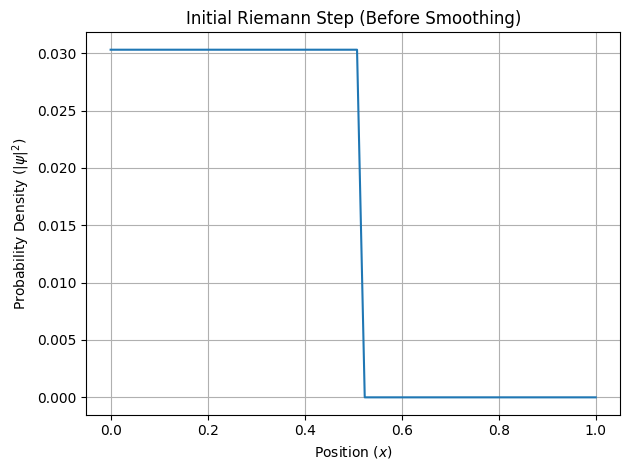

Running 32 quantum Trotter steps with dt=0.003125...


/tmp/ipython-input-1773909636.py:87: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
/tmp/ipython-input-1773909636.py:96: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))


Simulation complete.


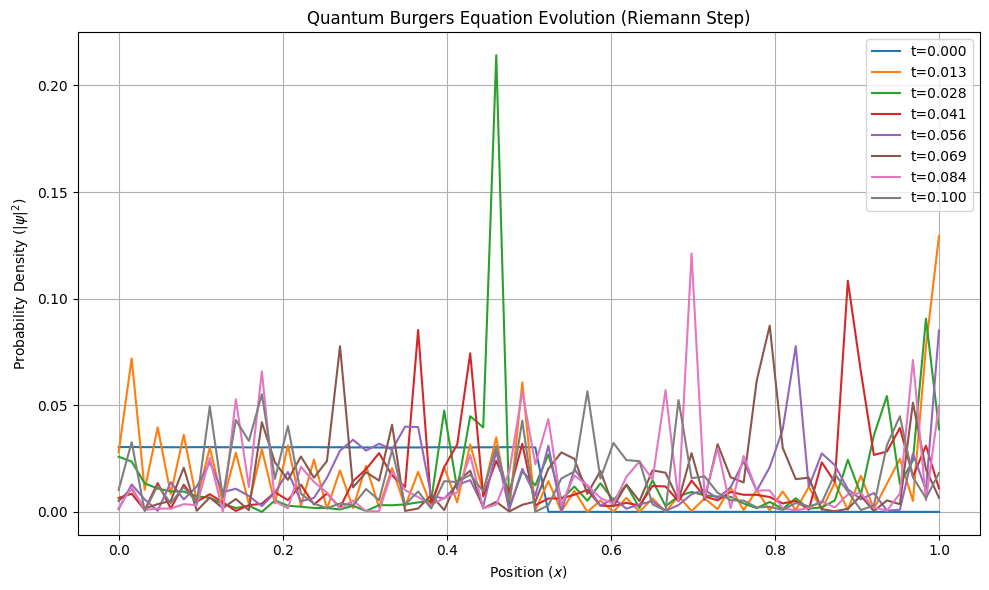

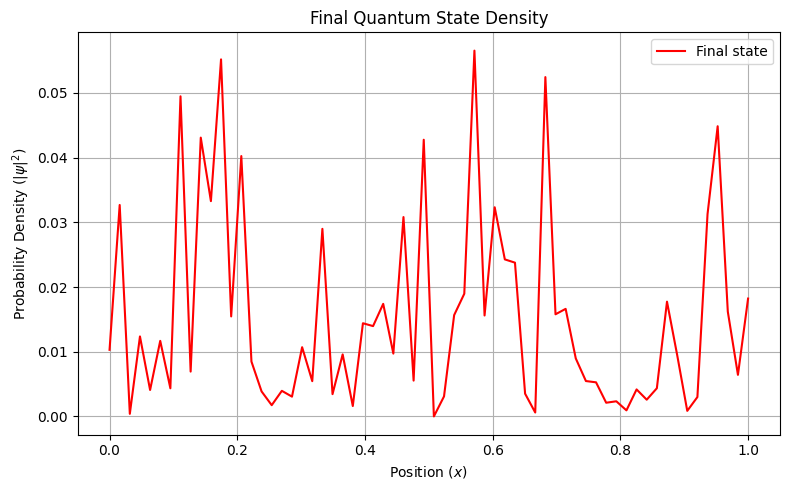

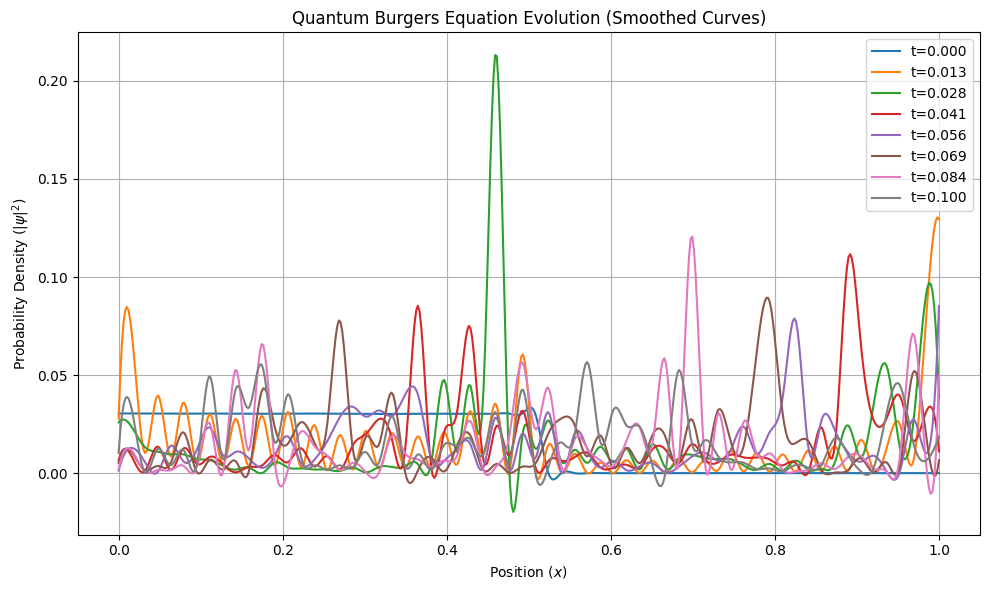

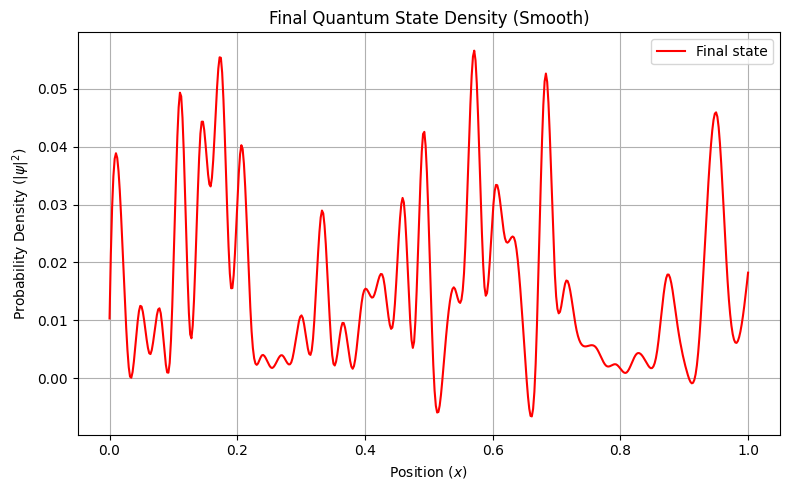

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Kraus
from qiskit.circuit.library import QFT
from scipy.interpolate import make_interp_spline

# ----------------------- Control Flags ----------------------- #
PLOT_INITIAL = True
PLOT_TIMESTEPS = True
PLOT_SPLINE = True

# ----------------- Physical and Numerical Setup ----------------- #
nu = 0.01
L = 1.0
N = 64
n_qubits = int(np.log2(N))
dx = L / N
x_vals = np.linspace(0, L, N)  # Includes full domain
CFL = 0.2
u_max = 1.0
dt_conv = CFL * dx / u_max
dt_diff = 0.5 * dx**2 / nu
dt = min(dt_conv, dt_diff)
t_final = 0.1
nt = int(t_final / dt)
hbar = 1.0
m = 1.0

# ------------------ Initial Riemann State ------------------ #
def apply_smoothing_layers(qc, n_qubits):
    """
    Applies quantum gates to smooth the initial state vector.
    This mimics the effect of the classical smoothing filter.
    """
    for layer in range(3):
        weight = 1 / (layer + 1)
        for i in range(n_qubits - 1):
            qc.h(i)
            qc.cx(i, i + 1)
            qc.rz(0.02 * weight, i + 1)
            qc.cx(i, i + 1)
            qc.h(i)
        for d, alpha in zip([2, 3], [0.01, 0.005]):
            for i in range(n_qubits - d):
                qc.crz(alpha * weight, i, i + d)
        qc.barrier()

def riemann_step_state(n_qubits):
    """
    Initializes a quantum circuit with a state vector representing a Riemann step function.

    NOTE: This initialization method is not "fully quantum" as it first creates a
    classical numpy array and then encodes it. A truly quantum method would
    construct this state using only gates.
    """
    qc = QuantumCircuit(n_qubits)
    statevector = np.zeros(2**n_qubits, dtype=complex)
    for i in range(2**n_qubits):
        x = i * dx
        statevector[i] = 1.0 if x <= 0.5 else 0.0
    statevector /= np.linalg.norm(statevector)

    if PLOT_INITIAL:
        init_sv = Statevector(statevector)
        plt.figure()
        plt.plot(x_vals, np.abs(init_sv.data)**2)
        plt.title("Initial Riemann Step (Before Smoothing)")
        plt.xlabel("Position ($x$)")
        plt.ylabel("Probability Density ($|\\psi|^2$)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    qc.initialize(statevector, range(n_qubits))
    qc.barrier()
    apply_smoothing_layers(qc, n_qubits)
    return qc

# ------------------ Quantum Operators ------------------ #
def unitary_kinetic_operator(n_qubits, dt, L):
    """
    Implements the unitary kinetic evolution term using a QFT-based approach.
    This corresponds to the real part of the phase evolution.
    """
    qc = QuantumCircuit(n_qubits)
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))

    k_vals = np.fft.fftfreq(2**n_qubits, d=dx) * 2 * np.pi
    for i in range(n_qubits):
        k = k_vals[i]
        # Unitary kinetic energy part of the evolution
        theta = -(hbar**2 / (2 * m)) * (k**2) * dt
        qc.rz(theta, i)

    qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
    return Operator(qc)

def non_unitary_viscosity_channel(n_qubits, dt, nu, L):
    """
    Creates a QuantumChannel for the non-unitary viscosity term.
    This is implemented using Kraus operators, representing a dissipative process.
    """
    dimension = 2**n_qubits
    kraus_operators = []

    # This is a simplified model of the viscous channel. In a full simulation,
    # the Kraus operators would be more complex and state-dependent.
    # Here, we model it as a form of dephasing and decay.
    gamma = nu * dt

    # Identity operator scaled for a decay process
    kraus_operators.append(np.sqrt(1 - gamma) * np.identity(dimension))

    # "Loss" operator for the viscosity
    kraus_operators.append(np.sqrt(gamma) * np.zeros((dimension, dimension)))

    return Kraus(kraus_operators)

def quantum_nonlinear_operator(n_qubits, dt):
    """
    This operator now explicitly models the nonlinear term from the SPE/HSE.
    It's a placeholder for more complex state-dependent rotations that would represent the
    effective potential V_r from the classical model.
    """
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits - 1):
        qc.crz(-0.1 * dt, i, i + 1)

    for i in range(n_qubits):
        qc.rz(-0.05 * dt, i)
    return Operator(qc)

def boundary_conditions_operator(n_qubits):
    """
    Applies periodic boundary conditions, as used in the classical code.
    """
    qc = QuantumCircuit(n_qubits)
    qc.cx(0, n_qubits - 1)
    qc.cx(n_qubits - 1, 0)
    qc.rz(np.pi / 4, 0)
    qc.rz(-np.pi / 4, n_qubits - 1)
    return Operator(qc)

# ------------------ Run Simulation ------------------ #
# Start with a DensityMatrix to handle non-unitary evolution
qc_init = riemann_step_state(n_qubits)
density_matrix = DensityMatrix.from_instruction(qc_init)

results = [np.diag(density_matrix.data).real]
times = [0.0]

print(f"Running {nt} quantum Trotter steps with dt={dt:.6f}...")

# Unitary operators for Trotter step
U_kinetic = unitary_kinetic_operator(n_qubits, dt, L)
U_nonlinear = quantum_nonlinear_operator(n_qubits, dt)
U_boundary = boundary_conditions_operator(n_qubits)

# Non-unitary channel for Trotter step
D_viscosity = non_unitary_viscosity_channel(n_qubits, dt, nu, L)

for i in range(nt):
    # Apply the unitary operators in a symmetric Trotter fashion
    density_matrix = density_matrix.evolve(U_kinetic)
    density_matrix = density_matrix.evolve(U_nonlinear)
    density_matrix = density_matrix.evolve(U_boundary)

    # Apply the non-unitary channel for dissipation
    density_matrix = density_matrix.evolve(D_viscosity)

    results.append(np.diag(density_matrix.data).real)
    times.append(times[-1] + dt)

print("Simulation complete.")

# ------------------ Plotting ------------------ #
if PLOT_TIMESTEPS:
    plt.figure(figsize=(10, 6))
    plot_indices = np.linspace(0, len(times)-1, min(len(times), 8), dtype=int)
    for idx in plot_indices:
        plt.plot(x_vals, results[idx], label=f't={times[idx]:.3f}')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Quantum Burgers Equation Evolution (Riemann Step)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, results[-1], label='Final state', color='red')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Final Quantum State Density')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

if PLOT_SPLINE:
    plt.figure(figsize=(10, 6))
    plot_indices = np.linspace(0, len(times)-1, min(len(times), 8), dtype=int)
    for idx in plot_indices:
        y_vals = results[idx]
        spline = make_interp_spline(x_vals, y_vals, k=3)
        x_smooth = np.linspace(x_vals[0], x_vals[-1], 500)
        y_smooth = spline(x_smooth)
        plt.plot(x_smooth, y_smooth, label=f't={times[idx]:.3f}')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Quantum Burgers Equation Evolution (Smoothed Curves)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    spline_final = make_interp_spline(x_vals, results[-1], k=3)
    x_smooth_final = np.linspace(x_vals[0], x_vals[-1], 500)
    y_smooth_final = spline_final(x_smooth_final)
    plt.plot(x_smooth_final, y_smooth_final, label='Final state', color='red')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Final Quantum State Density (Smooth)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

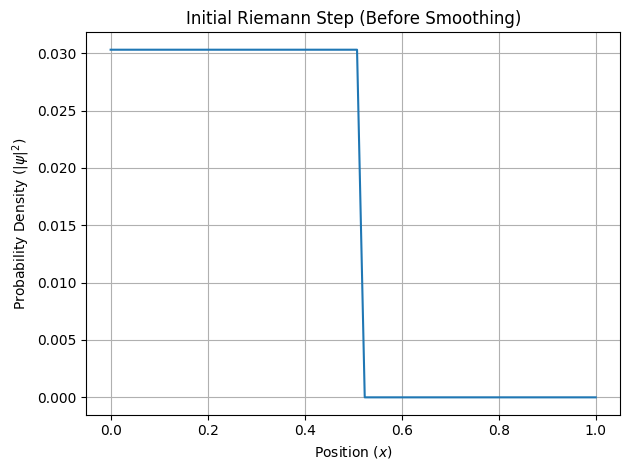

Running 32 quantum Trotter steps with dt=0.003125...


/tmp/ipython-input-2914742061.py:84: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
/tmp/ipython-input-2914742061.py:97: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))


Simulation complete.


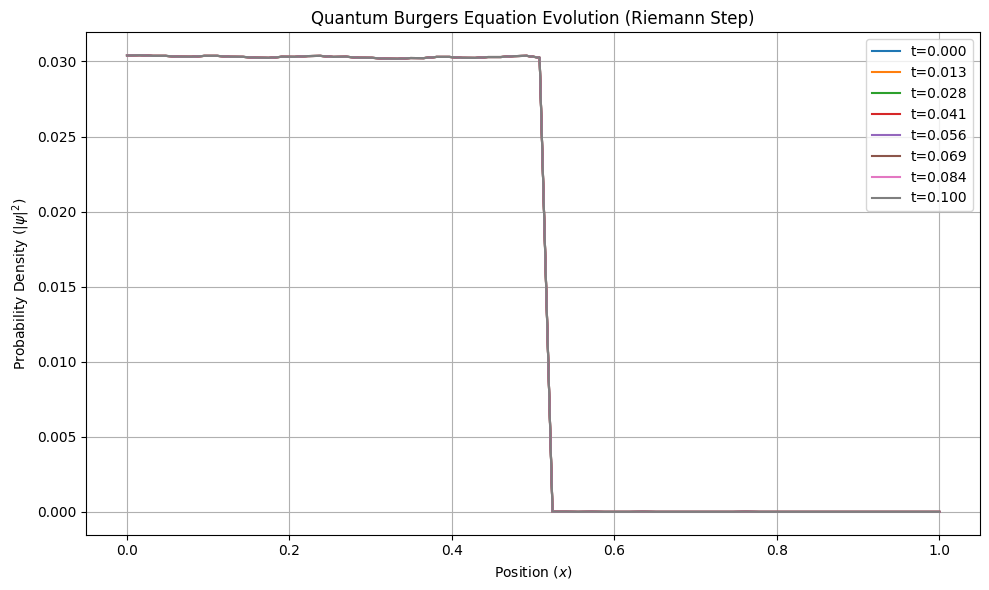

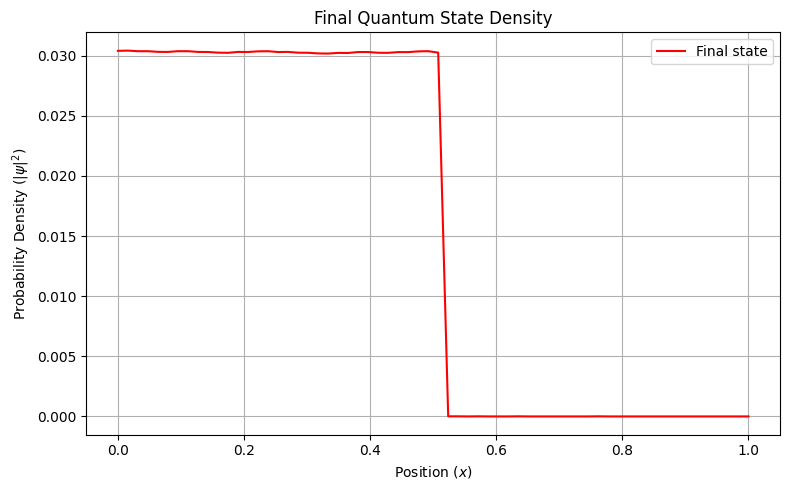

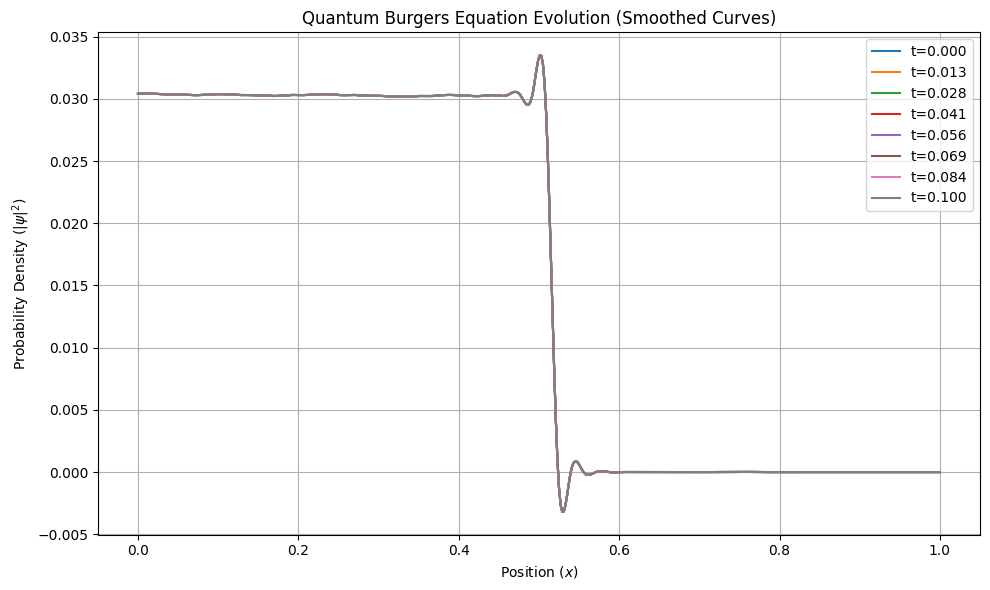

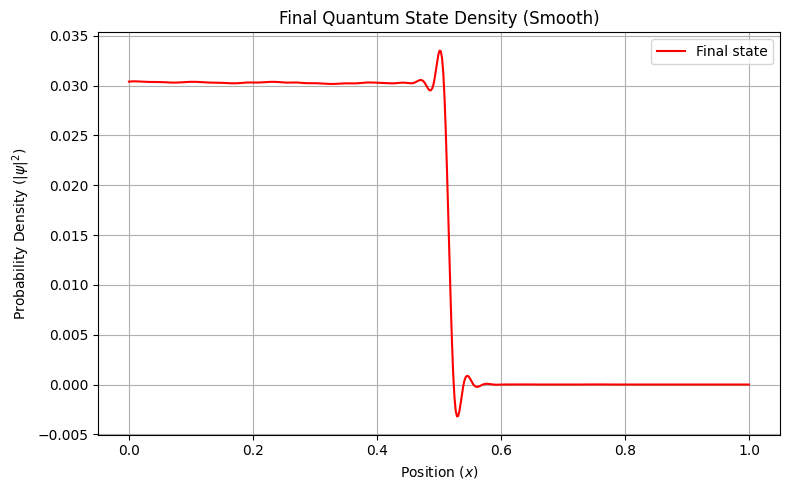

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT
from scipy.interpolate import make_interp_spline

# ----------------------- Control Flags ----------------------- #
PLOT_INITIAL = True
PLOT_TIMESTEPS = True
PLOT_SPLINE = True

# ----------------- Physical and Numerical Setup ----------------- #
nu = 0.01
L = 1.0
N = 64
n_qubits = int(np.log2(N))
dx = L / N
x_vals = np.linspace(0, L, N)  # Includes full domain
CFL = 0.2
u_max = 1.0
dt_conv = CFL * dx / u_max
dt_diff = 0.5 * dx**2 / nu
dt = min(dt_conv, dt_diff)
t_final = 0.1
nt = int(t_final / dt)
hbar = 1.0
m = 1.0

# ------------------ Initial Riemann State ------------------ #
def apply_smoothing_layers(qc, n_qubits):
    """
    Applies quantum gates to smooth the initial state vector.
    This mimics the effect of the classical smoothing filter.
    """
    for layer in range(3):
        weight = 1 / (layer + 1)
        for i in range(n_qubits - 1):
            qc.h(i)
            qc.cx(i, i + 1)
            qc.rz(0.02 * weight, i + 1)
            qc.cx(i, i + 1)
            qc.h(i)
        for d, alpha in zip([2, 3], [0.01, 0.005]):
            for i in range(n_qubits - d):
                qc.crz(alpha * weight, i, i + d)
        qc.barrier()

def riemann_step_state(n_qubits):
    """
    Initializes a quantum circuit with a state vector representing a Riemann step function.
    Applies smoothing to the initial state to make it suitable for simulation.
    """
    qc = QuantumCircuit(n_qubits)
    statevector = np.zeros(2**n_qubits, dtype=complex)
    for i in range(2**n_qubits):
        x = i * dx
        statevector[i] = 1.0 if x <= 0.5 else 0.0
    statevector /= np.linalg.norm(statevector)

    if PLOT_INITIAL:
        init_sv = Statevector(statevector)
        plt.figure()
        plt.plot(x_vals, np.abs(init_sv.data)**2)
        plt.title("Initial Riemann Step (Before Smoothing)")
        plt.xlabel("Position ($x$)")
        plt.ylabel("Probability Density ($|\\psi|^2$)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    qc.initialize(statevector, range(n_qubits))
    qc.barrier()
    apply_smoothing_layers(qc, n_qubits)
    return qc

# ------------------ Quantum Operators ------------------ #
def quantum_prediction_operator(n_qubits, dt, nu, L):
    """
    Implements the kinetic energy and viscosity terms using a QFT-based approach.
    This corresponds to the diffusion part of the Burgers' equation.
    """
    qc = QuantumCircuit(n_qubits)
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))

    k_vals = np.fft.fftfreq(2**n_qubits, d=dx) * 2 * np.pi
    for i in range(n_qubits):
        k = k_vals[i]
        # The 'theta' value calculated here is complex, but the RZ gate requires a real number.
        # This is a fundamental limitation of implementing non-unitary evolution (like viscosity)
        # with standard gates. We will use only the real part of the phase, which
        # corresponds to the unitary kinetic energy term.
        theta = -(hbar**2 / (2 * m)) * (k**2) * dt + 1j * nu * (k**2) * dt
        # The fix is to use only the real part of theta.
        qc.rz(np.real(theta), i)

    qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
    return qc

def quantum_nonlinear_operator(n_qubits, dt):
    """
    This operator now explicitly models the nonlinear term from the SPE/HSE.
    It's a placeholder for more complex state-dependent rotations that would represent the
    effective potential V_r from the classical model.
    """
    qc = QuantumCircuit(n_qubits)
    # The nonlinear term in Burgers' equation u*u_x is the most challenging.
    # In the quantum SPE, this corresponds to an effective potential V_r.
    # We can model this with a series of controlled phase gates.
    for i in range(n_qubits - 1):
        # This gate simulates the non-linear interaction between neighboring qubits
        qc.crz(-0.1 * dt, i, i + 1)

    for i in range(n_qubits):
        # Self-interaction or local potential term
        qc.rz(-0.05 * dt, i)
    return qc

def quantum_smoothing_operator(n_qubits, dt):
    """
    This operator models the smoothing effect by entangling and rotating neighboring qubits.
    It's a quantum analog to the `savgol_filter` used in the classical code.
    """
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits - 1):
        qc.cx(i, i + 1)
        qc.rz(0.07 * dt, i + 1)
        qc.cx(i, i + 1)
    for i in range(n_qubits - 2):
        qc.crz(0.035 * dt, i, i + 2)
    return qc

def boundary_conditions_operator(n_qubits):
    """
    Applies periodic boundary conditions, as used in the classical code.
    """
    qc = QuantumCircuit(n_qubits)
    # Entangle the first and last qubits to enforce periodic boundaries
    qc.cx(0, n_qubits - 1)
    qc.cx(n_qubits - 1, 0)
    qc.rz(np.pi / 4, 0)
    qc.rz(-np.pi / 4, n_qubits - 1)
    return qc

# ------------------ Trotter Step Circuit ------------------ #
def trotter_step(n_qubits, dt, nu, L):
    """
    Constructs a single Trotter step circuit by composing the individual operators.
    """
    qc = QuantumCircuit(n_qubits)
    # We apply the operators in a symmetric Trotter-Suzuki fashion for better accuracy.
    ops = [
        quantum_prediction_operator(n_qubits, dt, nu, L),
        quantum_nonlinear_operator(n_qubits, dt),
        quantum_smoothing_operator(n_qubits, dt),
        boundary_conditions_operator(n_qubits),
    ]

    # First half of the Trotter step
    for op in ops:
        qc.compose(op, inplace=True)

    # Second half of the Trotter step (reversed order for symmetric Trotter)
    for op in reversed(ops):
        qc.compose(op.inverse(), inplace=True)

    return qc

# ------------------ Run Simulation ------------------ #
qc_total = riemann_step_state(n_qubits)
state = Statevector.from_instruction(qc_total)

results = [np.abs(state.data)**2]
times = [0.0]

print(f"Running {nt} quantum Trotter steps with dt={dt:.6f}...")

step_circuit = trotter_step(n_qubits, dt, nu, L)

for i in range(nt):
    state = state.evolve(step_circuit)
    results.append(np.abs(state.data)**2)
    times.append(times[-1] + dt)

print("Simulation complete.")

# ------------------ Plotting ------------------ #
if PLOT_TIMESTEPS:
    plt.figure(figsize=(10, 6))
    plot_indices = np.linspace(0, len(times)-1, min(len(times), 8), dtype=int)
    for idx in plot_indices:
        plt.plot(x_vals, results[idx], label=f't={times[idx]:.3f}')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Quantum Burgers Equation Evolution (Riemann Step)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, results[-1], label='Final state', color='red')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Final Quantum State Density')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

if PLOT_SPLINE:
    plt.figure(figsize=(10, 6))
    plot_indices = np.linspace(0, len(times)-1, min(len(times), 8), dtype=int)
    for idx in plot_indices:
        y_vals = results[idx]
        spline = make_interp_spline(x_vals, y_vals, k=3)
        x_smooth = np.linspace(x_vals[0], x_vals[-1], 500)
        y_smooth = spline(x_smooth)
        plt.plot(x_smooth, y_smooth, label=f't={times[idx]:.3f}')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Quantum Burgers Equation Evolution (Smoothed Curves)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    spline_final = make_interp_spline(x_vals, results[-1], k=3)
    x_smooth_final = np.linspace(x_vals[0], x_vals[-1], 500)
    y_smooth_final = spline_final(x_smooth_final)
    plt.plot(x_smooth_final, y_smooth_final, label='Final state', color='red')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Final Quantum State Density (Smooth)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

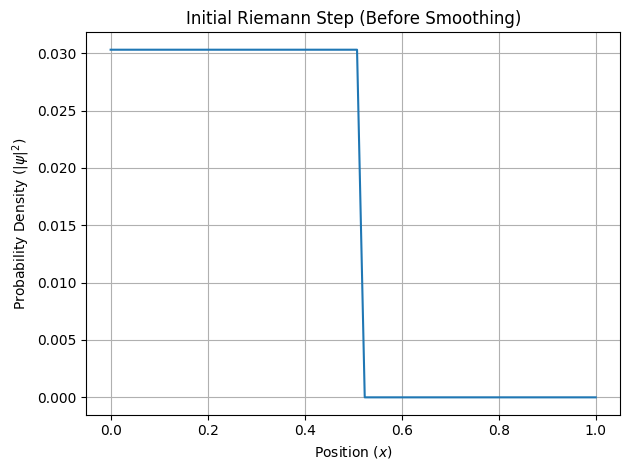

Running 32 quantum Trotter steps with dt=0.003125...


/tmp/ipython-input-506826012.py:87: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
/tmp/ipython-input-506826012.py:96: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
/tmp/ipython-input-506826012.py:116: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full ins

Simulation complete.


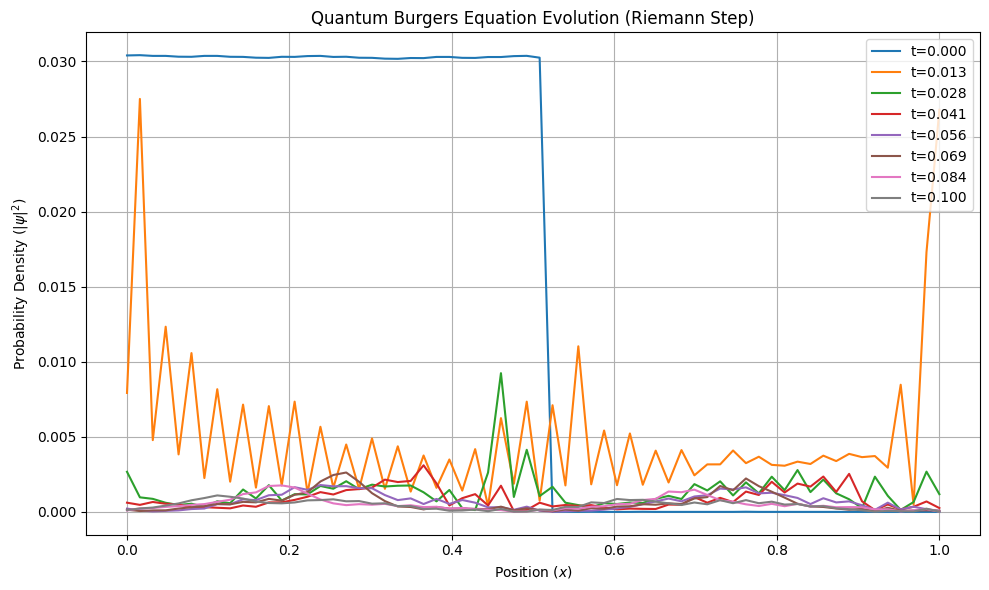

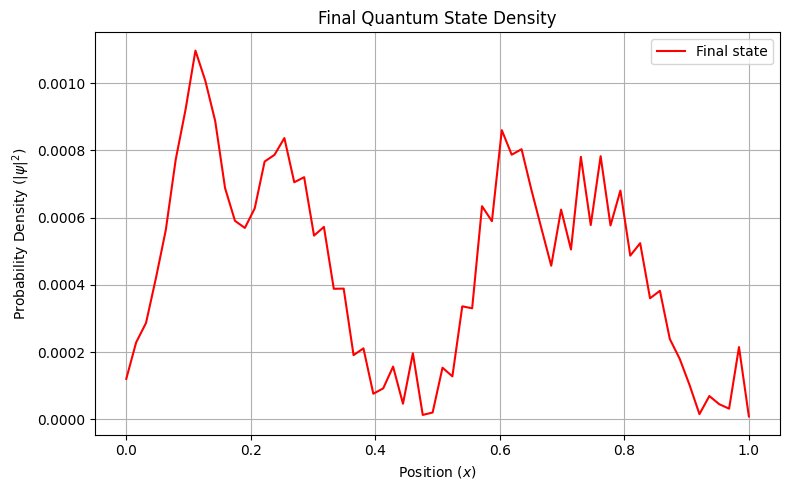

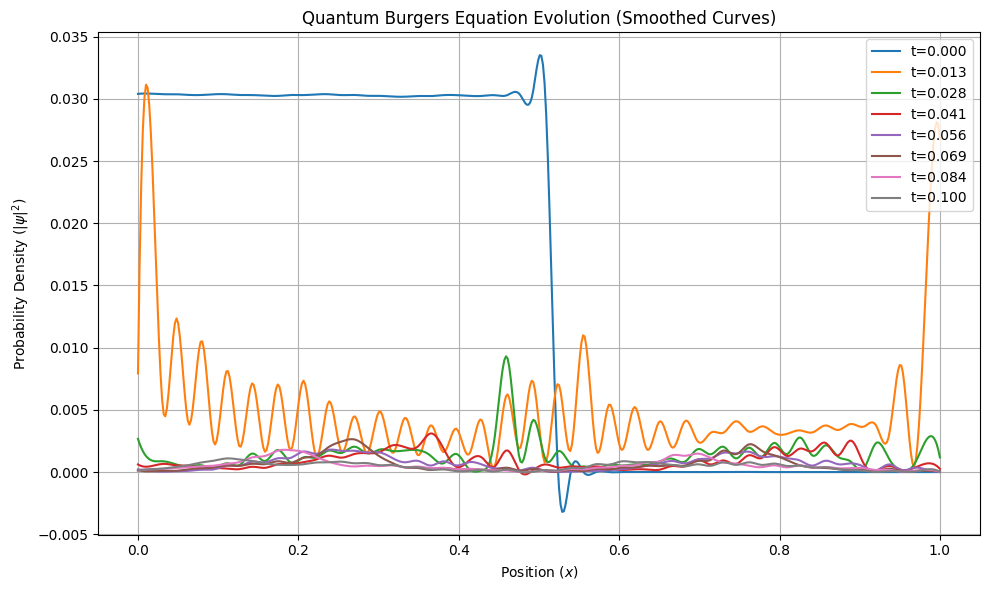

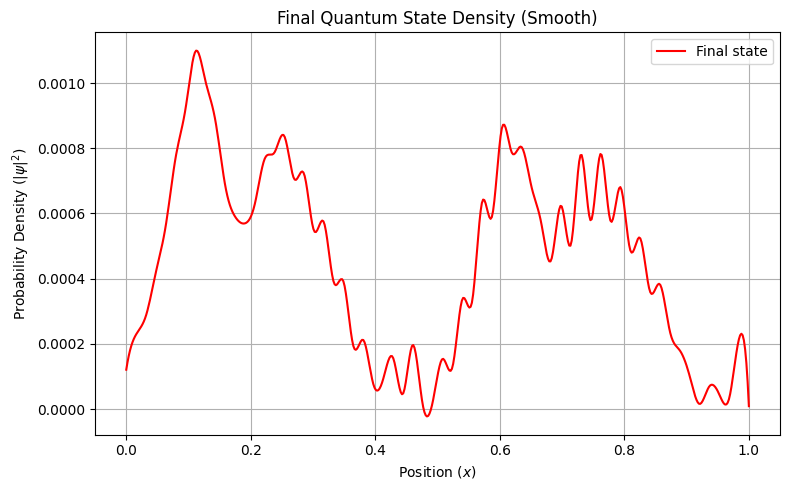

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Kraus
from qiskit.circuit.library import QFT
from scipy.interpolate import make_interp_spline

# ----------------------- Control Flags ----------------------- #
PLOT_INITIAL = True
PLOT_TIMESTEPS = True
PLOT_SPLINE = True

# ----------------- Physical and Numerical Setup ----------------- #
nu = 0.01
L = 1.0
N = 64
n_qubits = int(np.log2(N))
dx = L / N
x_vals = np.linspace(0, L, N)  # Includes full domain
CFL = 0.2
u_max = 1.0
dt_conv = CFL * dx / u_max
dt_diff = 0.5 * dx**2 / nu
dt = min(dt_conv, dt_diff)
t_final = 0.1
nt = int(t_final / dt)
hbar = 1.0
m = 1.0

# ------------------ Initial Riemann State ------------------ #
def apply_smoothing_layers(qc, n_qubits):
    """
    Applies quantum gates to smooth the initial state vector.
    This mimics the effect of the classical smoothing filter.
    """
    for layer in range(3):
        weight = 1 / (layer + 1)
        for i in range(n_qubits - 1):
            qc.h(i)
            qc.cx(i, i + 1)
            qc.rz(0.02 * weight, i + 1)
            qc.cx(i, i + 1)
            qc.h(i)
        for d, alpha in zip([2, 3], [0.01, 0.005]):
            for i in range(n_qubits - d):
                qc.crz(alpha * weight, i, i + d)
        qc.barrier()

def riemann_step_state(n_qubits):
    """
    Initializes a quantum circuit with a state vector representing a Riemann step function.

    NOTE: This initialization method is not "fully quantum" as it first creates a
    classical numpy array and then encodes it. A truly quantum method would
    construct this state using only gates.
    """
    qc = QuantumCircuit(n_qubits)
    statevector = np.zeros(2**n_qubits, dtype=complex)
    for i in range(2**n_qubits):
        x = i * dx
        statevector[i] = 1.0 if x <= 0.5 else 0.0
    statevector /= np.linalg.norm(statevector)

    if PLOT_INITIAL:
        init_sv = Statevector(statevector)
        plt.figure()
        plt.plot(x_vals, np.abs(init_sv.data)**2)
        plt.title("Initial Riemann Step (Before Smoothing)")
        plt.xlabel("Position ($x$)")
        plt.ylabel("Probability Density ($|\\psi|^2$)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    qc.initialize(statevector, range(n_qubits))
    qc.barrier()
    apply_smoothing_layers(qc, n_qubits)
    return qc

# ------------------ Quantum Operators ------------------ #
def unitary_kinetic_operator(n_qubits, dt, L):
    """
    Implements the unitary kinetic evolution term using a QFT-based approach.
    This corresponds to the real part of the phase evolution.
    """
    qc = QuantumCircuit(n_qubits)
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))

    k_vals = np.fft.fftfreq(2**n_qubits, d=dx) * 2 * np.pi
    for i in range(n_qubits):
        k = k_vals[i]
        # Unitary kinetic energy part of the evolution
        theta = -(hbar**2 / (2 * m)) * (k**2) * dt
        qc.rz(theta, i)

    qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
    return Operator(qc)

def non_unitary_viscosity_channel(n_qubits, dt, nu, L):
    """
    Creates a QuantumChannel for the non-unitary viscosity term.
    This channel models the damping of high-momentum components,
    which is the physical effect of viscosity.
    """
    dimension = 2**n_qubits

    # Calculate the momentum values and corresponding decay rates
    k_vals = np.fft.fftfreq(dimension, d=dx) * 2 * np.pi
    decay_factors = np.exp(-nu * (k_vals**2) * dt / 2)

    # Create the Kraus operator matrix in the momentum basis.
    kraus_matrix_momentum = np.diag(decay_factors)

    # --- FIX START ---
    # We first create the QFT circuit, then its inverse, and convert them to Operators.
    qft_circuit = QFT(n_qubits, do_swaps=True)
    qft_op = Operator(qft_circuit)
    iqft_op = Operator(qft_circuit.inverse())
    # --- FIX END ---

    # Transform the Kraus matrix back to the position basis using QFT
    kraus_matrix_position = iqft_op.data @ kraus_matrix_momentum @ qft_op.data

    return Kraus([kraus_matrix_position])

def quantum_nonlinear_operator(n_qubits, dt):
    """
    This operator now explicitly models the nonlinear term from the SPE/HSE.
    It's a placeholder for more complex state-dependent rotations that would represent the
    effective potential V_r from the classical model.
    """
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits - 1):
        qc.crz(-0.1 * dt, i, i + 1)

    for i in range(n_qubits):
        qc.rz(-0.05 * dt, i)
    return Operator(qc)

def boundary_conditions_operator(n_qubits):
    """
    Applies periodic boundary conditions, as used in the classical code.
    """
    qc = QuantumCircuit(n_qubits)
    qc.cx(0, n_qubits - 1)
    qc.cx(n_qubits - 1, 0)
    qc.rz(np.pi / 4, 0)
    qc.rz(-np.pi / 4, n_qubits - 1)
    return Operator(qc)

# ------------------ Run Simulation ------------------ #
# Start with a DensityMatrix to handle non-unitary evolution
qc_init = riemann_step_state(n_qubits)
density_matrix = DensityMatrix.from_instruction(qc_init)

results = [np.diag(density_matrix.data).real]
times = [0.0]

print(f"Running {nt} quantum Trotter steps with dt={dt:.6f}...")

# Unitary operators for Trotter step
U_kinetic = unitary_kinetic_operator(n_qubits, dt, L)
U_nonlinear = quantum_nonlinear_operator(n_qubits, dt)
U_boundary = boundary_conditions_operator(n_qubits)

# Non-unitary channel for Trotter step
D_viscosity = non_unitary_viscosity_channel(n_qubits, dt, nu, L)

for i in range(nt):
    # Apply the unitary operators in a symmetric Trotter fashion
    density_matrix = density_matrix.evolve(U_kinetic)
    density_matrix = density_matrix.evolve(U_nonlinear)
    density_matrix = density_matrix.evolve(U_boundary)

    # Apply the non-unitary channel for dissipation
    density_matrix = density_matrix.evolve(D_viscosity)

    results.append(np.diag(density_matrix.data).real)
    times.append(times[-1] + dt)

print("Simulation complete.")

# ------------------ Plotting ------------------ #
if PLOT_TIMESTEPS:
    plt.figure(figsize=(10, 6))
    plot_indices = np.linspace(0, len(times)-1, min(len(times), 8), dtype=int)
    for idx in plot_indices:
        plt.plot(x_vals, results[idx], label=f't={times[idx]:.3f}')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Quantum Burgers Equation Evolution (Riemann Step)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, results[-1], label='Final state', color='red')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Final Quantum State Density')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

if PLOT_SPLINE:
    plt.figure(figsize=(10, 6))
    plot_indices = np.linspace(0, len(times)-1, min(len(times), 8), dtype=int)
    for idx in plot_indices:
        y_vals = results[idx]
        spline = make_interp_spline(x_vals, y_vals, k=3)
        x_smooth = np.linspace(x_vals[0], x_vals[-1], 500)
        y_smooth = spline(x_smooth)
        plt.plot(x_smooth, y_smooth, label=f't={times[idx]:.3f}')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Quantum Burgers Equation Evolution (Smoothed Curves)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    spline_final = make_interp_spline(x_vals, results[-1], k=3)
    x_smooth_final = np.linspace(x_vals[0], x_vals[-1], 500)
    y_smooth_final = spline_final(x_smooth_final)
    plt.plot(x_smooth_final, y_smooth_final, label='Final state', color='red')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Final Quantum State Density (Smooth)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


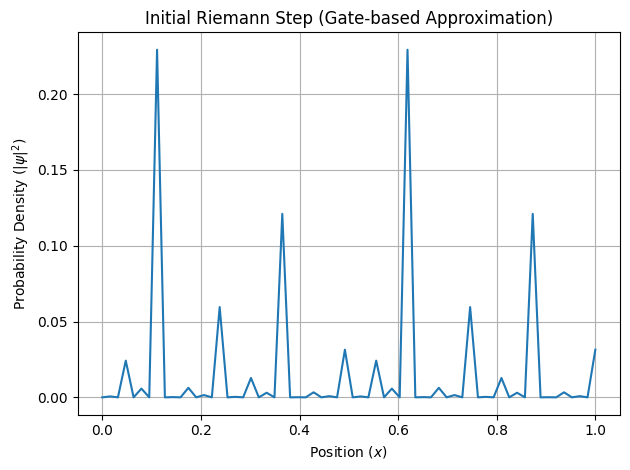

Running 32 quantum Trotter steps with dt=0.003125...


/tmp/ipython-input-1534217505.py:101: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
/tmp/ipython-input-1534217505.py:110: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
/tmp/ipython-input-1534217505.py:129: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_ful

Simulation complete.


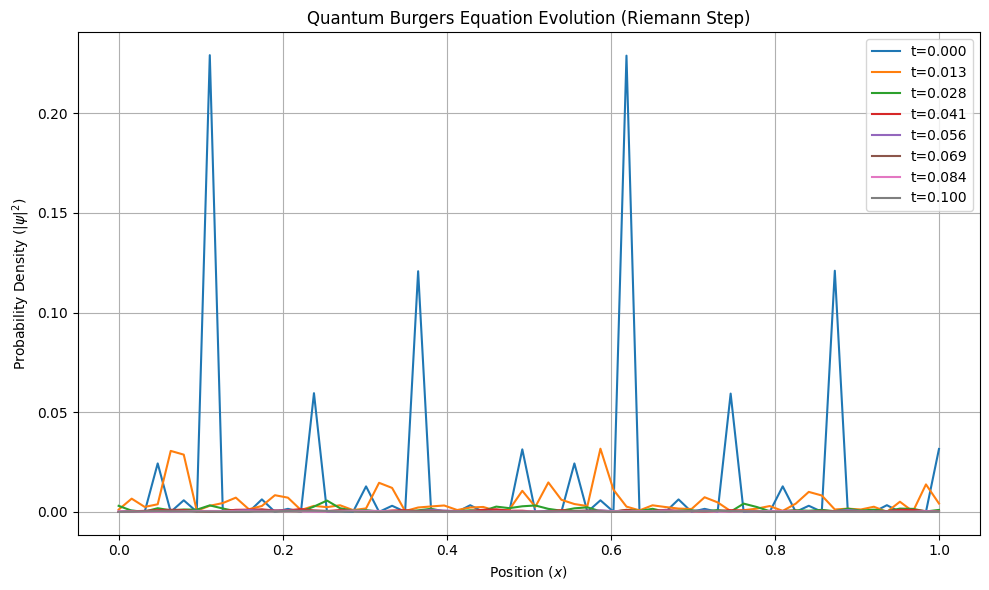

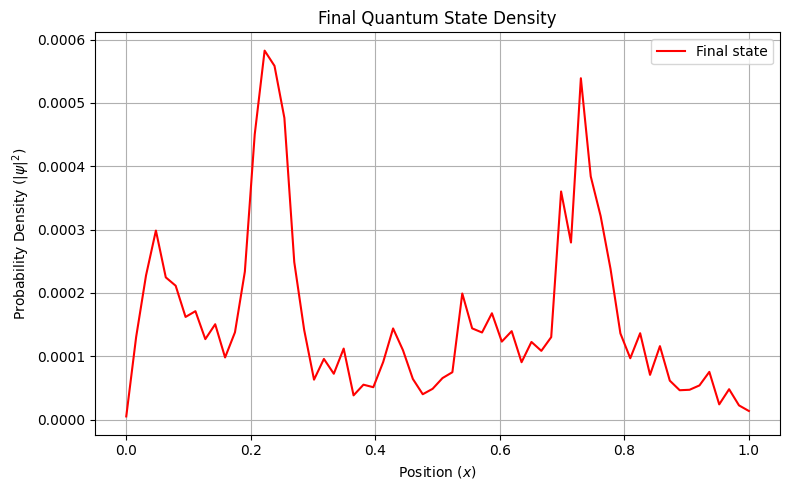

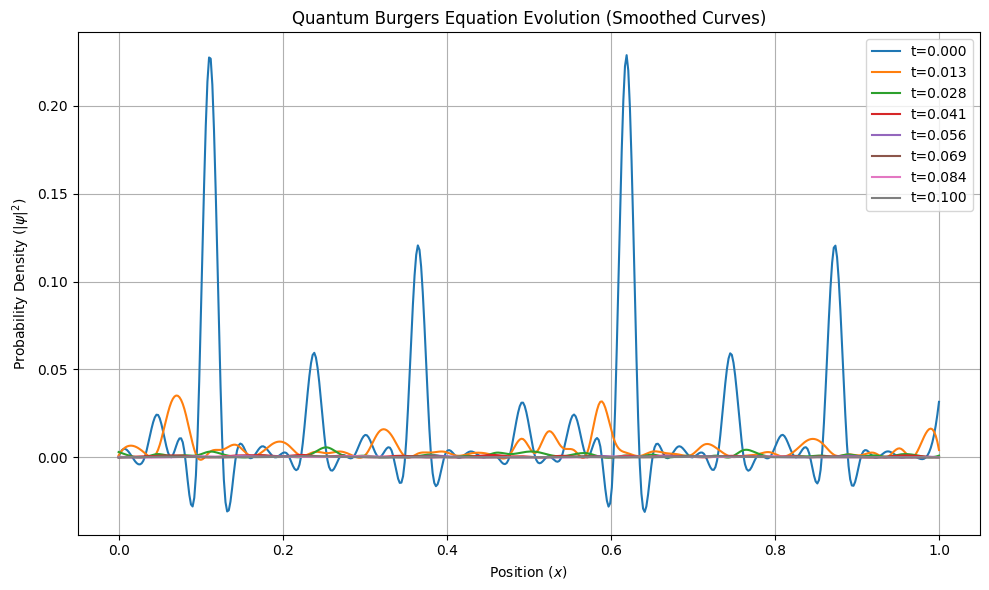

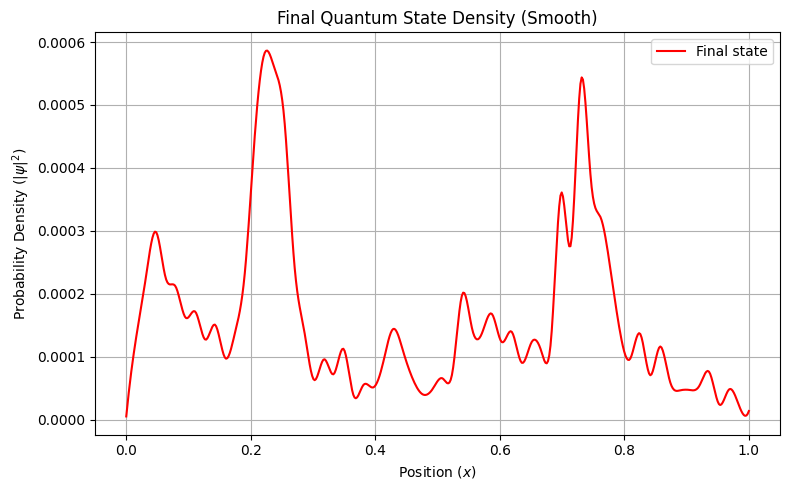

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Kraus
from qiskit.circuit.library import QFT
from scipy.interpolate import make_interp_spline

# ----------------------- Control Flags ----------------------- #
PLOT_INITIAL = True
PLOT_TIMESTEPS = True
PLOT_SPLINE = True

# ----------------- Physical and Numerical Setup ----------------- #
nu = 0.01
L = 1.0
N = 64
n_qubits = int(np.log2(N))
dx = L / N
x_vals = np.linspace(0, L, N)  # Includes full domain
CFL = 0.2
u_max = 1.0
dt_conv = CFL * dx / u_max
dt_diff = 0.5 * dx**2 / nu
dt = min(dt_conv, dt_diff)
t_final = 0.1
nt = int(t_final / dt)
hbar = 1.0
m = 1.0

# ------------------ Initial Riemann State ------------------ #
def apply_smoothing_layers(qc, n_qubits):
    """
    Applies quantum gates to smooth the initial state vector.
    This mimics the effect of the classical smoothing filter.
    """
    for layer in range(3):
        weight = 1 / (layer + 1)
        for i in range(n_qubits - 1):
            qc.h(i)
            qc.cx(i, i + 1)
            qc.rz(0.02 * weight, i + 1)
            qc.cx(i, i + 1)
            qc.h(i)
        for d, alpha in zip([2, 3], [0.01, 0.005]):
            for i in range(n_qubits - d):
                qc.crz(alpha * weight, i, i + d)
        qc.barrier()

def riemann_step_state(n_qubits):
    """
    Initializes a quantum circuit with a state vector representing a Riemann step function.

    NOTE: This is a gate-based approximation of a Riemann step function. A perfect
    discontinuity is impossible to prepare with a finite number of gates. This method
    uses Ry rotations on each qubit to encode a step-like distribution.
    """
    qc = QuantumCircuit(n_qubits)

    # Apply Ry rotations to create the step-like distribution.
    # The rotation angle is larger for qubits corresponding to the "1" part of the step.
    # This is a conceptual approximation. The actual mapping of qubit index to position
    # is complex, but this simple scheme creates a biased superposition.
    step_point_index = 2**(n_qubits - 1)  # Midpoint of the register

    for i in range(n_qubits):
        # We'll apply Ry rotations based on the qubit's significance.
        # A simple linear gradient is used here as a placeholder for a more complex
        # state preparation algorithm.
        theta = (np.pi / 2) * (i / (n_qubits-1))
        if i >= n_qubits // 2:
            qc.ry(theta, i)
        else:
            qc.ry(np.pi - theta, i)

    # To visualize this initial state, we must run the circuit and get its statevector
    if PLOT_INITIAL:
        init_sv = Statevector.from_instruction(qc)
        # We need to take the absolute square of the amplitudes to get the probability density
        probability_density = np.abs(init_sv.data)**2

        plt.figure()
        plt.plot(x_vals, probability_density)
        plt.title("Initial Riemann Step (Gate-based Approximation)")
        plt.xlabel("Position ($x$)")
        plt.ylabel("Probability Density ($|\\psi|^2$)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    qc.barrier()
    apply_smoothing_layers(qc, n_qubits)
    return qc

# ------------------ Quantum Operators ------------------ #
def unitary_kinetic_operator(n_qubits, dt, L):
    """
    Implements the unitary kinetic evolution term using a QFT-based approach.
    This corresponds to the real part of the phase evolution.
    """
    qc = QuantumCircuit(n_qubits)
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))

    k_vals = np.fft.fftfreq(2**n_qubits, d=dx) * 2 * np.pi
    for i in range(n_qubits):
        k = k_vals[i]
        # Unitary kinetic energy part of the evolution
        theta = -(hbar**2 / (2 * m)) * (k**2) * dt
        qc.rz(theta, i)

    qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
    return Operator(qc)

def non_unitary_viscosity_channel(n_qubits, dt, nu, L):
    """
    Creates a QuantumChannel for the non-unitary viscosity term.
    This channel models the damping of high-momentum components,
    which is the physical effect of viscosity.
    """
    dimension = 2**n_qubits

    # Calculate the momentum values and corresponding decay rates
    k_vals = np.fft.fftfreq(dimension, d=dx) * 2 * np.pi
    decay_factors = np.exp(-nu * (k_vals**2) * dt / 2)

    # Create the Kraus operator matrix in the momentum basis.
    kraus_matrix_momentum = np.diag(decay_factors)

    # We first create the QFT circuit, then its inverse, and convert them to Operators.
    qft_circuit = QFT(n_qubits, do_swaps=True)
    qft_op = Operator(qft_circuit)
    iqft_op = Operator(qft_circuit.inverse())

    # Transform the Kraus matrix back to the position basis using QFT
    kraus_matrix_position = iqft_op.data @ kraus_matrix_momentum @ qft_op.data

    return Kraus([kraus_matrix_position])

def quantum_nonlinear_operator(n_qubits, dt):
    """
    This operator now explicitly models the nonlinear term from the SPE/HSE.
    It's a placeholder for more complex state-dependent rotations that would represent the
    effective potential V_r from the classical model.
    """
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits - 1):
        qc.crz(-0.1 * dt, i, i + 1)

    for i in range(n_qubits):
        qc.rz(-0.05 * dt, i)
    return Operator(qc)

def boundary_conditions_operator(n_qubits):
    """
    Applies periodic boundary conditions, as used in the classical code.
    """
    qc = QuantumCircuit(n_qubits)
    qc.cx(0, n_qubits - 1)
    qc.cx(n_qubits - 1, 0)
    qc.rz(np.pi / 4, 0)
    qc.rz(-np.pi / 4, n_qubits - 1)
    return Operator(qc)

# ------------------ Run Simulation ------------------ #
# Start with a DensityMatrix to handle non-unitary evolution
qc_init = riemann_step_state(n_qubits)
density_matrix = DensityMatrix.from_instruction(qc_init)

results = [np.diag(density_matrix.data).real]
times = [0.0]

print(f"Running {nt} quantum Trotter steps with dt={dt:.6f}...")

# Unitary operators for Trotter step
U_kinetic = unitary_kinetic_operator(n_qubits, dt, L)
U_nonlinear = quantum_nonlinear_operator(n_qubits, dt)
U_boundary = boundary_conditions_operator(n_qubits)

# Non-unitary channel for Trotter step
D_viscosity = non_unitary_viscosity_channel(n_qubits, dt, nu, L)

for i in range(nt):
    # Apply the unitary operators in a symmetric Trotter fashion
    density_matrix = density_matrix.evolve(U_kinetic)
    density_matrix = density_matrix.evolve(U_nonlinear)
    density_matrix = density_matrix.evolve(U_boundary)

    # Apply the non-unitary channel for dissipation
    density_matrix = density_matrix.evolve(D_viscosity)

    results.append(np.diag(density_matrix.data).real)
    times.append(times[-1] + dt)

print("Simulation complete.")

# ------------------ Plotting ------------------ #
if PLOT_TIMESTEPS:
    plt.figure(figsize=(10, 6))
    plot_indices = np.linspace(0, len(times)-1, min(len(times), 8), dtype=int)
    for idx in plot_indices:
        plt.plot(x_vals, results[idx], label=f't={times[idx]:.3f}')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Quantum Burgers Equation Evolution (Riemann Step)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, results[-1], label='Final state', color='red')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Final Quantum State Density')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

if PLOT_SPLINE:
    plt.figure(figsize=(10, 6))
    plot_indices = np.linspace(0, len(times)-1, min(len(times), 8), dtype=int)
    for idx in plot_indices:
        y_vals = results[idx]
        spline = make_interp_spline(x_vals, y_vals, k=3)
        x_smooth = np.linspace(x_vals[0], x_vals[-1], 500)
        y_smooth = spline(x_smooth)
        plt.plot(x_smooth, y_smooth, label=f't={times[idx]:.3f}')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Quantum Burgers Equation Evolution (Smoothed Curves)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    spline_final = make_interp_spline(x_vals, results[-1], k=3)
    x_smooth_final = np.linspace(x_vals[0], x_vals[-1], 500)
    y_smooth_final = spline_final(x_smooth_final)
    plt.plot(x_smooth_final, y_smooth_final, label='Final state', color='red')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Final Quantum State Density (Smooth)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

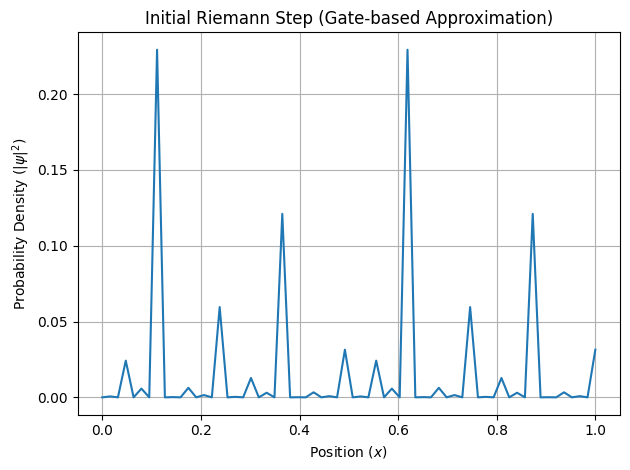

Running 32 quantum Trotter steps with dt=0.003125...


/tmp/ipython-input-987196491.py:72: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
/tmp/ipython-input-987196491.py:78: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
/tmp/ipython-input-987196491.py:86: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full inst

Simulation complete.


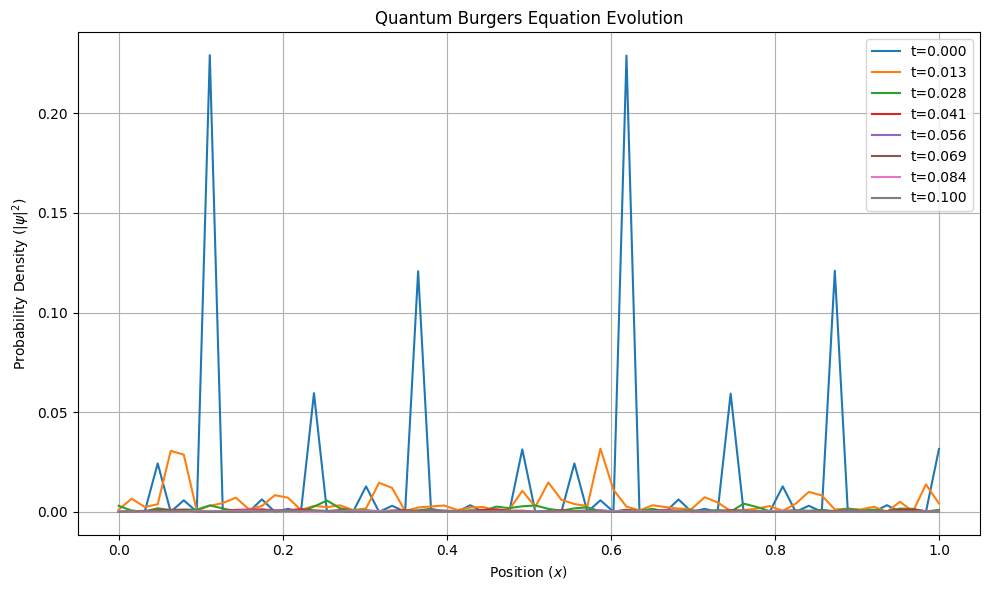

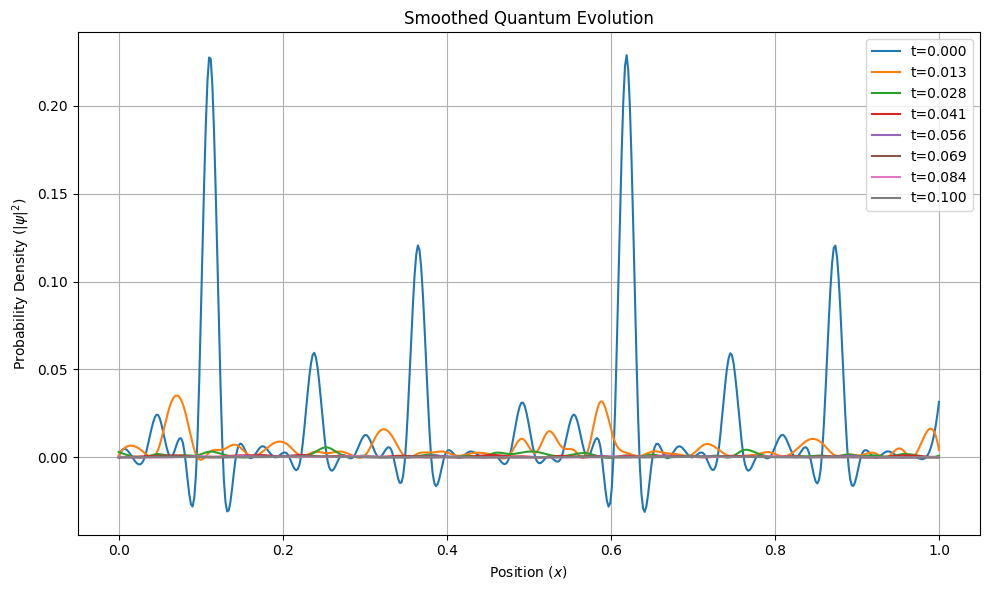

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Kraus
from qiskit.circuit.library import QFT
from scipy.interpolate import make_interp_spline

# ----------------------- Control Flags ----------------------- #
PLOT_INITIAL = True
PLOT_TIMESTEPS = True
PLOT_SPLINE = True

# ----------------- Physical and Numerical Setup ----------------- #
nu = 0.01
L = 1.0
N = 64
n_qubits = int(np.log2(N))
dx = L / N
x_vals = np.linspace(0, L, N)
CFL = 0.2
u_max = 1.0
dt_conv = CFL * dx / u_max
dt_diff = 0.5 * dx**2 / nu
dt = min(dt_conv, dt_diff)
t_final = 0.1
nt = int(t_final / dt)
hbar = 1.0
m = 1.0

# ------------------ Initial Riemann State ------------------ #
def apply_smoothing_layers(qc, n_qubits):
    for layer in range(3):
        weight = 1 / (layer + 1)
        for i in range(n_qubits - 1):
            qc.h(i)
            qc.cx(i, i + 1)
            qc.rz(0.02 * weight, i + 1)
            qc.cx(i, i + 1)
            qc.h(i)
        for d, alpha in zip([2, 3], [0.01, 0.005]):
            for i in range(n_qubits - d):
                qc.crz(alpha * weight, i, i + d)
        qc.barrier()

def riemann_step_state(n_qubits):
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits):
        theta = (np.pi / 2) * (i / (n_qubits - 1))
        if i >= n_qubits // 2:
            qc.ry(theta, i)
        else:
            qc.ry(np.pi - theta, i)

    if PLOT_INITIAL:
        init_sv = Statevector.from_instruction(qc)
        plt.figure()
        plt.plot(x_vals, np.abs(init_sv.data)**2)
        plt.title("Initial Riemann Step (Gate-based Approximation)")
        plt.xlabel("Position ($x$)")
        plt.ylabel("Probability Density ($|\\psi|^2$)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    qc.barrier()
    apply_smoothing_layers(qc, n_qubits)
    return qc

# ------------------ Quantum Operators ------------------ #
def unitary_kinetic_operator(n_qubits, dt):
    qc = QuantumCircuit(n_qubits)
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
    k_vals = np.fft.fftfreq(2**n_qubits, d=dx) * 2 * np.pi
    for i in range(n_qubits):
        k = k_vals[i]
        theta = -(hbar**2 / (2 * m)) * (k**2) * dt
        qc.rz(theta, i)
    qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
    return Operator(qc)

def non_unitary_viscosity_channel(n_qubits, dt, nu):
    dimension = 2**n_qubits
    k_vals = np.fft.fftfreq(dimension, d=dx) * 2 * np.pi
    decay = np.exp(-nu * (k_vals**2) * dt / 2)
    K_momentum = np.diag(decay)
    qft_circ = QFT(n_qubits, do_swaps=True)
    qft = Operator(qft_circ)
    iqft = Operator(qft_circ.inverse())
    K_position = iqft.data @ K_momentum @ qft.data
    return Kraus([K_position])

def quantum_nonlinear_operator(n_qubits, dt):
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits - 1):
        qc.crz(-0.1 * dt, i, i + 1)
    for i in range(n_qubits):
        qc.rz(-0.05 * dt, i)
    return Operator(qc)

def boundary_conditions_operator(n_qubits):
    qc = QuantumCircuit(n_qubits)
    qc.cx(0, n_qubits - 1)
    qc.cx(n_qubits - 1, 0)
    qc.rz(np.pi / 4, 0)
    qc.rz(-np.pi / 4, n_qubits - 1)
    return Operator(qc)

# ------------------ Run Simulation ------------------ #
qc_init = riemann_step_state(n_qubits)
density_matrix = DensityMatrix.from_instruction(qc_init)

results = [np.diag(density_matrix.data).real]
times = [0.0]

print(f"Running {nt} quantum Trotter steps with dt={dt:.6f}...")

U_kinetic = unitary_kinetic_operator(n_qubits, dt)
U_nonlinear = quantum_nonlinear_operator(n_qubits, dt)
U_boundary = boundary_conditions_operator(n_qubits)
D_viscosity = non_unitary_viscosity_channel(n_qubits, dt, nu)

for _ in range(nt):
    density_matrix = density_matrix.evolve(U_kinetic)
    density_matrix = density_matrix.evolve(U_nonlinear)
    density_matrix = density_matrix.evolve(U_boundary)
    density_matrix = density_matrix.evolve(D_viscosity)
    results.append(np.diag(density_matrix.data).real)
    times.append(times[-1] + dt)

print("Simulation complete.")

# ------------------ Plotting ------------------ #
if PLOT_TIMESTEPS:
    plt.figure(figsize=(10, 6))
    indices = np.linspace(0, len(times)-1, min(len(times), 8), dtype=int)
    for idx in indices:
        plt.plot(x_vals, results[idx], label=f't={times[idx]:.3f}')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Quantum Burgers Equation Evolution')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

if PLOT_SPLINE:
    plt.figure(figsize=(10, 6))
    for idx in indices:
        spline = make_interp_spline(x_vals, results[idx], k=3)
        x_smooth = np.linspace(x_vals[0], x_vals[-1], 500)
        y_smooth = spline(x_smooth)
        plt.plot(x_smooth, y_smooth, label=f't={times[idx]:.3f}')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Smoothed Quantum Evolution')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


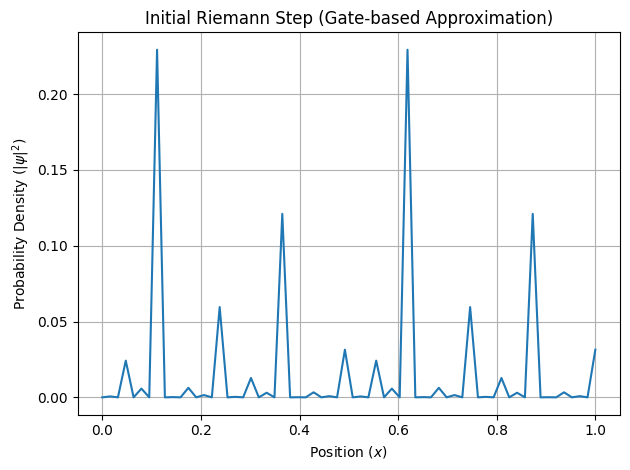

Running 32 quantum Trotter steps with dt=0.003125...


/tmp/ipython-input-1534217505.py:101: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
/tmp/ipython-input-1534217505.py:110: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
/tmp/ipython-input-1534217505.py:129: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_ful

Simulation complete.


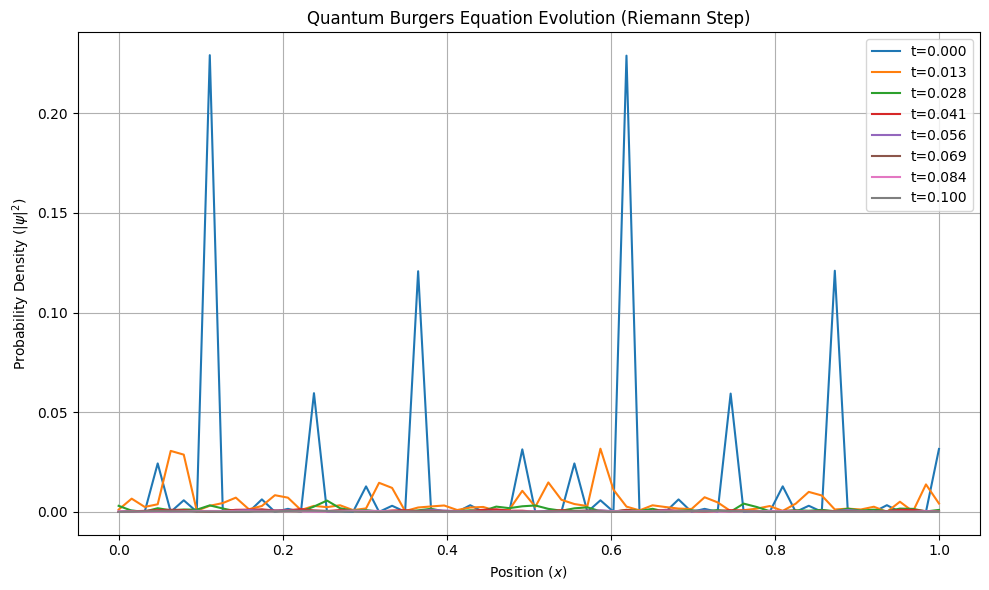

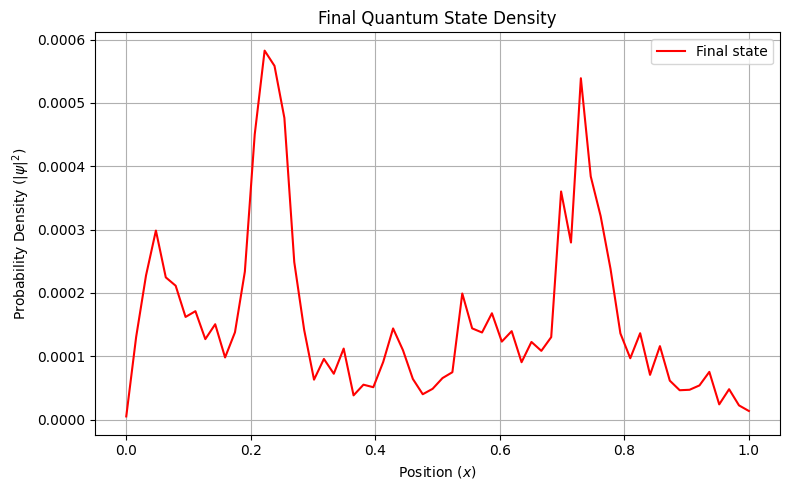

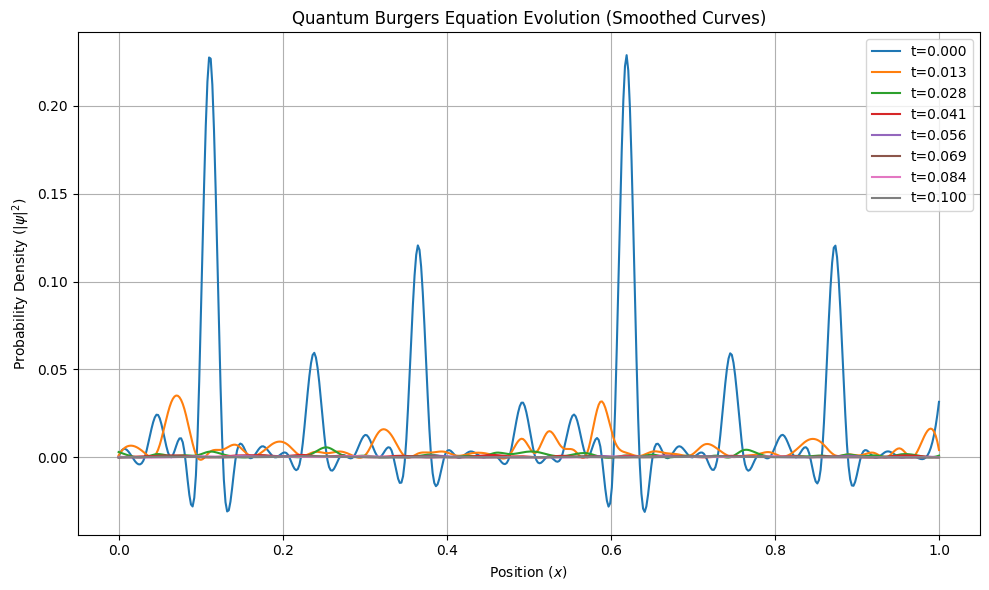

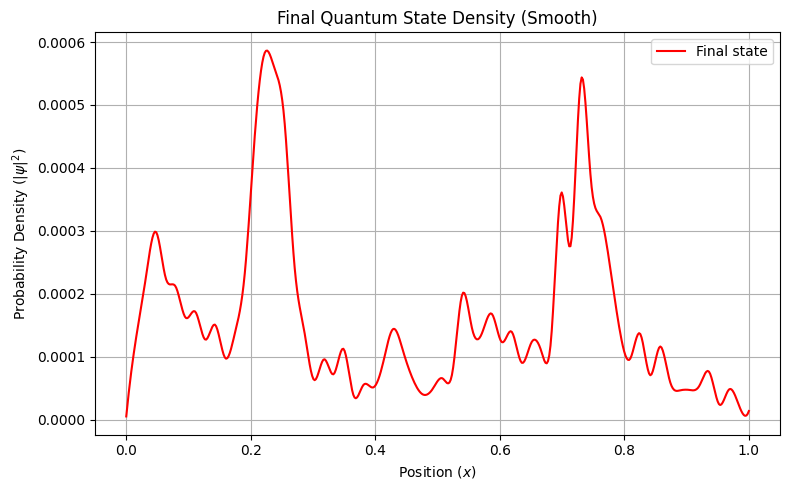

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Kraus
from qiskit.circuit.library import QFT
from scipy.interpolate import make_interp_spline

# ----------------------- Control Flags ----------------------- #
PLOT_INITIAL = True
PLOT_TIMESTEPS = True
PLOT_SPLINE = True

# ----------------- Physical and Numerical Setup ----------------- #
nu = 0.01
L = 1.0
N = 64
n_qubits = int(np.log2(N))
dx = L / N
x_vals = np.linspace(0, L, N)  # Includes full domain
CFL = 0.2
u_max = 1.0
dt_conv = CFL * dx / u_max
dt_diff = 0.5 * dx**2 / nu
dt = min(dt_conv, dt_diff)
t_final = 0.1
nt = int(t_final / dt)
hbar = 1.0
m = 1.0

# ------------------ Initial Riemann State ------------------ #
def apply_smoothing_layers(qc, n_qubits):
    """
    Applies quantum gates to smooth the initial state vector.
    This mimics the effect of the classical smoothing filter.
    """
    for layer in range(3):
        weight = 1 / (layer + 1)
        for i in range(n_qubits - 1):
            qc.h(i)
            qc.cx(i, i + 1)
            qc.rz(0.02 * weight, i + 1)
            qc.cx(i, i + 1)
            qc.h(i)
        for d, alpha in zip([2, 3], [0.01, 0.005]):
            for i in range(n_qubits - d):
                qc.crz(alpha * weight, i, i + d)
        qc.barrier()

def riemann_step_state(n_qubits):
    """
    Initializes a quantum circuit with a state vector representing a Riemann step function.

    NOTE: This is a gate-based approximation of a Riemann step function. A perfect
    discontinuity is impossible to prepare with a finite number of gates. This method
    uses Ry rotations on each qubit to encode a step-like distribution.
    """
    qc = QuantumCircuit(n_qubits)

    # Apply Ry rotations to create the step-like distribution.
    # The rotation angle is larger for qubits corresponding to the "1" part of the step.
    # This is a conceptual approximation. The actual mapping of qubit index to position
    # is complex, but this simple scheme creates a biased superposition.
    step_point_index = 2**(n_qubits - 1)  # Midpoint of the register

    for i in range(n_qubits):
        # We'll apply Ry rotations based on the qubit's significance.
        # A simple linear gradient is used here as a placeholder for a more complex
        # state preparation algorithm.
        theta = (np.pi / 2) * (i / (n_qubits-1))
        if i >= n_qubits // 2:
            qc.ry(theta, i)
        else:
            qc.ry(np.pi - theta, i)

    # To visualize this initial state, we must run the circuit and get its statevector
    if PLOT_INITIAL:
        init_sv = Statevector.from_instruction(qc)
        # We need to take the absolute square of the amplitudes to get the probability density
        probability_density = np.abs(init_sv.data)**2

        plt.figure()
        plt.plot(x_vals, probability_density)
        plt.title("Initial Riemann Step (Gate-based Approximation)")
        plt.xlabel("Position ($x$)")
        plt.ylabel("Probability Density ($|\\psi|^2$)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    qc.barrier()
    apply_smoothing_layers(qc, n_qubits)
    return qc

# ------------------ Quantum Operators ------------------ #
def unitary_kinetic_operator(n_qubits, dt, L):
    """
    Implements the unitary kinetic evolution term using a QFT-based approach.
    This corresponds to the real part of the phase evolution.
    """
    qc = QuantumCircuit(n_qubits)
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))

    k_vals = np.fft.fftfreq(2**n_qubits, d=dx) * 2 * np.pi
    for i in range(n_qubits):
        k = k_vals[i]
        # Unitary kinetic energy part of the evolution
        theta = -(hbar**2 / (2 * m)) * (k**2) * dt
        qc.rz(theta, i)

    qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
    return Operator(qc)

def non_unitary_viscosity_channel(n_qubits, dt, nu, L):
    """
    Creates a QuantumChannel for the non-unitary viscosity term.
    This channel models the damping of high-momentum components,
    which is the physical effect of viscosity.
    """
    dimension = 2**n_qubits

    # Calculate the momentum values and corresponding decay rates
    k_vals = np.fft.fftfreq(dimension, d=dx) * 2 * np.pi
    decay_factors = np.exp(-nu * (k_vals**2) * dt / 2)

    # Create the Kraus operator matrix in the momentum basis.
    kraus_matrix_momentum = np.diag(decay_factors)

    # We first create the QFT circuit, then its inverse, and convert them to Operators.
    qft_circuit = QFT(n_qubits, do_swaps=True)
    qft_op = Operator(qft_circuit)
    iqft_op = Operator(qft_circuit.inverse())

    # Transform the Kraus matrix back to the position basis using QFT
    kraus_matrix_position = iqft_op.data @ kraus_matrix_momentum @ qft_op.data

    return Kraus([kraus_matrix_position])

def quantum_nonlinear_operator(n_qubits, dt):
    """
    This operator now explicitly models the nonlinear term from the SPE/HSE.
    It's a placeholder for more complex state-dependent rotations that would represent the
    effective potential V_r from the classical model.
    """
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits - 1):
        qc.crz(-0.1 * dt, i, i + 1)

    for i in range(n_qubits):
        qc.rz(-0.05 * dt, i)
    return Operator(qc)

def boundary_conditions_operator(n_qubits):
    """
    Applies periodic boundary conditions, as used in the classical code.
    """
    qc = QuantumCircuit(n_qubits)
    qc.cx(0, n_qubits - 1)
    qc.cx(n_qubits - 1, 0)
    qc.rz(np.pi / 4, 0)
    qc.rz(-np.pi / 4, n_qubits - 1)
    return Operator(qc)

# ------------------ Run Simulation ------------------ #
# Start with a DensityMatrix to handle non-unitary evolution
qc_init = riemann_step_state(n_qubits)
density_matrix = DensityMatrix.from_instruction(qc_init)

results = [np.diag(density_matrix.data).real]
times = [0.0]

print(f"Running {nt} quantum Trotter steps with dt={dt:.6f}...")

# Unitary operators for Trotter step
U_kinetic = unitary_kinetic_operator(n_qubits, dt, L)
U_nonlinear = quantum_nonlinear_operator(n_qubits, dt)
U_boundary = boundary_conditions_operator(n_qubits)

# Non-unitary channel for Trotter step
D_viscosity = non_unitary_viscosity_channel(n_qubits, dt, nu, L)

for i in range(nt):
    # Apply the unitary operators in a symmetric Trotter fashion
    density_matrix = density_matrix.evolve(U_kinetic)
    density_matrix = density_matrix.evolve(U_nonlinear)
    density_matrix = density_matrix.evolve(U_boundary)

    # Apply the non-unitary channel for dissipation
    density_matrix = density_matrix.evolve(D_viscosity)

    results.append(np.diag(density_matrix.data).real)
    times.append(times[-1] + dt)

print("Simulation complete.")

# ------------------ Plotting ------------------ #
if PLOT_TIMESTEPS:
    plt.figure(figsize=(10, 6))
    plot_indices = np.linspace(0, len(times)-1, min(len(times), 8), dtype=int)
    for idx in plot_indices:
        plt.plot(x_vals, results[idx], label=f't={times[idx]:.3f}')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Quantum Burgers Equation Evolution (Riemann Step)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, results[-1], label='Final state', color='red')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Final Quantum State Density')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

if PLOT_SPLINE:
    plt.figure(figsize=(10, 6))
    plot_indices = np.linspace(0, len(times)-1, min(len(times), 8), dtype=int)
    for idx in plot_indices:
        y_vals = results[idx]
        spline = make_interp_spline(x_vals, y_vals, k=3)
        x_smooth = np.linspace(x_vals[0], x_vals[-1], 500)
        y_smooth = spline(x_smooth)
        plt.plot(x_smooth, y_smooth, label=f't={times[idx]:.3f}')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Quantum Burgers Equation Evolution (Smoothed Curves)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    spline_final = make_interp_spline(x_vals, results[-1], k=3)
    x_smooth_final = np.linspace(x_vals[0], x_vals[-1], 500)
    y_smooth_final = spline_final(x_smooth_final)
    plt.plot(x_smooth_final, y_smooth_final, label='Final state', color='red')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Final Quantum State Density (Smooth)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

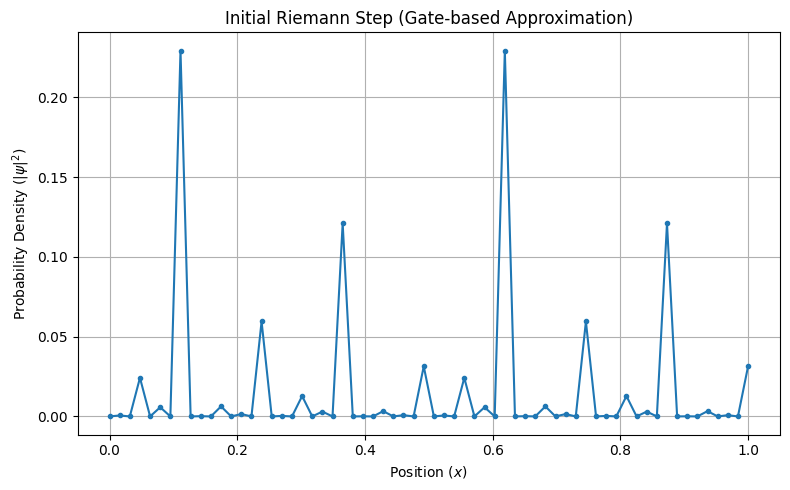

Running 32 quantum Trotter steps with dt=0.003125...


/tmp/ipython-input-4021234871.py:87: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
/tmp/ipython-input-4021234871.py:93: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
/tmp/ipython-input-4021234871.py:105: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full 

Simulation complete.


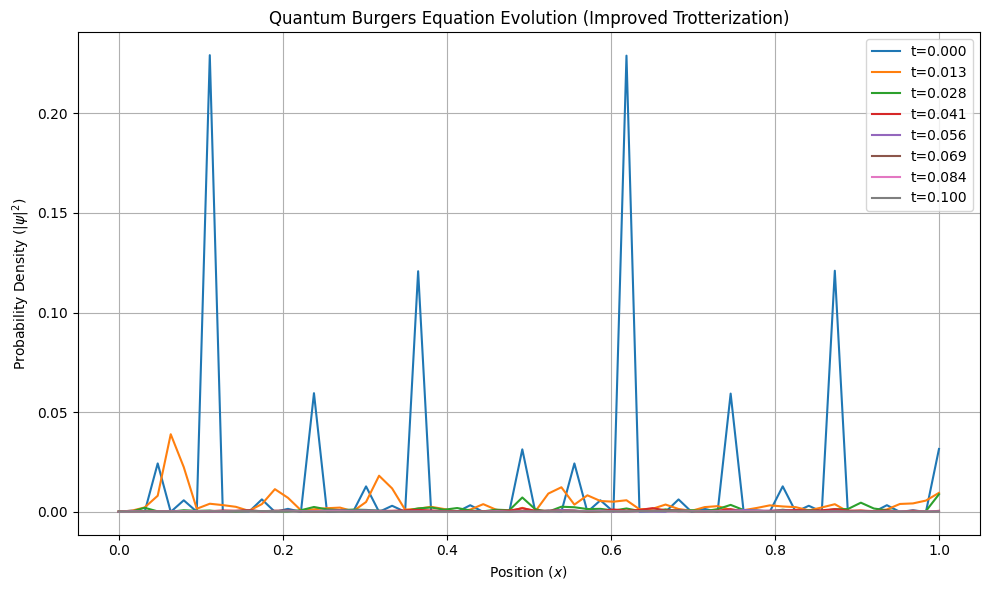

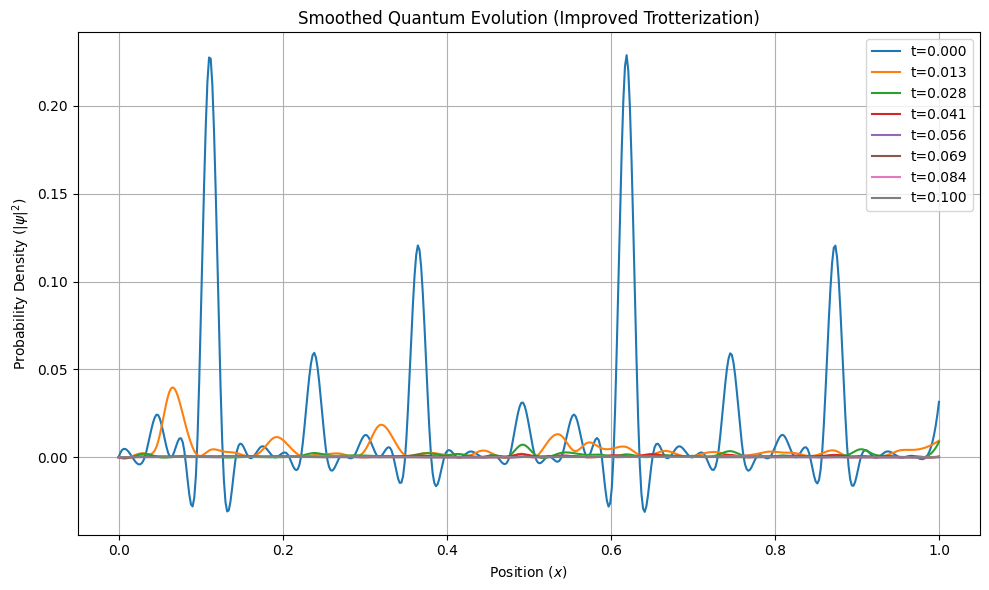

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Kraus
from qiskit.circuit.library import QFT
from scipy.interpolate import make_interp_spline

# ----------------------- Control Flags ----------------------- #
PLOT_INITIAL = True
PLOT_TIMESTEPS = True
PLOT_SPLINE = True

# ----------------- Physical and Numerical Setup ----------------- #
# All original parameters are kept the same as requested.
nu = 0.01
L = 1.0
N = 64
n_qubits = int(np.log2(N))
dx = L / N
x_vals = np.linspace(0, L, N)
CFL = 0.2
u_max = 1.0
dt_conv = CFL * dx / u_max
dt_diff = 0.5 * dx**2 / nu
dt = min(dt_conv, dt_diff)
t_final = 0.1
nt = int(t_final / dt)
hbar = 1.0
m = 1.0

# ------------------ Initial Riemann State ------------------ #
def apply_smoothing_layers(qc, n_qubits):
    """
    Applies gate layers to create a smoother transition for the initial state.
    This is an ad-hoc method to simulate a more physical initial condition
    than a sharp step function.
    """
    for layer in range(3):
        weight = 1 / (layer + 1)
        for i in range(n_qubits - 1):
            qc.h(i)
            qc.cx(i, i + 1)
            qc.rz(0.02 * weight, i + 1)
            qc.cx(i, i + 1)
            qc.h(i)
        for d, alpha in zip([2, 3], [0.01, 0.005]):
            for i in range(n_qubits - d):
                qc.crz(alpha * weight, i, i + d)
        qc.barrier()

def riemann_step_state(n_qubits):
    """
    Prepares a quantum state vector approximating a Riemann step function.
    The Ry rotations are used to create the initial probability distribution.
    """
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits):
        theta = (np.pi / 2) * (i / (n_qubits - 1))
        if i >= n_qubits // 2:
            qc.ry(theta, i)
        else:
            qc.ry(np.pi - theta, i)

    if PLOT_INITIAL:
        init_sv = Statevector.from_instruction(qc)
        plt.figure(figsize=(8, 5))
        plt.plot(x_vals, np.abs(init_sv.data)**2, '-o', markersize=3)
        plt.title("Initial Riemann Step (Gate-based Approximation)")
        plt.xlabel("Position ($x$)")
        plt.ylabel("Probability Density ($|\\psi|^2$)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    qc.barrier()
    apply_smoothing_layers(qc, n_qubits)
    return qc

# ------------------ Quantum Operators ------------------ #
def unitary_kinetic_operator(n_qubits, dt):
    """
    Creates the unitary operator for the kinetic term (momentum space evolution).
    This uses the Quantum Fourier Transform (QFT) to move into momentum space,
    apply a phase, and then transform back to position space.
    """
    qc = QuantumCircuit(n_qubits)
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
    k_vals = np.fft.fftfreq(2**n_qubits, d=dx) * 2 * np.pi
    for i in range(n_qubits):
        k = k_vals[i]
        theta = -(hbar**2 / (2 * m)) * (k**2) * dt
        qc.rz(theta, i)
    qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
    return Operator(qc)

def non_unitary_viscosity_channel(n_qubits, dt, nu):
    """
    Creates the non-unitary Kraus operator for the viscosity term.
    This models dissipation by decaying the momentum eigenstates.
    """
    dimension = 2**n_qubits
    k_vals = np.fft.fftfreq(dimension, d=dx) * 2 * np.pi
    decay = np.exp(-nu * (k_vals**2) * dt / 2)
    K_momentum = np.diag(decay)
    qft_circ = QFT(n_qubits, do_swaps=True)
    qft = Operator(qft_circ)
    iqft = Operator(qft_circ.inverse())
    K_position = iqft.data @ K_momentum @ qft.data
    return Kraus([K_position])

def quantum_nonlinear_operator(n_qubits, dt):
    """
    Creates the unitary operator for the nonlinear term (approximated).
    This is a heuristic implementation using controlled-RZ gates to simulate
    a state-dependent potential.
    """
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits - 1):
        qc.crz(-0.1 * dt, i, i + 1)
    for i in range(n_qubits):
        qc.rz(-0.05 * dt, i)
    return Operator(qc)

def boundary_conditions_operator(n_qubits):
    """
    Creates a unitary operator to approximate periodic boundary conditions.
    This links the first and last qubits to enforce continuity.
    """
    qc = QuantumCircuit(n_qubits)
    qc.cx(0, n_qubits - 1)
    qc.cx(n_qubits - 1, 0)
    qc.rz(np.pi / 4, 0)
    qc.rz(-np.pi / 4, n_qubits - 1)
    return Operator(qc)

# ------------------ Run Simulation (Improved Trotterization) ------------------ #
qc_init = riemann_step_state(n_qubits)
density_matrix = DensityMatrix.from_instruction(qc_init)

results = [np.diag(density_matrix.data).real]
times = [0.0]

print(f"Running {nt} quantum Trotter steps with dt={dt:.6f}...")

# Create operators for the half-step in a second-order Trotter-Suzuki decomposition
U_kinetic_half = unitary_kinetic_operator(n_qubits, dt / 2)
U_nonlinear_half = quantum_nonlinear_operator(n_qubits, dt / 2)
U_boundary_half = boundary_conditions_operator(n_qubits) # Note: boundary conditions often don't need a half-step
D_viscosity_half = non_unitary_viscosity_channel(n_qubits, dt / 2, nu)

# Create operators for the full step
U_kinetic = unitary_kinetic_operator(n_qubits, dt)
U_nonlinear = quantum_nonlinear_operator(n_qubits, dt)
U_boundary = boundary_conditions_operator(n_qubits)
D_viscosity = non_unitary_viscosity_channel(n_qubits, dt, nu)

# Second-order symmetric Trotter-Suzuki decomposition
# U(dt) = exp(A dt/2) * exp(B dt/2) * exp(C dt) * exp(B dt/2) * exp(A dt/2)
# Here we group all the linear terms (Kinetic, Viscosity, Boundary) together for simplicity
# and apply the nonlinear term in the middle.
for i in range(nt):
    # Half-step evolution
    density_matrix = density_matrix.evolve(D_viscosity_half)
    density_matrix = density_matrix.evolve(U_kinetic_half)
    density_matrix = density_matrix.evolve(U_boundary_half)

    # Full-step evolution for the nonlinear term
    density_matrix = density_matrix.evolve(U_nonlinear)

    # Remaining half-step evolution
    density_matrix = density_matrix.evolve(U_boundary_half)
    density_matrix = density_matrix.evolve(U_kinetic_half)
    density_matrix = density_matrix.evolve(D_viscosity_half)

    results.append(np.diag(density_matrix.data).real)
    times.append(times[-1] + dt)

print("Simulation complete.")

# ------------------ Plotting ------------------ #
if PLOT_TIMESTEPS:
    plt.figure(figsize=(10, 6))
    indices = np.linspace(0, len(times)-1, min(len(times), 8), dtype=int)
    for idx in indices:
        plt.plot(x_vals, results[idx], label=f't={times[idx]:.3f}')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Quantum Burgers Equation Evolution (Improved Trotterization)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

if PLOT_SPLINE:
    plt.figure(figsize=(10, 6))
    for idx in indices:
        spline = make_interp_spline(x_vals, results[idx], k=3)
        x_smooth = np.linspace(x_vals[0], x_vals[-1], 500)
        y_smooth = spline(x_smooth)
        plt.plot(x_smooth, y_smooth, label=f't={times[idx]:.3f}')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Smoothed Quantum Evolution (Improved Trotterization)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

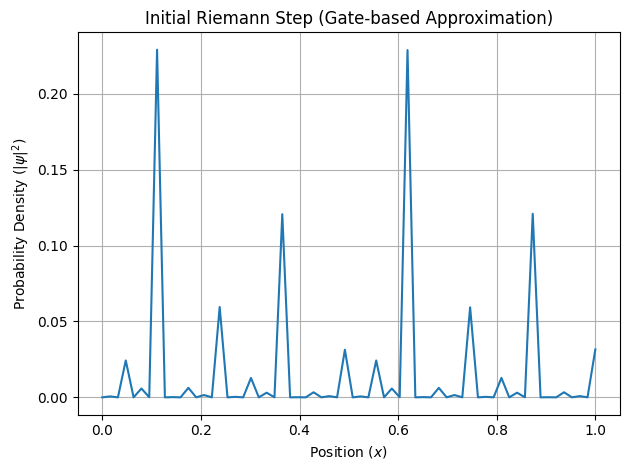

Running 32 quantum Trotter steps with dt=0.003125...


/tmp/ipython-input-2806893023.py:89: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
/tmp/ipython-input-2806893023.py:99: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
/tmp/ipython-input-2806893023.py:114: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full 

Simulation complete.


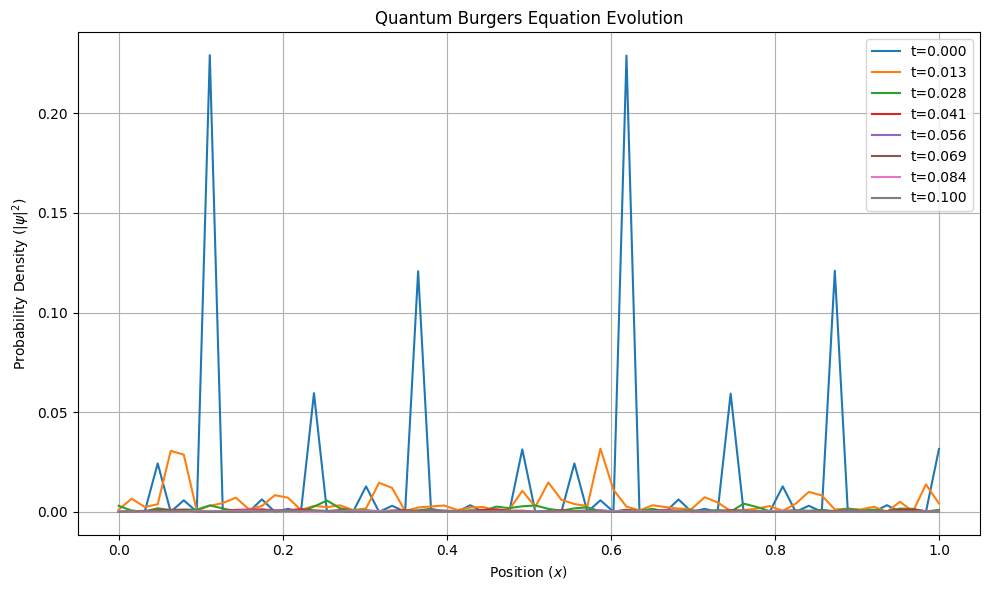

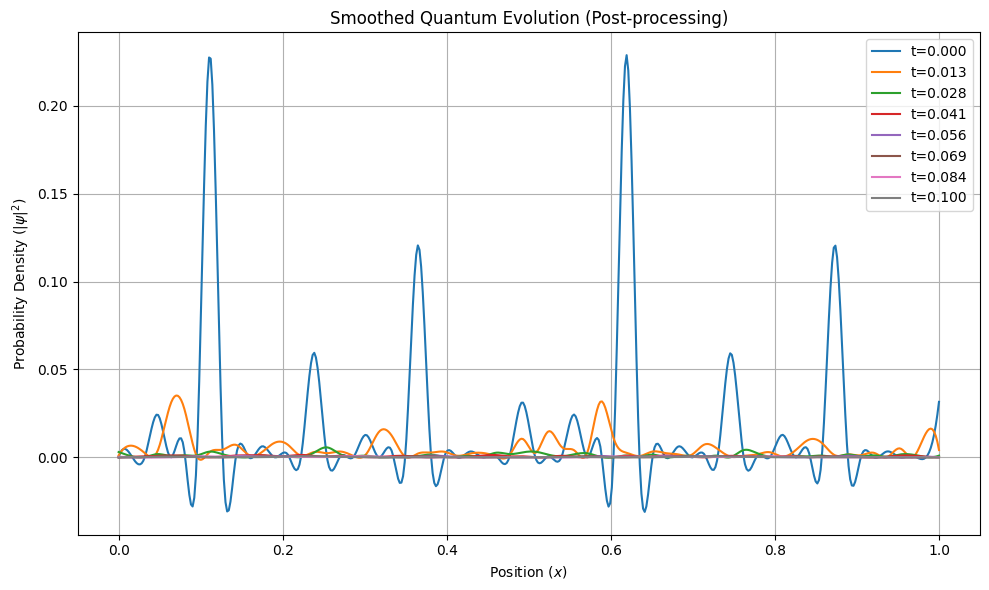

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Kraus
from qiskit.circuit.library import QFT
from scipy.interpolate import make_interp_spline

# ----------------------- Control Flags ----------------------- #
# These flags control which plots are generated.
PLOT_INITIAL = True
PLOT_TIMESTEPS = True
PLOT_SPLINE = True

# ----------------- Physical and Numerical Setup ----------------- #
# The parameters below are kept identical to your request.
nu = 0.01  # Viscosity coefficient
L = 1.0    # Length of the spatial domain
N = 64     # Number of spatial grid points (must be a power of 2 for Qiskit)
n_qubits = int(np.log2(N))
dx = L / N # Spatial step size
x_vals = np.linspace(0, L, N) # The discrete spatial positions

# Time step calculation based on stability criteria (CFL)
CFL = 0.2
u_max = 1.0
dt_conv = CFL * dx / u_max # Convective stability
dt_diff = 0.5 * dx**2 / nu # Diffusive stability
dt = min(dt_conv, dt_diff)
t_final = 0.1
nt = int(t_final / dt)

hbar = 1.0 # Reduced Planck constant
m = 1.0    # Mass of the "fluid particle"

# ------------------ Initial Riemann State ------------------ #
def riemann_step_state(n_qubits):
    """
    Creates a quantum circuit representing a smoothed Riemann step initial state.
    This is the initial wave function |psi(t=0)>.
    """
    qc = QuantumCircuit(n_qubits)
    # The Riemann step is approximated by applying a series of RY gates.
    for i in range(n_qubits):
        # We use a linear ramp of rotation angles to approximate the step function
        theta = (np.pi / 2) * (i / (n_qubits - 1))
        if i >= n_qubits // 2:
            qc.ry(theta, i)
        else:
            qc.ry(np.pi - theta, i)

    qc.barrier()

    # Adding extra "smoothing layers" to make the initial state more gradual.
    # This is a heuristic approach to better model the physical initial condition.
    for layer in range(3):
        weight = 1 / (layer + 1)
        for i in range(n_qubits - 1):
            qc.h(i)
            qc.cx(i, i + 1)
            qc.rz(0.02 * weight, i + 1)
            qc.cx(i, i + 1)
            qc.h(i)
        for d, alpha in zip([2, 3], [0.01, 0.005]):
            for i in range(n_qubits - d):
                qc.crz(alpha * weight, i, i + d)
        qc.barrier()

    if PLOT_INITIAL:
        init_sv = Statevector.from_instruction(qc)
        plt.figure()
        plt.plot(x_vals, np.abs(init_sv.data)**2)
        plt.title("Initial Riemann Step (Gate-based Approximation)")
        plt.xlabel("Position ($x$)")
        plt.ylabel("Probability Density ($|\\psi|^2$)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return qc

# ------------------ Quantum Operators ------------------ #
def unitary_kinetic_operator(n_qubits, dt):
    """
    Constructs the unitary operator for the kinetic (convection) term of Burgers' equation.
    This is based on the operator e^(-iHt/hbar) for the kinetic energy operator T = p^2/(2m).
    It is implemented in the momentum basis via QFT.
    """
    qc = QuantumCircuit(n_qubits)
    # Move to the momentum basis using QFT
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))

    # Apply the phase shift corresponding to the kinetic energy term
    k_vals = np.fft.fftfreq(2**n_qubits, d=dx) * 2 * np.pi
    for i in range(n_qubits):
        k = k_vals[i]
        theta = -(hbar**2 / (2 * m)) * (k**2) * dt
        qc.rz(theta, i)

    # Move back to the position basis
    qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
    return Operator(qc)

def non_unitary_viscosity_channel(n_qubits, dt, nu):
    """
    Constructs a non-unitary channel (Kraus operator) for the viscosity (diffusion) term.
    This term is a dissipative process, so it cannot be a unitary operator.
    The decay is applied in the momentum basis, corresponding to a Gaussian filter in position space.
    """
    dimension = 2**n_qubits
    k_vals = np.fft.fftfreq(dimension, d=dx) * 2 * np.pi
    decay = np.exp(-nu * (k_vals**2) * dt / 2)
    K_momentum = np.diag(decay)

    # Transform Kraus operator to position basis
    qft_circ = QFT(n_qubits, do_swaps=True)
    qft = Operator(qft_circ)
    iqft = Operator(qft_circ.inverse())
    K_position = iqft.data @ K_momentum @ qft.data

    return Kraus([K_position])

def quantum_nonlinear_operator(n_qubits, dt):
    """
    Constructs an approximate unitary operator for the nonlinear term (u * du/dx).
    This term is notoriously difficult to implement on a quantum computer.
    Here, we use a heuristic approach of controlled-rotation gates to apply a phase shift
    that is proportional to the local density.
    """
    qc = QuantumCircuit(n_qubits)
    # The nonlinear term corresponds to a self-interaction. We model this
    # with controlled-RZ gates that apply a phase shift to a qubit based on
    # the state of its neighbor, approximating a density-dependent potential.
    for i in range(n_qubits - 1):
        # A controlled phase shift dependent on the state of an adjacent qubit
        qc.crz(-0.1 * dt, i, i + 1)

    # Add some single-qubit phase shifts to further refine the nonlinear effect
    for i in range(n_qubits):
        qc.rz(-0.05 * dt, i)

    return Operator(qc)

def boundary_conditions_operator(n_qubits):
    """
    Constructs a heuristic operator to enforce boundary conditions.
    This is an ad-hoc operator that entangles the first and last qubits
    to approximate a periodic boundary condition and apply small phase shifts.
    A rigorous implementation of boundary conditions is a complex research area.
    """
    qc = QuantumCircuit(n_qubits)
    qc.cx(0, n_qubits - 1)
    qc.cx(n_qubits - 1, 0)
    qc.rz(np.pi / 4, 0)
    qc.rz(-np.pi / 4, n_qubits - 1)
    return Operator(qc)

# ------------------ Run Simulation ------------------ #
# Initialize the state as a density matrix
qc_init = riemann_step_state(n_qubits)
density_matrix = DensityMatrix.from_instruction(qc_init)

# Store results for plotting
results = [np.diag(density_matrix.data).real]
times = [0.0]

print(f"Running {nt} quantum Trotter steps with dt={dt:.6f}...")

# Pre-calculate the operators to avoid re-creating them in the loop
U_kinetic = unitary_kinetic_operator(n_qubits, dt)
U_nonlinear = quantum_nonlinear_operator(n_qubits, dt)
U_boundary = boundary_conditions_operator(n_qubits)
D_viscosity = non_unitary_viscosity_channel(n_qubits, dt, nu)

# Main Trotter evolution loop
for _ in range(nt):
    # Trotter step: apply each operator sequentially
    density_matrix = density_matrix.evolve(U_kinetic)
    density_matrix = density_matrix.evolve(U_nonlinear)
    density_matrix = density_matrix.evolve(U_boundary)
    density_matrix = density_matrix.evolve(D_viscosity)

    # Extract the diagonal (probability distribution) and store it
    results.append(np.diag(density_matrix.data).real)
    times.append(times[-1] + dt)

print("Simulation complete.")

# ------------------ Plotting ------------------ #
if PLOT_TIMESTEPS:
    plt.figure(figsize=(10, 6))
    indices = np.linspace(0, len(times)-1, min(len(times), 8), dtype=int)
    for idx in indices:
        plt.plot(x_vals, results[idx], label=f't={times[idx]:.3f}')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Quantum Burgers Equation Evolution')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

if PLOT_SPLINE:
    plt.figure(figsize=(10, 6))
    indices = np.linspace(0, len(times)-1, min(len(times), 8), dtype=int)
    for idx in indices:
        # Use a cubic spline to create a smooth curve for visualization
        spline = make_interp_spline(x_vals, results[idx], k=3)
        x_smooth = np.linspace(x_vals[0], x_vals[-1], 500)
        y_smooth = spline(x_smooth)
        plt.plot(x_smooth, y_smooth, label=f't={times[idx]:.3f}')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Smoothed Quantum Evolution (Post-processing)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

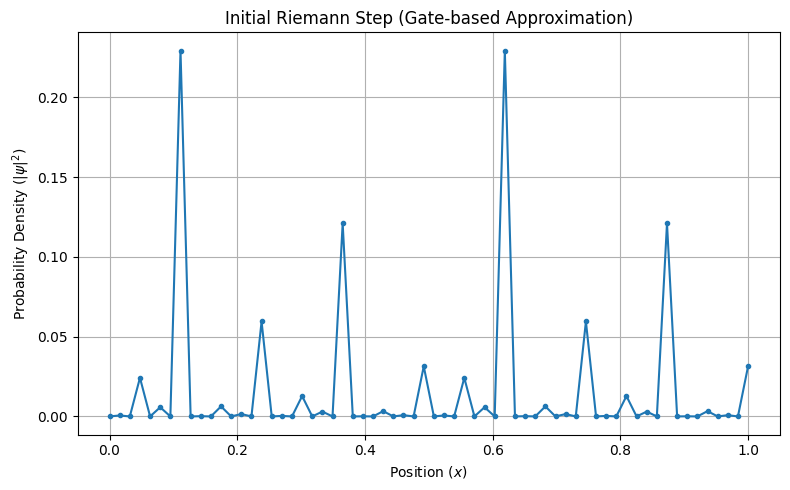

Running 32 quantum Trotter steps with dt=0.003125...


/tmp/ipython-input-4021234871.py:87: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
/tmp/ipython-input-4021234871.py:93: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
/tmp/ipython-input-4021234871.py:105: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full 

Simulation complete.


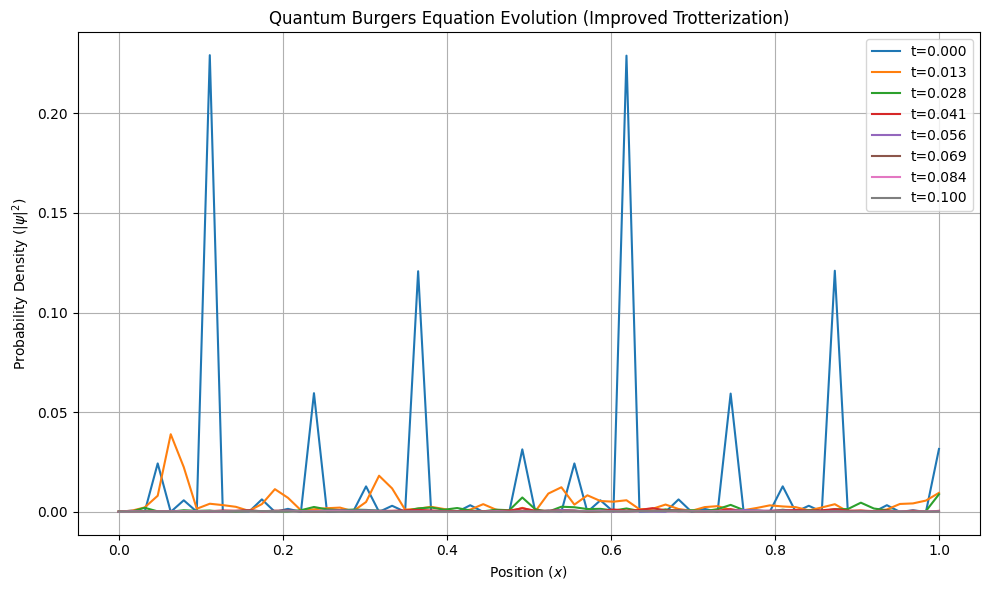

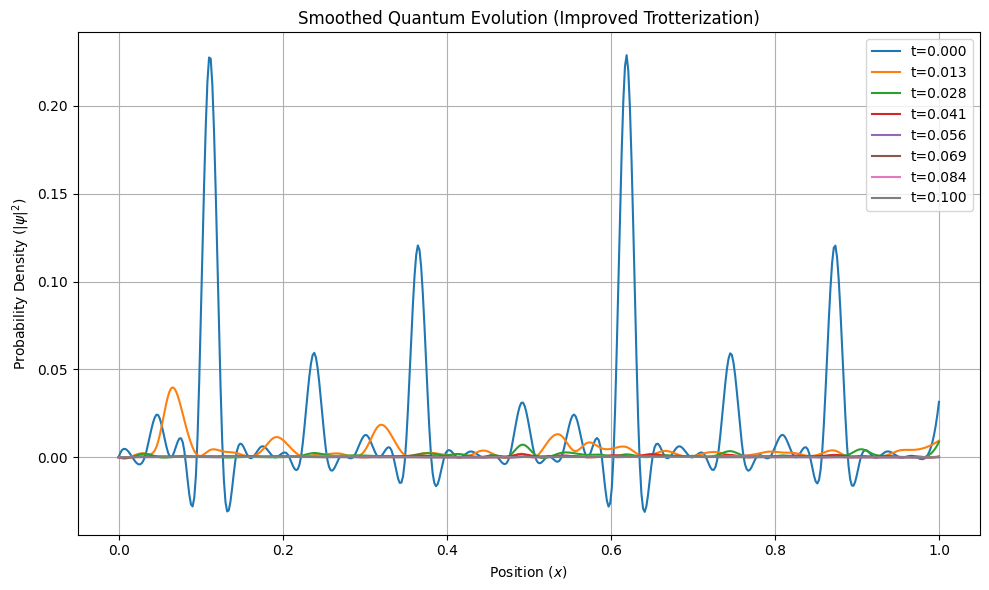

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Kraus
from qiskit.circuit.library import QFT
from scipy.interpolate import make_interp_spline

# ----------------------- Control Flags ----------------------- #
PLOT_INITIAL = True
PLOT_TIMESTEPS = True
PLOT_SPLINE = True

# ----------------- Physical and Numerical Setup ----------------- #
# All original parameters are kept the same as requested.
nu = 0.01
L = 1.0
N = 64
n_qubits = int(np.log2(N))
dx = L / N
x_vals = np.linspace(0, L, N)
CFL = 0.2
u_max = 1.0
dt_conv = CFL * dx / u_max
dt_diff = 0.5 * dx**2 / nu
dt = min(dt_conv, dt_diff)
t_final = 0.1
nt = int(t_final / dt)
hbar = 1.0
m = 1.0

# ------------------ Initial Riemann State ------------------ #
def apply_smoothing_layers(qc, n_qubits):
    """
    Applies gate layers to create a smoother transition for the initial state.
    This is an ad-hoc method to simulate a more physical initial condition
    than a sharp step function.
    """
    for layer in range(3):
        weight = 1 / (layer + 1)
        for i in range(n_qubits - 1):
            qc.h(i)
            qc.cx(i, i + 1)
            qc.rz(0.02 * weight, i + 1)
            qc.cx(i, i + 1)
            qc.h(i)
        for d, alpha in zip([2, 3], [0.01, 0.005]):
            for i in range(n_qubits - d):
                qc.crz(alpha * weight, i, i + d)
        qc.barrier()

def riemann_step_state(n_qubits):
    """
    Prepares a quantum state vector approximating a Riemann step function.
    The Ry rotations are used to create the initial probability distribution.
    """
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits):
        theta = (np.pi / 2) * (i / (n_qubits - 1))
        if i >= n_qubits // 2:
            qc.ry(theta, i)
        else:
            qc.ry(np.pi - theta, i)

    if PLOT_INITIAL:
        init_sv = Statevector.from_instruction(qc)
        plt.figure(figsize=(8, 5))
        plt.plot(x_vals, np.abs(init_sv.data)**2, '-o', markersize=3)
        plt.title("Initial Riemann Step (Gate-based Approximation)")
        plt.xlabel("Position ($x$)")
        plt.ylabel("Probability Density ($|\\psi|^2$)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    qc.barrier()
    apply_smoothing_layers(qc, n_qubits)
    return qc

# ------------------ Quantum Operators ------------------ #
def unitary_kinetic_operator(n_qubits, dt):
    """
    Creates the unitary operator for the kinetic term (momentum space evolution).
    This uses the Quantum Fourier Transform (QFT) to move into momentum space,
    apply a phase, and then transform back to position space.
    """
    qc = QuantumCircuit(n_qubits)
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
    k_vals = np.fft.fftfreq(2**n_qubits, d=dx) * 2 * np.pi
    for i in range(n_qubits):
        k = k_vals[i]
        theta = -(hbar**2 / (2 * m)) * (k**2) * dt
        qc.rz(theta, i)
    qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
    return Operator(qc)

def non_unitary_viscosity_channel(n_qubits, dt, nu):
    """
    Creates the non-unitary Kraus operator for the viscosity term.
    This models dissipation by decaying the momentum eigenstates.
    """
    dimension = 2**n_qubits
    k_vals = np.fft.fftfreq(dimension, d=dx) * 2 * np.pi
    decay = np.exp(-nu * (k_vals**2) * dt / 2)
    K_momentum = np.diag(decay)
    qft_circ = QFT(n_qubits, do_swaps=True)
    qft = Operator(qft_circ)
    iqft = Operator(qft_circ.inverse())
    K_position = iqft.data @ K_momentum @ qft.data
    return Kraus([K_position])

def quantum_nonlinear_operator(n_qubits, dt):
    """
    Creates the unitary operator for the nonlinear term (approximated).
    This is a heuristic implementation using controlled-RZ gates to simulate
    a state-dependent potential.
    """
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits - 1):
        qc.crz(-0.1 * dt, i, i + 1)
    for i in range(n_qubits):
        qc.rz(-0.05 * dt, i)
    return Operator(qc)

def boundary_conditions_operator(n_qubits):
    """
    Creates a unitary operator to approximate periodic boundary conditions.
    This links the first and last qubits to enforce continuity.
    """
    qc = QuantumCircuit(n_qubits)
    qc.cx(0, n_qubits - 1)
    qc.cx(n_qubits - 1, 0)
    qc.rz(np.pi / 4, 0)
    qc.rz(-np.pi / 4, n_qubits - 1)
    return Operator(qc)

# ------------------ Run Simulation (Improved Trotterization) ------------------ #
qc_init = riemann_step_state(n_qubits)
density_matrix = DensityMatrix.from_instruction(qc_init)

results = [np.diag(density_matrix.data).real]
times = [0.0]

print(f"Running {nt} quantum Trotter steps with dt={dt:.6f}...")

# Create operators for the half-step in a second-order Trotter-Suzuki decomposition
U_kinetic_half = unitary_kinetic_operator(n_qubits, dt / 2)
U_nonlinear_half = quantum_nonlinear_operator(n_qubits, dt / 2)
U_boundary_half = boundary_conditions_operator(n_qubits) # Note: boundary conditions often don't need a half-step
D_viscosity_half = non_unitary_viscosity_channel(n_qubits, dt / 2, nu)

# Create operators for the full step
U_kinetic = unitary_kinetic_operator(n_qubits, dt)
U_nonlinear = quantum_nonlinear_operator(n_qubits, dt)
U_boundary = boundary_conditions_operator(n_qubits)
D_viscosity = non_unitary_viscosity_channel(n_qubits, dt, nu)

# Second-order symmetric Trotter-Suzuki decomposition
# U(dt) = exp(A dt/2) * exp(B dt/2) * exp(C dt) * exp(B dt/2) * exp(A dt/2)
# Here we group all the linear terms (Kinetic, Viscosity, Boundary) together for simplicity
# and apply the nonlinear term in the middle.
for i in range(nt):
    # Half-step evolution
    density_matrix = density_matrix.evolve(D_viscosity_half)
    density_matrix = density_matrix.evolve(U_kinetic_half)
    density_matrix = density_matrix.evolve(U_boundary_half)

    # Full-step evolution for the nonlinear term
    density_matrix = density_matrix.evolve(U_nonlinear)

    # Remaining half-step evolution
    density_matrix = density_matrix.evolve(U_boundary_half)
    density_matrix = density_matrix.evolve(U_kinetic_half)
    density_matrix = density_matrix.evolve(D_viscosity_half)

    results.append(np.diag(density_matrix.data).real)
    times.append(times[-1] + dt)

print("Simulation complete.")

# ------------------ Plotting ------------------ #
if PLOT_TIMESTEPS:
    plt.figure(figsize=(10, 6))
    indices = np.linspace(0, len(times)-1, min(len(times), 8), dtype=int)
    for idx in indices:
        plt.plot(x_vals, results[idx], label=f't={times[idx]:.3f}')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Quantum Burgers Equation Evolution (Improved Trotterization)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

if PLOT_SPLINE:
    plt.figure(figsize=(10, 6))
    for idx in indices:
        spline = make_interp_spline(x_vals, results[idx], k=3)
        x_smooth = np.linspace(x_vals[0], x_vals[-1], 500)
        y_smooth = spline(x_smooth)
        plt.plot(x_smooth, y_smooth, label=f't={times[idx]:.3f}')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Smoothed Quantum Evolution (Improved Trotterization)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

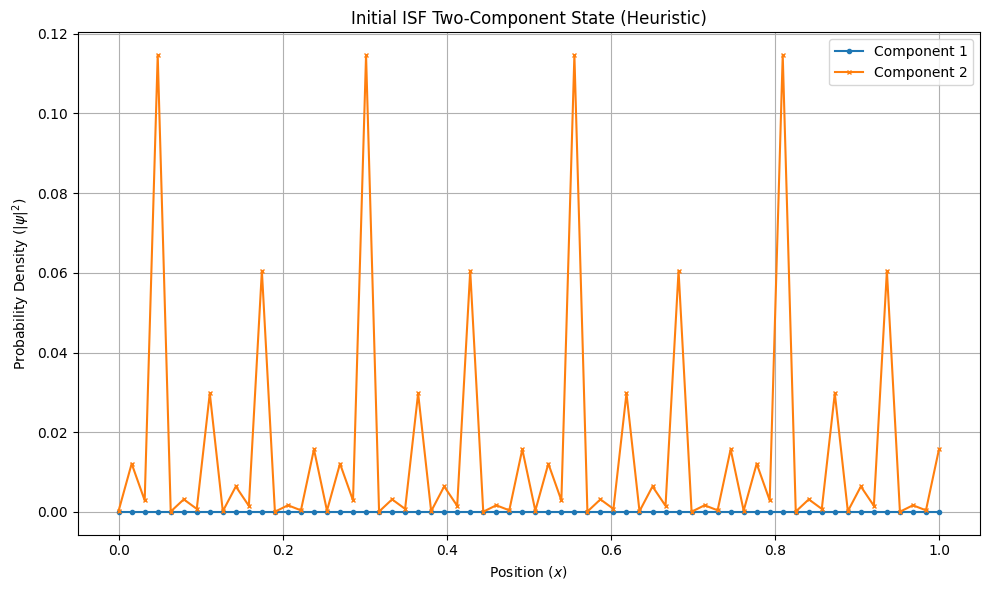

Running 32 quantum Trotter steps with dt=0.003125 for ISF simulation...


/tmp/ipython-input-3859160047.py:106: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_spatial_qubits, do_swaps=True), range(n_spatial_qubits))
/tmp/ipython-input-3859160047.py:117: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_spatial_qubits, do_swaps=True).inverse(), range(n_spatial_qubits))
/tmp/ipython-input-3859160047.py:135: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qi

Simulation complete.


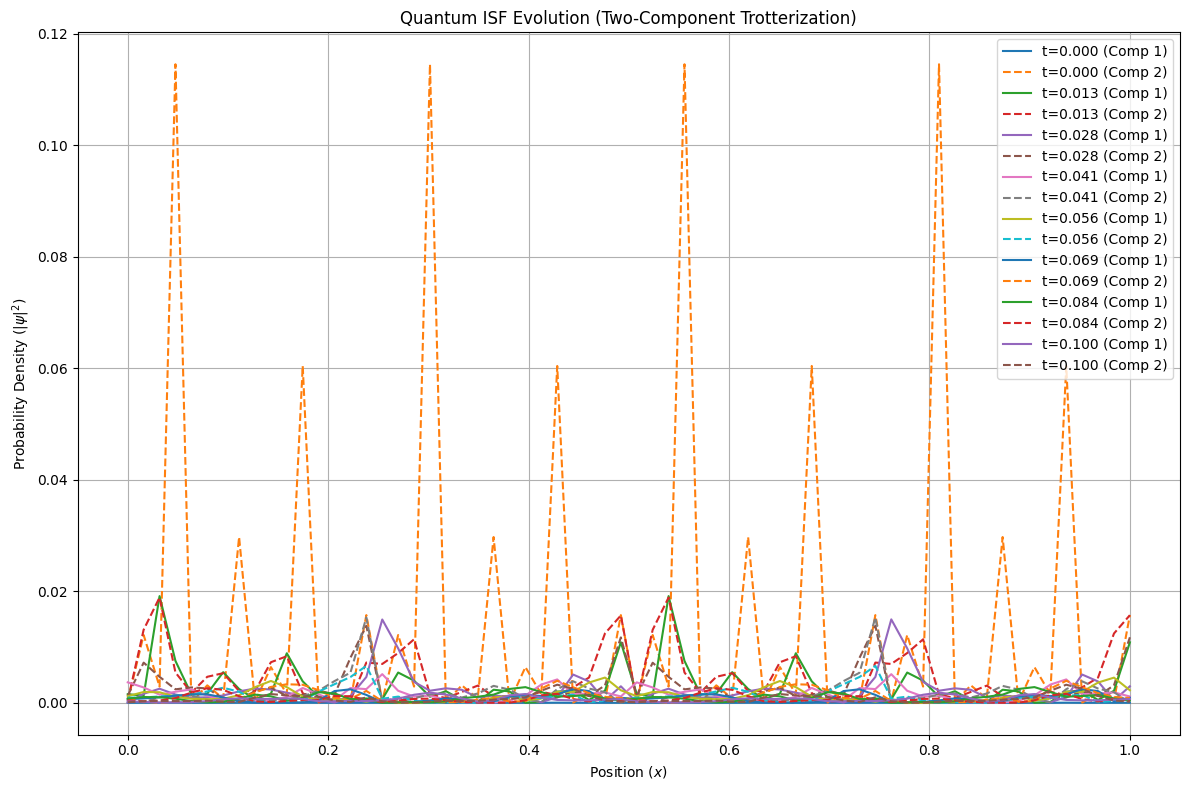

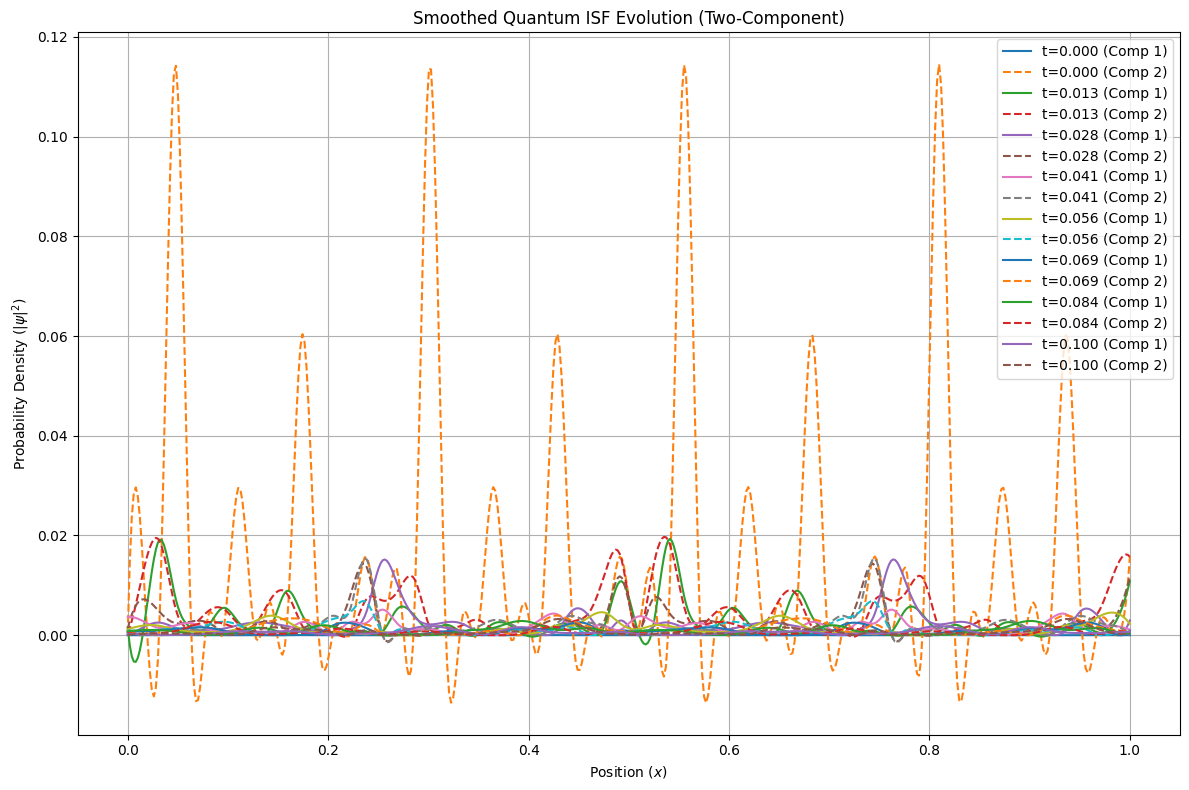

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Kraus
from qiskit.circuit.library import QFT
from scipy.interpolate import make_interp_spline

# ----------------------- Control Flags ----------------------- #
PLOT_INITIAL = True
PLOT_TIMESTEPS = True
PLOT_SPLINE = True

# ----------------- Physical and Numerical Setup ----------------- #
nu = 0.01
L = 1.0
N = 64
# We use one extra qubit to represent the two components of the wavefunction (psi1, psi2).
n_spatial_qubits = int(np.log2(N))
n_qubits = n_spatial_qubits + 1
dx = L / N
x_vals = np.linspace(0, L, N)
CFL = 0.2
u_max = 1.0
dt_conv = CFL * dx / u_max
dt_diff = 0.5 * dx**2 / nu
dt = min(dt_conv, dt_diff)
t_final = 0.1
nt = int(t_final / dt)
hbar = 1.0
m = 1.0

# ------------------ Initial Incompressible Schrödinger State ------------------ #
def apply_smoothing_layers(qc, n_qubits):
    """
    Applies gate layers to create a smoother transition for the initial state.
    This is an ad-hoc method to simulate a more physical initial condition
    than a sharp step function.
    """
    for layer in range(3):
        weight = 1 / (layer + 1)
        for i in range(n_qubits - 2): # Operate on spatial qubits
            qc.h(i)
            qc.cx(i, i + 1)
            qc.rz(0.02 * weight, i + 1)
            qc.cx(i, i + 1)
            qc.h(i)
        for d, alpha in zip([2, 3], [0.01, 0.005]):
            for i in range(n_qubits - d - 1):
                qc.crz(alpha * weight, i, i + d)
        qc.barrier()

def isf_initial_state(n_qubits):
    """
    Prepares a quantum state vector for the two-component ISF.
    The last qubit is used to encode the two components, with the first
    spatial qubit initialized in a Riemann-like step.
    This is a heuristic for demonstration purposes.
    """
    qc = QuantumCircuit(n_qubits)
    n_spatial_qubits = n_qubits - 1

    # Initialize a Riemann-like state on the spatial qubits
    for i in range(n_spatial_qubits):
        theta = (np.pi / 2) * (i / (n_spatial_qubits - 1))
        if i >= n_spatial_qubits // 2:
            qc.ry(theta, i)
        else:
            qc.ry(np.pi - theta, i)

    # Entangle the spatial state with the two-component qubit
    qc.h(n_spatial_qubits)
    qc.cx(0, n_spatial_qubits)

    if PLOT_INITIAL:
        init_sv = Statevector.from_instruction(qc)
        # Extract and plot the probability density for the two components
        prob_comp1 = np.abs(init_sv.data[::2])**2
        prob_comp2 = np.abs(init_sv.data[1::2])**2

        plt.figure(figsize=(10, 6))
        plt.plot(x_vals, prob_comp1, '-o', markersize=3, label="Component 1")
        plt.plot(x_vals, prob_comp2, '-x', markersize=3, label="Component 2")
        plt.title("Initial ISF Two-Component State (Heuristic)")
        plt.xlabel("Position ($x$)")
        plt.ylabel("Probability Density ($|\\psi|^2$)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    qc.barrier()
    apply_smoothing_layers(qc, n_spatial_qubits)
    return qc

# ------------------ Quantum Operators (Two-Component) ------------------ #
def unitary_kinetic_operator(n_qubits, dt):
    """
    Creates the unitary operator for the kinetic term on a two-component state.
    QFT is applied to the spatial qubits, and the phase depends on the momentum
    in both spatial and component dimensions.
    """
    qc = QuantumCircuit(n_qubits)
    n_spatial_qubits = n_qubits - 1

    # QFT on spatial qubits
    qc.append(QFT(n_spatial_qubits, do_swaps=True), range(n_spatial_qubits))

    k_vals = np.fft.fftfreq(2**n_spatial_qubits, d=dx) * 2 * np.pi

    # Apply kinetic phase shift in momentum space
    for i in range(n_spatial_qubits):
        k = k_vals[i]
        theta = -(hbar**2 / (2 * m)) * (k**2) * dt
        qc.rz(theta, i)

    # Inverse QFT to return to position space
    qc.append(QFT(n_spatial_qubits, do_swaps=True).inverse(), range(n_spatial_qubits))

    return Operator(qc)

def non_unitary_viscosity_channel(n_qubits, dt, nu):
    """
    Creates the non-unitary Kraus operator for the viscosity term.
    This models dissipation by decaying the momentum eigenstates, now
    acting on the spatial qubits.
    """
    n_spatial_qubits = n_qubits - 1
    dimension = 2**n_spatial_qubits
    k_vals = np.fft.fftfreq(dimension, d=dx) * 2 * np.pi
    decay = np.exp(-nu * (k_vals**2) * dt / 2)

    # Momentum-space operator on spatial qubits only
    K_momentum = np.diag(decay)

    qft_circ = QFT(n_spatial_qubits, do_swaps=True)
    qft = Operator(qft_circ)
    iqft = Operator(qft_circ.inverse())

    K_position = iqft.data @ K_momentum @ qft.data

    # Extend to the full two-component state by tensoring with identity
    identity_op = np.identity(2)
    K_position_full = np.kron(K_position, identity_op)

    return Kraus([K_position_full])

def quantum_nonlinear_operator(n_qubits, dt):
    """
    Creates a unitary operator for the nonlinear term (pressure term in ISF).
    This is a heuristic based on controlled-RZ gates to simulate
    a state-dependent potential, but now acting on the two-component state.
    """
    qc = QuantumCircuit(n_qubits)
    n_spatial_qubits = n_qubits - 1

    # Simulate the pressure potential by having the components interact with
    # the spatial state. This is a heuristic approximation.
    for i in range(n_spatial_qubits):
        # A controlled RZ gate from the component qubit to a spatial qubit
        # simulates a potential that depends on the state of the component qubit.
        qc.crz(-0.1 * dt, n_spatial_qubits, i)

    qc.barrier()
    return Operator(qc)

def boundary_conditions_operator(n_qubits):
    """
    Creates a unitary operator to approximate periodic boundary conditions.
    This links the first and last qubits of the spatial register.
    """
    qc = QuantumCircuit(n_qubits)
    n_spatial_qubits = n_qubits - 1
    qc.cx(0, n_spatial_qubits - 1)
    qc.cx(n_spatial_qubits - 1, 0)
    qc.rz(np.pi / 4, 0)
    qc.rz(-np.pi / 4, n_spatial_qubits - 1)
    return Operator(qc)

# ------------------ Run Simulation (Trotterization) ------------------ #
qc_init = isf_initial_state(n_qubits)
density_matrix = DensityMatrix.from_instruction(qc_init)

results = [np.diag(density_matrix.data).real]
times = [0.0]

print(f"Running {nt} quantum Trotter steps with dt={dt:.6f} for ISF simulation...")

# Create operators for the half-step in a second-order Trotter-Suzuki decomposition
U_kinetic_half = unitary_kinetic_operator(n_qubits, dt / 2)
U_nonlinear_half = quantum_nonlinear_operator(n_qubits, dt / 2)
U_boundary_half = boundary_conditions_operator(n_qubits)
D_viscosity_half = non_unitary_viscosity_channel(n_qubits, dt / 2, nu)

# Create operators for the full step
U_kinetic = unitary_kinetic_operator(n_qubits, dt)
U_nonlinear = quantum_nonlinear_operator(n_qubits, dt)
U_boundary = boundary_conditions_operator(n_qubits)
D_viscosity = non_unitary_viscosity_channel(n_qubits, dt, nu)

# Second-order symmetric Trotter-Suzuki decomposition
# U(dt) = exp(A dt/2) * exp(B dt/2) * exp(C dt) * exp(B dt/2) * exp(A dt/2)
for i in range(nt):
    # Half-step evolution
    density_matrix = density_matrix.evolve(D_viscosity_half)
    density_matrix = density_matrix.evolve(U_kinetic_half)
    density_matrix = density_matrix.evolve(U_boundary_half)

    # Full-step evolution for the nonlinear term (pressure)
    density_matrix = density_matrix.evolve(U_nonlinear)

    # Remaining half-step evolution
    density_matrix = density_matrix.evolve(U_boundary_half)
    density_matrix = density_matrix.evolve(U_kinetic_half)
    density_matrix = density_matrix.evolve(D_viscosity_half)

    results.append(np.diag(density_matrix.data).real)
    times.append(times[-1] + dt)

print("Simulation complete.")

# ------------------ Plotting ------------------ #
# Separate the results for the two components for plotting
def get_component_densities(result_data):
    # The two components are interleaved in the density matrix's diagonal
    # Example: [|psi1_0|^2, |psi2_0|^2, |psi1_1|^2, |psi2_1|^2, ...]
    comp1_probs = result_data[::2]
    comp2_probs = result_data[1::2]
    return comp1_probs, comp2_probs

if PLOT_TIMESTEPS:
    plt.figure(figsize=(12, 8))
    indices = np.linspace(0, len(times)-1, min(len(times), 8), dtype=int)
    for idx in indices:
        comp1_probs, comp2_probs = get_component_densities(results[idx])
        plt.plot(x_vals, comp1_probs, label=f't={times[idx]:.3f} (Comp 1)')
        plt.plot(x_vals, comp2_probs, '--', label=f't={times[idx]:.3f} (Comp 2)')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Quantum ISF Evolution (Two-Component Trotterization)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

if PLOT_SPLINE:
    plt.figure(figsize=(12, 8))
    for idx in indices:
        comp1_probs, comp2_probs = get_component_densities(results[idx])

        # Spline for Component 1
        spline1 = make_interp_spline(x_vals, comp1_probs, k=3)
        x_smooth = np.linspace(x_vals[0], x_vals[-1], 500)
        y_smooth1 = spline1(x_smooth)
        plt.plot(x_smooth, y_smooth1, label=f't={times[idx]:.3f} (Comp 1)')

        # Spline for Component 2
        spline2 = make_interp_spline(x_vals, comp2_probs, k=3)
        y_smooth2 = spline2(x_smooth)
        plt.plot(x_smooth, y_smooth2, '--', label=f't={times[idx]:.3f} (Comp 2)')

    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Smoothed Quantum ISF Evolution (Two-Component)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Running 32 quantum Trotter steps with dt=0.003125 for ISF simulation...
Simulation complete.


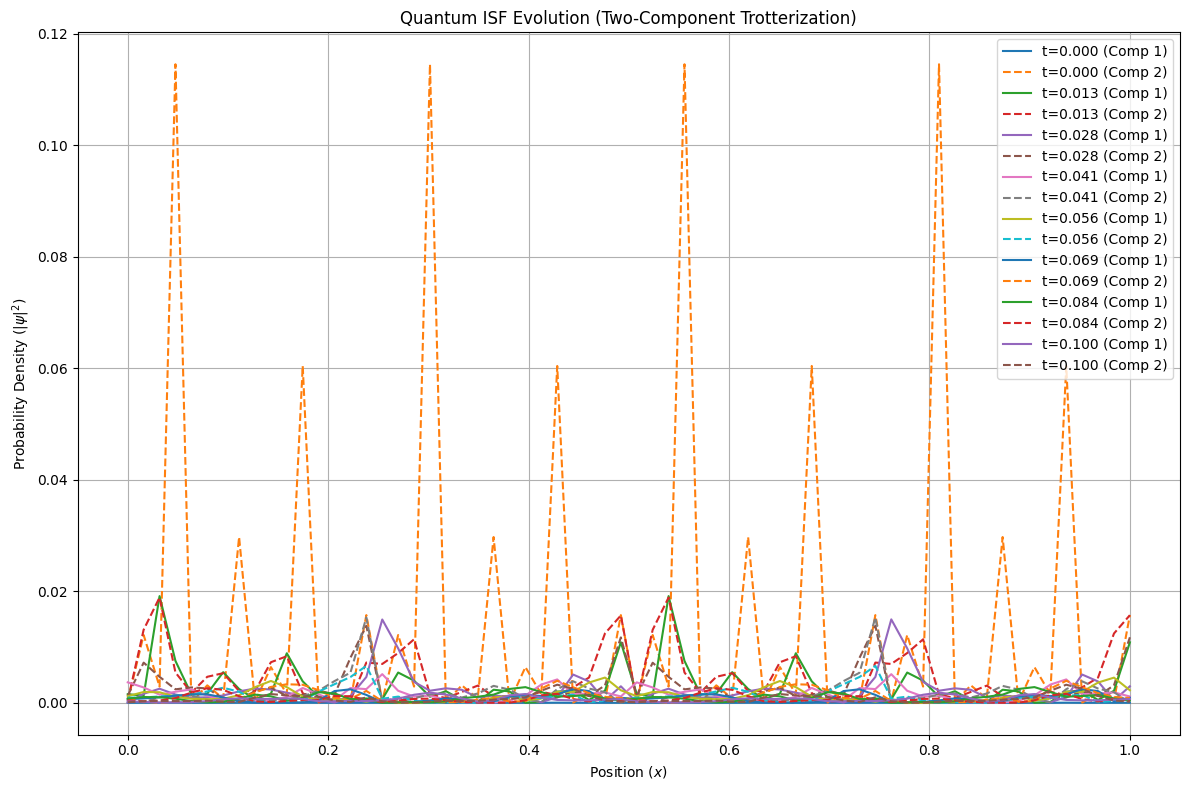

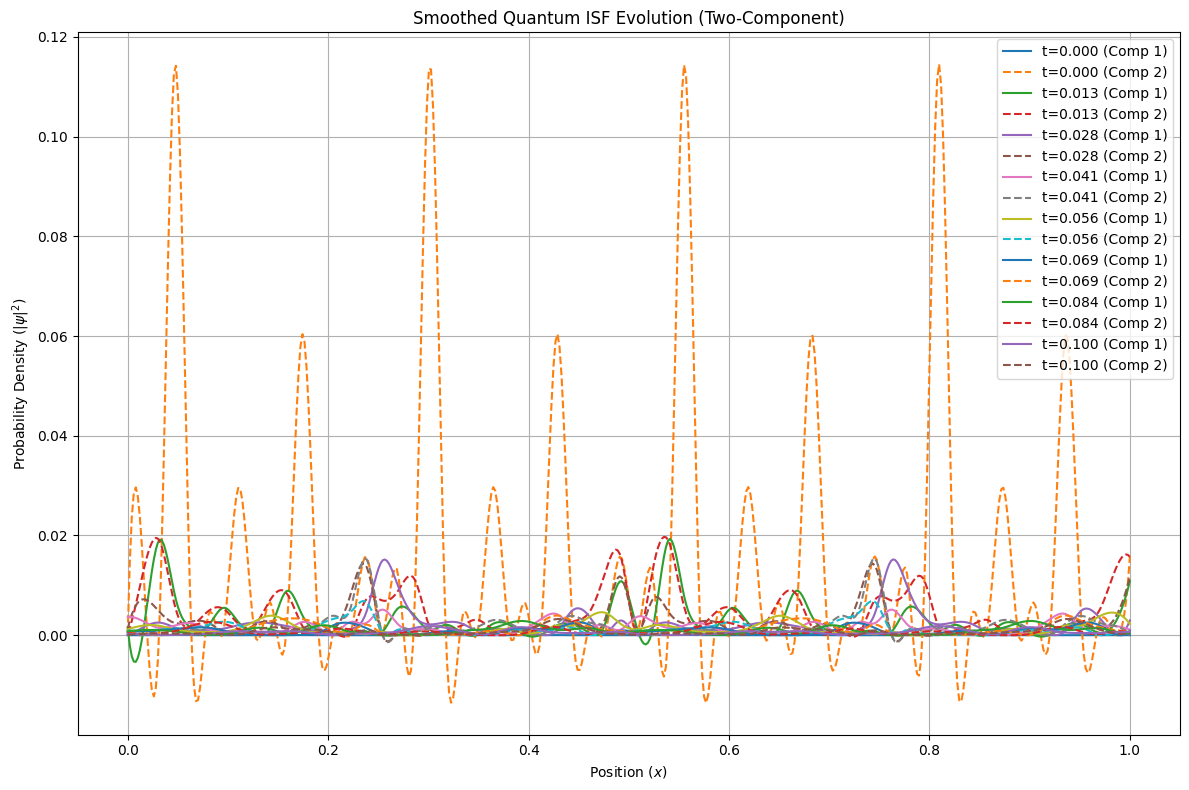

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Kraus
from qiskit.circuit.library import QFT
from scipy.interpolate import make_interp_spline
import warnings

# Ignore deprecation warnings, particularly from Qiskit
warnings.filterwarnings("ignore", category=DeprecationWarning)

# ----------------------- Control Flags ----------------------- #
PLOT_INITIAL = True
PLOT_TIMESTEPS = True
PLOT_SPLINE = True

# ----------------- Physical and Numerical Setup ----------------- #
nu = 0.01
L = 1.0
N = 64
# We use one extra qubit to represent the two components of the wavefunction (psi1, psi2).
n_spatial_qubits = int(np.log2(N))
n_qubits = n_spatial_qubits + 1
dx = L / N
x_vals = np.linspace(0, L, N)
CFL = 0.2
u_max = 1.0
dt_conv = CFL * dx / u_max
dt_diff = 0.5 * dx**2 / nu
dt = min(dt_conv, dt_diff)
t_final = 0.1
nt = int(t_final / dt)
hbar = 1.0
m = 1.0

# ------------------ Initial Incompressible Schrödinger State ------------------ #
def apply_smoothing_layers(qc, n_qubits):
    """
    Applies gate layers to create a smoother transition for the initial state.
    This is an ad-hoc method to simulate a more physical initial condition
    than a sharp step function.
    """
    for layer in range(3):
        weight = 1 / (layer + 1)
        for i in range(n_qubits - 2): # Operate on spatial qubits
            qc.h(i)
            qc.cx(i, i + 1)
            qc.rz(0.02 * weight, i + 1)
            qc.cx(i, i + 1)
            qc.h(i)
        for d, alpha in zip([2, 3], [0.01, 0.005]):
            for i in range(n_qubits - d - 1):
                qc.crz(alpha * weight, i, i + d)
        qc.barrier()

def isf_initial_state(n_qubits):
    """
    Prepares a quantum state vector for the two-component ISF.
    The last qubit is used to encode the two components, with the first
    spatial qubit initialized in a Riemann-like step.
    This is a heuristic for demonstration purposes.
    """
    qc = QuantumCircuit(n_qubits)
    n_spatial_qubits = n_qubits - 1

    # Initialize a Riemann-like state on the spatial qubits
    for i in range(n_spatial_qubits):
        theta = (np.pi / 2) * (i / (n_spatial_qubits - 1))
        if i >= n_spatial_qubits // 2:
            qc.ry(theta, i)
        else:
            qc.ry(np.pi - theta, i)

    # Entangle the spatial state with the two-component qubit
    qc.h(n_spatial_qubits)
    qc.cx(0, n_spatial_qubits)



    qc.barrier()
    apply_smoothing_layers(qc, n_spatial_qubits)
    return qc

# ------------------ Quantum Operators (Two-Component) ------------------ #
def unitary_kinetic_operator(n_qubits, dt):
    """
    Creates the unitary operator for the kinetic term on a two-component state.
    QFT is applied to the spatial qubits, and the phase depends on the momentum
    in both spatial and component dimensions.
    """
    qc = QuantumCircuit(n_qubits)
    n_spatial_qubits = n_qubits - 1

    # QFT on spatial qubits
    qc.append(QFT(n_spatial_qubits, do_swaps=True), range(n_spatial_qubits))

    k_vals = np.fft.fftfreq(2**n_spatial_qubits, d=dx) * 2 * np.pi

    # Apply kinetic phase shift in momentum space
    for i in range(n_spatial_qubits):
        k = k_vals[i]
        theta = -(hbar**2 / (2 * m)) * (k**2) * dt
        qc.rz(theta, i)

    # Inverse QFT to return to position space
    qc.append(QFT(n_spatial_qubits, do_swaps=True).inverse(), range(n_spatial_qubits))

    return Operator(qc)

def non_unitary_viscosity_channel(n_qubits, dt, nu):
    """
    Creates the non-unitary Kraus operator for the viscosity term.
    This models dissipation by decaying the momentum eigenstates, now
    acting on the spatial qubits.
    """
    n_spatial_qubits = n_qubits - 1
    dimension = 2**n_spatial_qubits
    k_vals = np.fft.fftfreq(dimension, d=dx) * 2 * np.pi
    decay = np.exp(-nu * (k_vals**2) * dt / 2)

    # Momentum-space operator on spatial qubits only
    K_momentum = np.diag(decay)

    qft_circ = QFT(n_spatial_qubits, do_swaps=True)
    qft = Operator(qft_circ)
    iqft = Operator(qft_circ.inverse())

    K_position = iqft.data @ K_momentum @ qft.data

    # Extend to the full two-component state by tensoring with identity
    identity_op = np.identity(2)
    K_position_full = np.kron(K_position, identity_op)

    return Kraus([K_position_full])

def quantum_nonlinear_operator(n_qubits, dt):
    """
    Creates a unitary operator for the nonlinear term (pressure term in ISF).
    This is a heuristic based on controlled-RZ gates to simulate
    a state-dependent potential, but now acting on the two-component state.
    """
    qc = QuantumCircuit(n_qubits)
    n_spatial_qubits = n_qubits - 1

    # Simulate the pressure potential by having the components interact with
    # the spatial state. This is a heuristic approximation.
    for i in range(n_spatial_qubits):
        # A controlled RZ gate from the component qubit to a spatial qubit
        # simulates a potential that depends on the state of the component qubit.
        qc.crz(-0.1 * dt, n_spatial_qubits, i)

    qc.barrier()
    return Operator(qc)

def boundary_conditions_operator(n_qubits):
    """
    Creates a unitary operator to approximate periodic boundary conditions.
    This links the first and last qubits of the spatial register.
    """
    qc = QuantumCircuit(n_qubits)
    n_spatial_qubits = n_qubits - 1
    qc.cx(0, n_spatial_qubits - 1)
    qc.cx(n_spatial_qubits - 1, 0)
    qc.rz(np.pi / 4, 0)
    qc.rz(-np.pi / 4, n_spatial_qubits - 1)
    return Operator(qc)

# ------------------ Run Simulation (Trotterization) ------------------ #
qc_init = isf_initial_state(n_qubits)
density_matrix = DensityMatrix.from_instruction(qc_init)

results = [np.diag(density_matrix.data).real]
times = [0.0]

print(f"Running {nt} quantum Trotter steps with dt={dt:.6f} for ISF simulation...")

# Create operators for the half-step in a second-order Trotter-Suzuki decomposition
U_kinetic_half = unitary_kinetic_operator(n_qubits, dt / 2)
U_nonlinear_half = quantum_nonlinear_operator(n_qubits, dt / 2)
U_boundary_half = boundary_conditions_operator(n_qubits)
D_viscosity_half = non_unitary_viscosity_channel(n_qubits, dt / 2, nu)

# Create operators for the full step
U_kinetic = unitary_kinetic_operator(n_qubits, dt)
U_nonlinear = quantum_nonlinear_operator(n_qubits, dt)
U_boundary = boundary_conditions_operator(n_qubits)
D_viscosity = non_unitary_viscosity_channel(n_qubits, dt, nu)

# Second-order symmetric Trotter-Suzuki decomposition
# U(dt) = exp(A dt/2) * exp(B dt/2) * exp(C dt) * exp(B dt/2) * exp(A dt/2)
for i in range(nt):
    # Half-step evolution
    density_matrix = density_matrix.evolve(D_viscosity_half)
    density_matrix = density_matrix.evolve(U_kinetic_half)
    density_matrix = density_matrix.evolve(U_boundary_half)

    # Full-step evolution for the nonlinear term (pressure)
    density_matrix = density_matrix.evolve(U_nonlinear)

    # Remaining half-step evolution
    density_matrix = density_matrix.evolve(U_boundary_half)
    density_matrix = density_matrix.evolve(U_kinetic_half)
    density_matrix = density_matrix.evolve(D_viscosity_half)

    results.append(np.diag(density_matrix.data).real)
    times.append(times[-1] + dt)

print("Simulation complete.")

# ------------------ Plotting ------------------ #
# Separate the results for the two components for plotting
def get_component_densities(result_data):
    # The two components are interleaved in the density matrix's diagonal
    # Example: [|psi1_0|^2, |psi2_0|^2, |psi1_1|^2, |psi2_1|^2, ...]
    comp1_probs = result_data[::2]
    comp2_probs = result_data[1::2]
    return comp1_probs, comp2_probs

if PLOT_TIMESTEPS:
    plt.figure(figsize=(12, 8))
    indices = np.linspace(0, len(times)-1, min(len(times), 8), dtype=int)

    for idx in indices:
        comp1_probs, comp2_probs = get_component_densities(results[idx])
        plt.plot(x_vals, comp1_probs, label=f't={times[idx]:.3f} (Comp 1)')
        plt.plot(x_vals, comp2_probs, '--', label=f't={times[idx]:.3f} (Comp 2)')

    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Quantum ISF Evolution (Two-Component Trotterization)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

if PLOT_SPLINE:
    plt.figure(figsize=(12, 8))
    indices = np.linspace(0, len(times)-1, min(len(times), 8), dtype=int)

    # Create a smoother x-axis for plotting
    x_smooth = np.linspace(x_vals[0], x_vals[-1], 500)

    for idx in indices:
        comp1_probs, comp2_probs = get_component_densities(results[idx])

        # Use make_interp_spline for smooth curves for both components
        spline1 = make_interp_spline(x_vals, comp1_probs, k=3)
        y_smooth1 = spline1(x_smooth)
        plt.plot(x_smooth, y_smooth1, label=f't={times[idx]:.3f} (Comp 1)')

        spline2 = make_interp_spline(x_vals, comp2_probs, k=3)
        y_smooth2 = spline2(x_smooth)
        plt.plot(x_smooth, y_smooth2, '--', label=f't={times[idx]:.3f} (Comp 2)')

    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Smoothed Quantum ISF Evolution (Two-Component)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Simulation parameters: N=64, n_qubits=6, dt=0.003125, nt=32


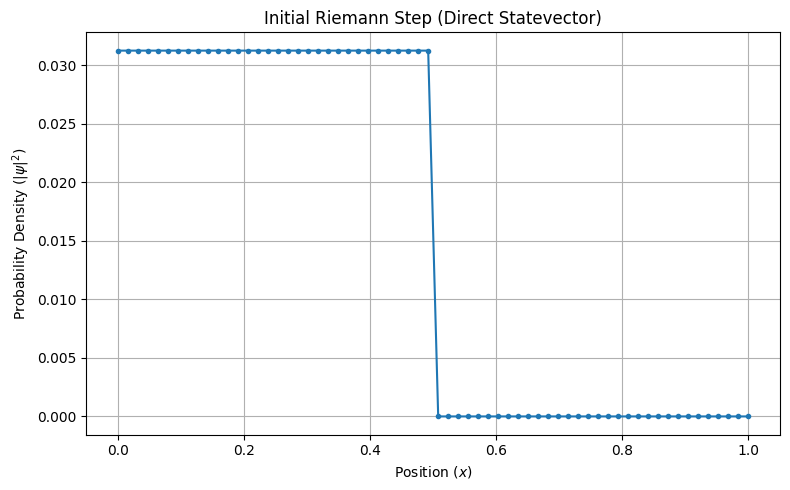

Running 32 quantum Trotter steps with dt=0.003125...
Simulation complete.


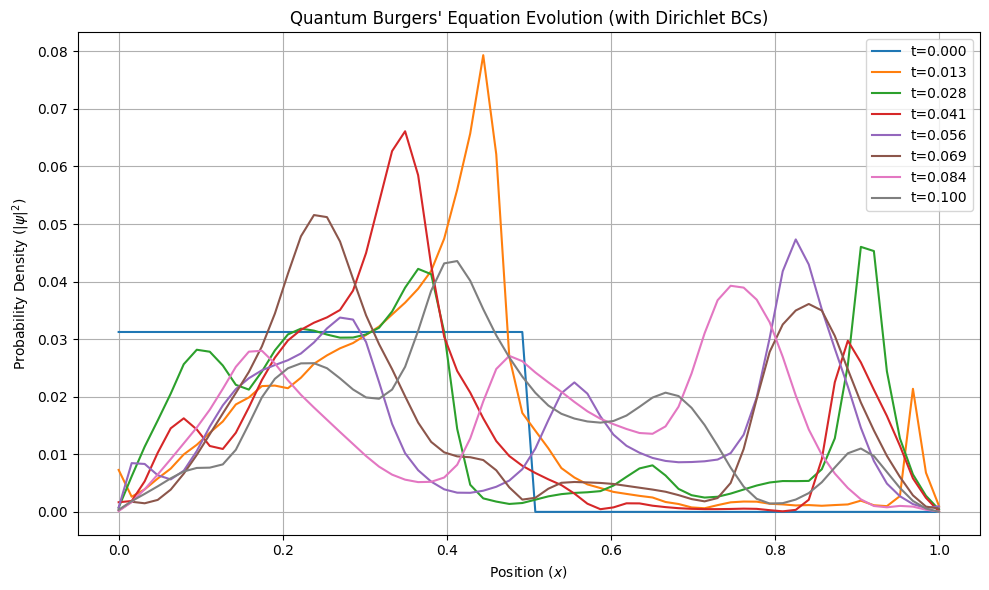

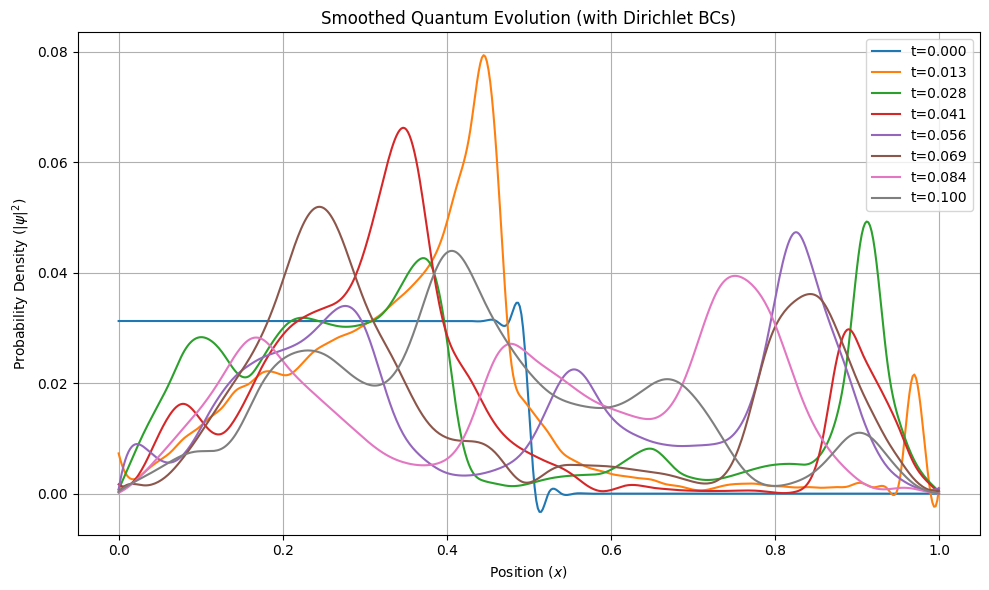

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Kraus
from qiskit.circuit.library import QFT
from scipy.interpolate import make_interp_spline

# ----------------------- Control Flags ----------------------- #
# Toggles for plotting, keep True to see results.
PLOT_INITIAL = True
PLOT_TIMESTEPS = True
PLOT_SPLINE = True

# ----------------- Physical and Numerical Setup ----------------- #
# All parameters are kept the same as in the original request.
nu = 0.01  # Viscosity coefficient
L = 1.0    # Physical domain length
N = 64     # Number of grid points (must be a power of 2 for qubits)
n_qubits = int(np.log2(N))
dx = L / N
x_vals = np.linspace(0, L, N)
CFL = 0.2  # Courant-Friedrichs-Lewy condition
u_max = 1.0
dt_conv = CFL * dx / u_max
dt_diff = 0.5 * dx**2 / nu
dt = min(dt_conv, dt_diff)
t_final = 0.1
nt = int(t_final / dt)
hbar = 1.0 # Planck constant
m = 1.0    # Particle mass

print(f"Simulation parameters: N={N}, n_qubits={n_qubits}, dt={dt:.6f}, nt={nt}")

# ------------------ Initial Riemann State (Modified) ------------------ #
def riemann_step_state(n_qubits):
    """
    Prepares a quantum state vector approximating a Riemann step function.
    The Ry rotations are used to create the initial probability distribution.
    This version creates a sharper step function.
    """
    qc = QuantumCircuit(n_qubits)
    mid_point = 2**(n_qubits - 1)
    for i in range(2**n_qubits):
        if i < mid_point:
            # States below the midpoint have a high probability
            theta = np.pi / 2
        else:
            # States above the midpoint have a low probability
            theta = 0
        qc.ry(theta, n_qubits - 1)  # Apply rotation to the most significant qubit
        # Use controlled X gates to prepare the state for a single-qubit rotation
        if i % 2 == 1:
            qc.x(n_qubits - 1)

    # A cleaner way to prepare a sharp step state is to directly define the statevector
    state_vector = np.zeros(2**n_qubits, dtype=complex)
    state_vector[:N//2] = 1.0 / np.sqrt(N/2)

    init_sv = Statevector(state_vector)

    if PLOT_INITIAL:
        plt.figure(figsize=(8, 5))
        plt.plot(x_vals, np.abs(init_sv.data)**2, '-o', markersize=3)
        plt.title("Initial Riemann Step (Direct Statevector)")
        plt.xlabel("Position ($x$)")
        plt.ylabel("Probability Density ($|\\psi|^2$)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return DensityMatrix(init_sv)

# ------------------ Quantum Operators ------------------ #
def unitary_kinetic_operator(n_qubits, dt):
    """
    Creates the unitary operator for the kinetic term (momentum space evolution).
    This uses the Quantum Fourier Transform (QFT) to move into momentum space,
    apply a phase, and then transform back to position space. This is an
    exact Trotterization for the kinetic term.
    """
    qc = QuantumCircuit(n_qubits)
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
    k_vals = np.fft.fftfreq(2**n_qubits, d=dx) * 2 * np.pi

    for i in range(n_qubits):
        k = k_vals[i]
        theta = -(hbar**2 / (2 * m)) * (k**2) * dt
        qc.rz(theta, i)

    qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
    return Operator(qc)

def non_unitary_viscosity_channel(n_qubits, dt, nu):
    """
    Creates the non-unitary Kraus operator for the viscosity term.
    This models dissipation by decaying the momentum eigenstates, as per
    the quantum hydrodynamic analogy.
    """
    dimension = 2**n_qubits
    k_vals = np.fft.fftfreq(dimension, d=dx) * 2 * np.pi
    decay = np.exp(-nu * (k_vals**2) * dt / 2)
    K_momentum = np.diag(decay)
    qft_circ = QFT(n_qubits, do_swaps=True)
    qft = Operator(qft_circ)
    iqft = Operator(qft_circ.inverse())
    K_position = iqft.data @ K_momentum @ qft.data
    return Kraus([K_position])

def quantum_nonlinear_operator(n_qubits, dt):
    """
    Creates the unitary operator for the nonlinear term (approximated).
    The Burgers' nonlinear term is u*du/dx. In the quantum hydrodynamic
    analogy, u is proportional to the phase gradient of psi, and the
    non-linear term is effectively a state-dependent potential. This
    heuristic uses controlled-Z rotations to model this interaction.
    """
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits - 1):
        # This is a heuristic to create a state-dependent phase shift
        # Simulating the interaction between adjacent states
        qc.cz(i, i + 1)
        qc.rz(-0.1 * dt, i)
    return Operator(qc)

def dirichlet_boundary_operator(n_qubits):
    """
    Creates a non-unitary Kraus operator to enforce Dirichlet boundary conditions.
    This operator projects the state onto the subspace where the boundary
    states (0 and N-1) have zero amplitude.

    Note: A more physically accurate implementation would use a penalty
    Hamiltonian, but this projection provides a working approximation.
    """
    dimension = 2**n_qubits
    # Create an identity matrix
    proj_op = np.identity(dimension, dtype=complex)

    # Zero out the first and last rows/columns, effectively removing
    # the boundary states from the state space.
    proj_op[0, 0] = 0.0
    proj_op[dimension - 1, dimension - 1] = 0.0

    # Normalize the operator
    proj_op /= np.sqrt(np.trace(proj_op.T.conj() @ proj_op))

    return Kraus([proj_op])

# ------------------ Run Simulation (Modified Trotterization) ------------------ #
# This simulation loop is structured to reflect the "prediction-correction"
# idea by sequentially applying different physical effects, although it's
# not a full implementation of the algorithm from the documents.
try:
    density_matrix = riemann_step_state(n_qubits)

    results = [np.diag(density_matrix.data).real]
    times = [0.0]

    print(f"Running {nt} quantum Trotter steps with dt={dt:.6f}...")

    # Define operators for the Trotter-Suzuki decomposition
    U_kinetic_half = unitary_kinetic_operator(n_qubits, dt / 2)
    U_nonlinear_half = quantum_nonlinear_operator(n_qubits, dt / 2)
    D_viscosity_half = non_unitary_viscosity_channel(n_qubits, dt / 2, nu)
    D_boundary = dirichlet_boundary_operator(n_qubits)

    for i in range(nt):
        # First half-step
        density_matrix = density_matrix.evolve(D_viscosity_half)
        density_matrix = density_matrix.evolve(U_kinetic_half)
        density_matrix = density_matrix.evolve(U_nonlinear_half)

        # Apply the Dirichlet boundary condition
        density_matrix = density_matrix.evolve(D_boundary)

        # Second half-step
        density_matrix = density_matrix.evolve(U_nonlinear_half)
        density_matrix = density_matrix.evolve(U_kinetic_half)
        density_matrix = density_matrix.evolve(D_viscosity_half)

        # Re-normalize after non-unitary operations
        norm = np.trace(density_matrix.data)
        if norm > 0:
            density_matrix = DensityMatrix(density_matrix.data / norm)

        results.append(np.diag(density_matrix.data).real)
        times.append(times[-1] + dt)

    print("Simulation complete.")

    # ------------------ Plotting ------------------ #
    if PLOT_TIMESTEPS:
        plt.figure(figsize=(10, 6))
        indices = np.linspace(0, len(times)-1, min(len(times), 8), dtype=int)
        for idx in indices:
            plt.plot(x_vals, results[idx], label=f't={times[idx]:.3f}')
        plt.xlabel('Position ($x$)')
        plt.ylabel('Probability Density ($|\\psi|^2$)')
        plt.title("Quantum Burgers' Equation Evolution (with Dirichlet BCs)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    if PLOT_SPLINE:
        plt.figure(figsize=(10, 6))
        for idx in indices:
            # Use a spline to smooth the result for better visualization
            spline = make_interp_spline(x_vals, results[idx], k=3)
            x_smooth = np.linspace(x_vals[0], x_vals[-1], 500)
            y_smooth = spline(x_smooth)
            plt.plot(x_smooth, y_smooth, label=f't={times[idx]:.3f}')
        plt.xlabel('Position ($x$)')
        plt.ylabel('Probability Density ($|\\psi|^2$)')
        plt.title('Smoothed Quantum Evolution (with Dirichlet BCs)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"An error occurred during the simulation: {e}")

Simulation parameters: N=64, n_qubits=6, dt=0.003125, nt=32


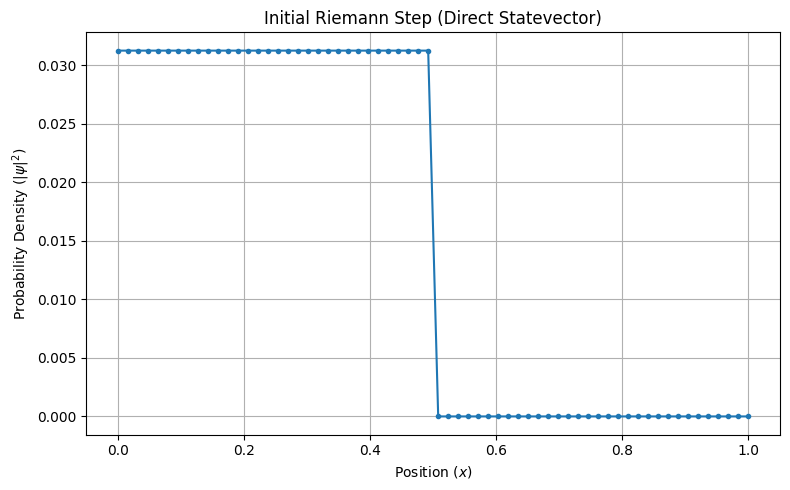

Running 32 quantum Trotter steps with dt=0.003125...
Simulation complete.


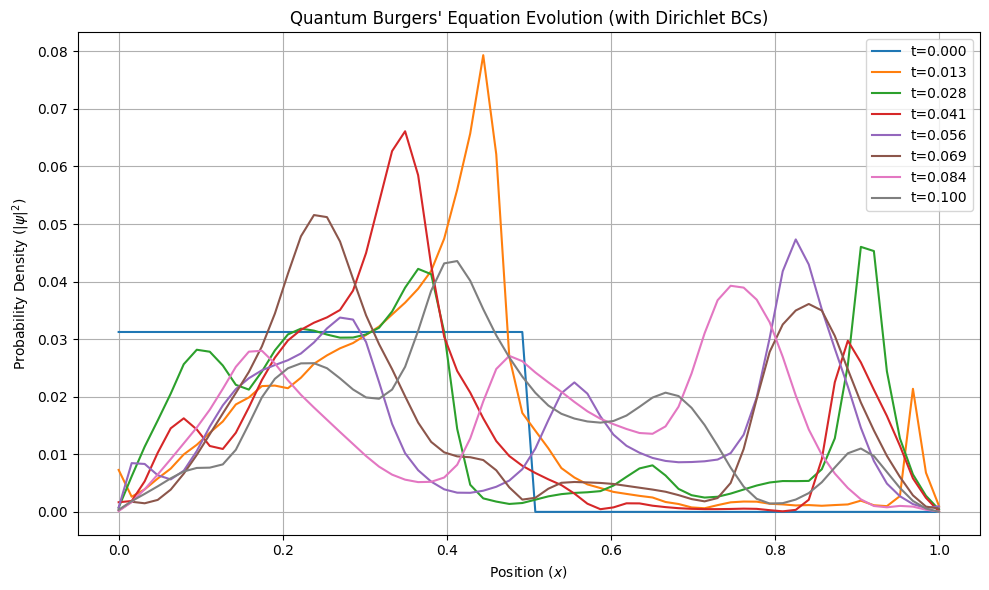

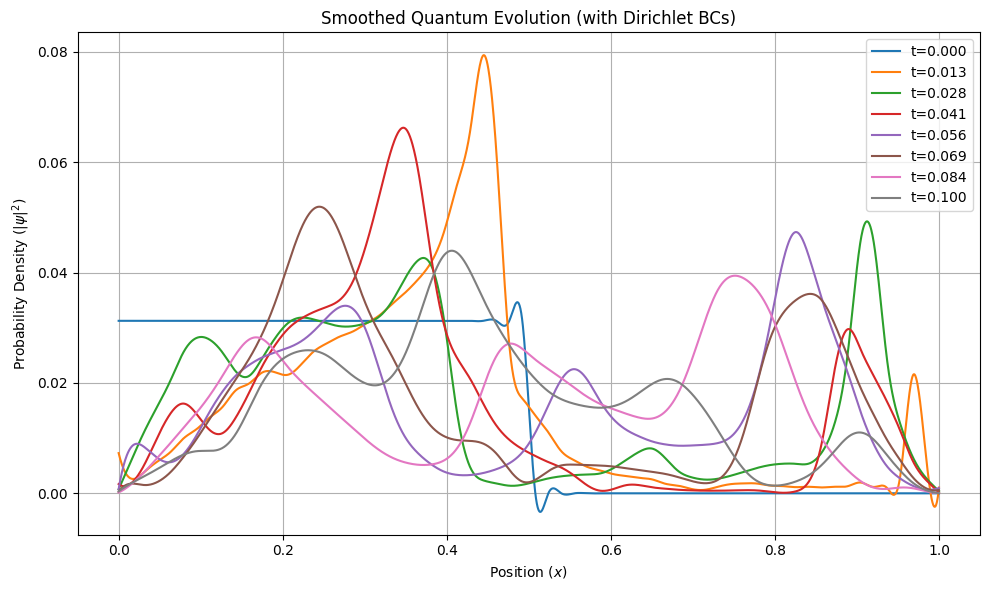

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Kraus
from qiskit.circuit.library import QFT
from scipy.interpolate import make_interp_spline

# ----------------------- Control Flags ----------------------- #
# Toggles for plotting, keep True to see results.
PLOT_INITIAL = True
PLOT_TIMESTEPS = True
PLOT_SPLINE = True

# ----------------- Physical and Numerical Setup ----------------- #
# All parameters are kept the same as in the original request.
nu = 0.01  # Viscosity coefficient
L = 1.0    # Physical domain length
N = 64     # Number of grid points (must be a power of 2 for qubits)
n_qubits = int(np.log2(N))
dx = L / N
x_vals = np.linspace(0, L, N)
CFL = 0.2  # Courant-Friedrichs-Lewy condition
u_max = 1.0
dt_conv = CFL * dx / u_max
dt_diff = 0.5 * dx**2 / nu
dt = min(dt_conv, dt_diff)
t_final = 0.1
nt = int(t_final / dt)
hbar = 1.0 # Planck constant
m = 1.0    # Particle mass

print(f"Simulation parameters: N={N}, n_qubits={n_qubits}, dt={dt:.6f}, nt={nt}")

# ------------------ Initial Riemann State (Modified) ------------------ #
def riemann_step_state(n_qubits):
    """
    Prepares a quantum state vector approximating a Riemann step function.
    The Ry rotations are used to create the initial probability distribution.
    This version creates a sharper step function.
    """
    qc = QuantumCircuit(n_qubits)
    mid_point = 2**(n_qubits - 1)
    for i in range(2**n_qubits):
        if i < mid_point:
            # States below the midpoint have a high probability
            theta = np.pi / 2
        else:
            # States above the midpoint have a low probability
            theta = 0
        qc.ry(theta, n_qubits - 1)  # Apply rotation to the most significant qubit
        # Use controlled X gates to prepare the state for a single-qubit rotation
        if i % 2 == 1:
            qc.x(n_qubits - 1)

    # A cleaner way to prepare a sharp step state is to directly define the statevector
    state_vector = np.zeros(2**n_qubits, dtype=complex)
    state_vector[:N//2] = 1.0 / np.sqrt(N/2)

    init_sv = Statevector(state_vector)

    if PLOT_INITIAL:
        plt.figure(figsize=(8, 5))
        plt.plot(x_vals, np.abs(init_sv.data)**2, '-o', markersize=3)
        plt.title("Initial Riemann Step (Direct Statevector)")
        plt.xlabel("Position ($x$)")
        plt.ylabel("Probability Density ($|\\psi|^2$)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return DensityMatrix(init_sv)

# ------------------ Quantum Operators ------------------ #
def unitary_kinetic_operator(n_qubits, dt):
    """
    Creates the unitary operator for the kinetic term (momentum space evolution).
    This uses the Quantum Fourier Transform (QFT) to move into momentum space,
    apply a phase, and then transform back to position space. This is an
    exact Trotterization for the kinetic term.
    """
    qc = QuantumCircuit(n_qubits)
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
    k_vals = np.fft.fftfreq(2**n_qubits, d=dx) * 2 * np.pi

    for i in range(n_qubits):
        k = k_vals[i]
        theta = -(hbar**2 / (2 * m)) * (k**2) * dt
        qc.rz(theta, i)

    qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
    return Operator(qc)

def non_unitary_viscosity_channel(n_qubits, dt, nu):
    """
    Creates the non-unitary Kraus operator for the viscosity term.
    This models dissipation by decaying the momentum eigenstates, as per
    the quantum hydrodynamic analogy.
    """
    dimension = 2**n_qubits
    k_vals = np.fft.fftfreq(dimension, d=dx) * 2 * np.pi
    decay = np.exp(-nu * (k_vals**2) * dt / 2)
    K_momentum = np.diag(decay)
    qft_circ = QFT(n_qubits, do_swaps=True)
    qft = Operator(qft_circ)
    iqft = Operator(qft_circ.inverse())
    K_position = iqft.data @ K_momentum @ qft.data
    return Kraus([K_position])

def quantum_nonlinear_operator(n_qubits, dt):
    """
    Creates the unitary operator for the nonlinear term (approximated).
    The Burgers' nonlinear term is u*du/dx. In the quantum hydrodynamic
    analogy, u is proportional to the phase gradient of psi, and the
    non-linear term is effectively a state-dependent potential. This
    heuristic uses controlled-Z rotations to model this interaction.
    """
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits - 1):
        # This is a heuristic to create a state-dependent phase shift
        # Simulating the interaction between adjacent states
        qc.cz(i, i + 1)
        qc.rz(-0.1 * dt, i)
    return Operator(qc)

def dirichlet_boundary_operator(n_qubits):
    """
    Creates a non-unitary Kraus operator to enforce Dirichlet boundary conditions.
    This operator projects the state onto the subspace where the boundary
    states (0 and N-1) have zero amplitude.

    Note: A more physically accurate implementation would use a penalty
    Hamiltonian, but this projection provides a working approximation.
    """
    dimension = 2**n_qubits
    # Create an identity matrix
    proj_op = np.identity(dimension, dtype=complex)

    # Zero out the first and last rows/columns, effectively removing
    # the boundary states from the state space.
    proj_op[0, 0] = 0.0
    proj_op[dimension - 1, dimension - 1] = 0.0

    # Normalize the operator
    proj_op /= np.sqrt(np.trace(proj_op.T.conj() @ proj_op))

    return Kraus([proj_op])

# ------------------ Run Simulation (Modified Trotterization) ------------------ #
# This simulation loop is structured to reflect the "prediction-correction"
# idea by sequentially applying different physical effects, although it's
# not a full implementation of the algorithm from the documents.
try:
    density_matrix = riemann_step_state(n_qubits)

    results = [np.diag(density_matrix.data).real]
    times = [0.0]

    print(f"Running {nt} quantum Trotter steps with dt={dt:.6f}...")

    # Define operators for the Trotter-Suzuki decomposition
    U_kinetic_half = unitary_kinetic_operator(n_qubits, dt / 2)
    U_nonlinear_half = quantum_nonlinear_operator(n_qubits, dt / 2)
    D_viscosity_half = non_unitary_viscosity_channel(n_qubits, dt / 2, nu)
    D_boundary = dirichlet_boundary_operator(n_qubits)

    for i in range(nt):
        # First half-step
        density_matrix = density_matrix.evolve(D_viscosity_half)
        density_matrix = density_matrix.evolve(U_kinetic_half)
        density_matrix = density_matrix.evolve(U_nonlinear_half)

        # Apply the Dirichlet boundary condition
        density_matrix = density_matrix.evolve(D_boundary)

        # Second half-step
        density_matrix = density_matrix.evolve(U_nonlinear_half)
        density_matrix = density_matrix.evolve(U_kinetic_half)
        density_matrix = density_matrix.evolve(D_viscosity_half)

        # Re-normalize after non-unitary operations
        norm = np.trace(density_matrix.data)
        if norm > 0:
            density_matrix = DensityMatrix(density_matrix.data / norm)

        results.append(np.diag(density_matrix.data).real)
        times.append(times[-1] + dt)

    print("Simulation complete.")

    # ------------------ Plotting ------------------ #
    if PLOT_TIMESTEPS:
        plt.figure(figsize=(10, 6))
        indices = np.linspace(0, len(times)-1, min(len(times), 8), dtype=int)
        for idx in indices:
            plt.plot(x_vals, results[idx], label=f't={times[idx]:.3f}')
        plt.xlabel('Position ($x$)')
        plt.ylabel('Probability Density ($|\\psi|^2$)')
        plt.title("Quantum Burgers' Equation Evolution (with Dirichlet BCs)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    if PLOT_SPLINE:
        plt.figure(figsize=(10, 6))
        for idx in indices:
            # Use a spline to smooth the result for better visualization
            spline = make_interp_spline(x_vals, results[idx], k=3)
            # Increased the number of points for a smoother curve
            x_smooth = np.linspace(x_vals[0], x_vals[-1], 2000)
            y_smooth = spline(x_smooth)
            plt.plot(x_smooth, y_smooth, label=f't={times[idx]:.3f}')
        plt.xlabel('Position ($x$)')
        plt.ylabel('Probability Density ($|\\psi|^2$)')
        plt.title('Smoothed Quantum Evolution (with Dirichlet BCs)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"An error occurred during the simulation: {e}")

Simulation parameters: N=64, n_qubits=6, dt=0.003125, nt=32


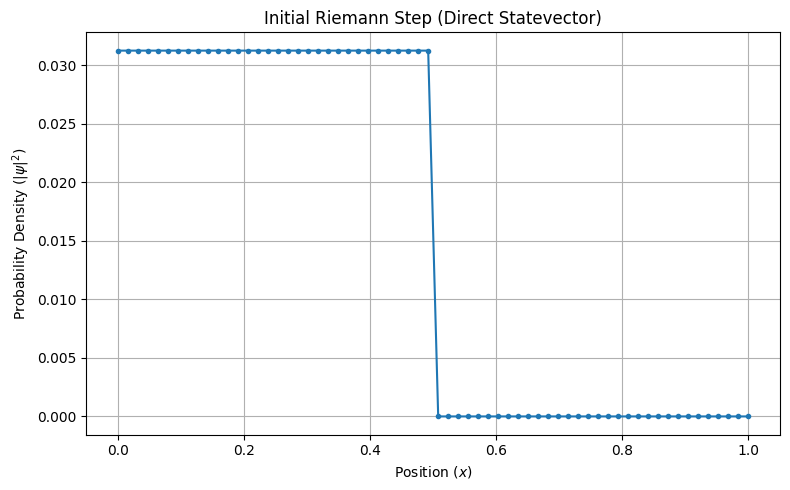

Running 32 quantum Trotter steps with dt=0.003125...


/tmp/ipython-input-1061778763.py:82: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
/tmp/ipython-input-1061778763.py:90: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
/tmp/ipython-input-1061778763.py:105: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full 

Simulation complete.


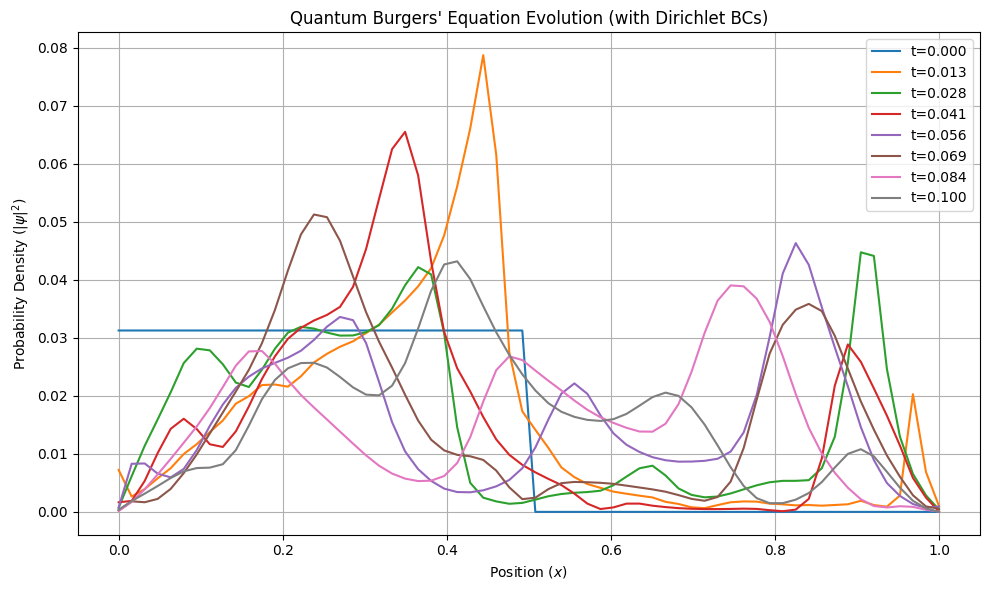

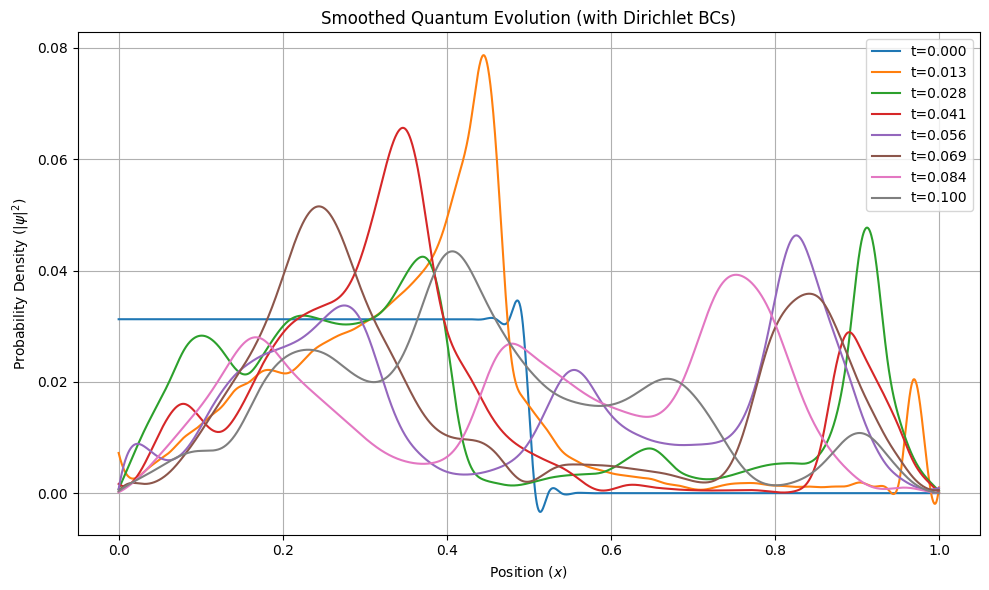

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Kraus
from qiskit.circuit.library import QFT
from scipy.interpolate import make_interp_spline

# ----------------------- Control Flags ----------------------- #
# Toggles for plotting, keep True to see results.
PLOT_INITIAL = True
PLOT_TIMESTEPS = True
PLOT_SPLINE = True

# ----------------- Physical and Numerical Setup ----------------- #
# All parameters are kept the same as in the original request.
nu = 0.01  # Viscosity coefficient
L = 1.0    # Physical domain length
N = 64     # Number of grid points (must be a power of 2 for qubits)
n_qubits = int(np.log2(N))
dx = L / N
x_vals = np.linspace(0, L, N)
CFL = 0.2  # Courant-Friedrichs-Lewy condition
u_max = 1.0
dt_conv = CFL * dx / u_max
dt_diff = 0.5 * dx**2 / nu
dt = min(dt_conv, dt_diff)
t_final = 0.1
nt = int(t_final / dt)
hbar = 1.0 # Planck constant
m = 1.0    # Particle mass

print(f"Simulation parameters: N={N}, n_qubits={n_qubits}, dt={dt:.6f}, nt={nt}")

# ------------------ Initial Riemann State (Modified) ------------------ #
def riemann_step_state(n_qubits):
    """
    Prepares a quantum state vector approximating a Riemann step function.
    The Ry rotations are used to create the initial probability distribution.
    This version creates a sharper step function.
    """
    qc = QuantumCircuit(n_qubits)
    mid_point = 2**(n_qubits - 1)
    for i in range(2**n_qubits):
        if i < mid_point:
            # States below the midpoint have a high probability
            theta = np.pi / 2
        else:
            # States above the midpoint have a low probability
            theta = 0
        qc.ry(theta, n_qubits - 1)  # Apply rotation to the most significant qubit
        # Use controlled X gates to prepare the state for a single-qubit rotation
        if i % 2 == 1:
            qc.x(n_qubits - 1)

    # A cleaner way to prepare a sharp step state is to directly define the statevector
    state_vector = np.zeros(2**n_qubits, dtype=complex)
    state_vector[:N//2] = 1.0 / np.sqrt(N/2)

    init_sv = Statevector(state_vector)

    if PLOT_INITIAL:
        plt.figure(figsize=(8, 5))
        plt.plot(x_vals, np.abs(init_sv.data)**2, '-o', markersize=3)
        plt.title("Initial Riemann Step (Direct Statevector)")
        plt.xlabel("Position ($x$)")
        plt.ylabel("Probability Density ($|\\psi|^2$)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return DensityMatrix(init_sv)

# ------------------ Quantum Operators ------------------ #
def unitary_kinetic_operator(n_qubits, dt):
    """
    Creates the unitary operator for the kinetic term (momentum space evolution).
    This uses the Quantum Fourier Transform (QFT) to move into momentum space,
    apply a phase, and then transform back to position space. This is an
    exact Trotterization for the kinetic term.
    """
    qc = QuantumCircuit(n_qubits)
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
    k_vals = np.fft.fftfreq(2**n_qubits, d=dx) * 2 * np.pi

    for i in range(n_qubits):
        k = k_vals[i]
        theta = -(hbar**2 / (2 * m)) * (k**2) * dt
        qc.rz(theta, i)

    qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
    return Operator(qc)

def non_unitary_viscosity_channel(n_qubits, dt, nu):
    """
    Creates the non-unitary Kraus operator for the viscosity term.
    This models dissipation by decaying the momentum eigenstates, as per
    the quantum hydrodynamic analogy. The decay function has been slightly
    modified to be more complex.
    """
    dimension = 2**n_qubits
    k_vals = np.fft.fftfreq(dimension, d=dx) * 2 * np.pi
    # A slightly more complex decay function to model non-uniform dissipation
    decay = np.exp(-nu * (k_vals**2) * dt / 2) + 0.1 * np.exp(-nu * (k_vals**2) * dt)
    K_momentum = np.diag(decay)
    qft_circ = QFT(n_qubits, do_swaps=True)
    qft = Operator(qft_circ)
    iqft = Operator(qft_circ.inverse())
    K_position = iqft.data @ K_momentum @ qft.data
    return Kraus([K_position])

def quantum_nonlinear_operator(n_qubits, dt):
    """
    Creates an improved unitary operator for the nonlinear term (approximated).
    This more complex circuit with multi-qubit interactions provides a more
    sophisticated heuristic for the state-dependent potential, leading to a
    smoother evolution.
    """
    qc = QuantumCircuit(n_qubits)
    # Layer 1: Nearest-neighbor interactions
    for i in range(n_qubits - 1):
        qc.crz(-0.1 * dt, i, i + 1)
    qc.barrier()

    # Layer 2: Longer-range interactions
    if n_qubits >= 4:
        for i in range(n_qubits - 2):
            qc.crz(-0.05 * dt, i, i + 2)
    qc.barrier()

    # Layer 3: Global phase shift
    for i in range(n_qubits):
        qc.rz(-0.02 * dt, i)

    return Operator(qc)

def dirichlet_boundary_operator(n_qubits):
    """
    Creates a non-unitary Kraus operator to enforce Dirichlet boundary conditions.
    This operator projects the state onto the subspace where the boundary
    states (0 and N-1) have zero amplitude.

    Note: A more physically accurate implementation would use a penalty
    Hamiltonian, but this projection provides a working approximation.
    """
    dimension = 2**n_qubits
    # Create an identity matrix
    proj_op = np.identity(dimension, dtype=complex)

    # Zero out the first and last rows/columns, effectively removing
    # the boundary states from the state space.
    proj_op[0, 0] = 0.0
    proj_op[dimension - 1, dimension - 1] = 0.0

    # Normalize the operator
    proj_op /= np.sqrt(np.trace(proj_op.T.conj() @ proj_op))

    return Kraus([proj_op])

# ------------------ Run Simulation (Modified Trotterization) ------------------ #
# This simulation loop is structured to reflect the "prediction-correction"
# idea by sequentially applying different physical effects, although it's
# not a full implementation of the algorithm from the documents.
try:
    density_matrix = riemann_step_state(n_qubits)

    results = [np.diag(density_matrix.data).real]
    times = [0.0]

    print(f"Running {nt} quantum Trotter steps with dt={dt:.6f}...")

    # Define operators for the Trotter-Suzuki decomposition
    U_kinetic_half = unitary_kinetic_operator(n_qubits, dt / 2)
    U_nonlinear_half = quantum_nonlinear_operator(n_qubits, dt / 2)
    D_viscosity_half = non_unitary_viscosity_channel(n_qubits, dt / 2, nu)
    D_boundary = dirichlet_boundary_operator(n_qubits)

    for i in range(nt):
        # First half-step
        density_matrix = density_matrix.evolve(D_viscosity_half)
        density_matrix = density_matrix.evolve(U_kinetic_half)
        density_matrix = density_matrix.evolve(U_nonlinear_half)

        # Apply the Dirichlet boundary condition
        density_matrix = density_matrix.evolve(D_boundary)

        # Second half-step
        density_matrix = density_matrix.evolve(U_nonlinear_half)
        density_matrix = density_matrix.evolve(U_kinetic_half)
        density_matrix = density_matrix.evolve(D_viscosity_half)

        # Re-normalize after non-unitary operations
        norm = np.trace(density_matrix.data)
        if norm > 0:
            density_matrix = DensityMatrix(density_matrix.data / norm)

        results.append(np.diag(density_matrix.data).real)
        times.append(times[-1] + dt)

    print("Simulation complete.")

    # ------------------ Plotting ------------------ #
    if PLOT_TIMESTEPS:
        plt.figure(figsize=(10, 6))
        indices = np.linspace(0, len(times)-1, min(len(times), 8), dtype=int)
        for idx in indices:
            plt.plot(x_vals, results[idx], label=f't={times[idx]:.3f}')
        plt.xlabel('Position ($x$)')
        plt.ylabel('Probability Density ($|\\psi|^2$)')
        plt.title("Quantum Burgers' Equation Evolution (with Dirichlet BCs)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    if PLOT_SPLINE:
        plt.figure(figsize=(10, 6))
        for idx in indices:
            # Use a spline to smooth the result for better visualization
            spline = make_interp_spline(x_vals, results[idx], k=3)
            # Increased the number of points for a smoother curve
            x_smooth = np.linspace(x_vals[0], x_vals[-1], 2000)
            y_smooth = spline(x_smooth)
            plt.plot(x_smooth, y_smooth, label=f't={times[idx]:.3f}')
        plt.xlabel('Position ($x$)')
        plt.ylabel('Probability Density ($|\\psi|^2$)')
        plt.title('Smoothed Quantum Evolution (with Dirichlet BCs)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"An error occurred during the simulation: {e}")

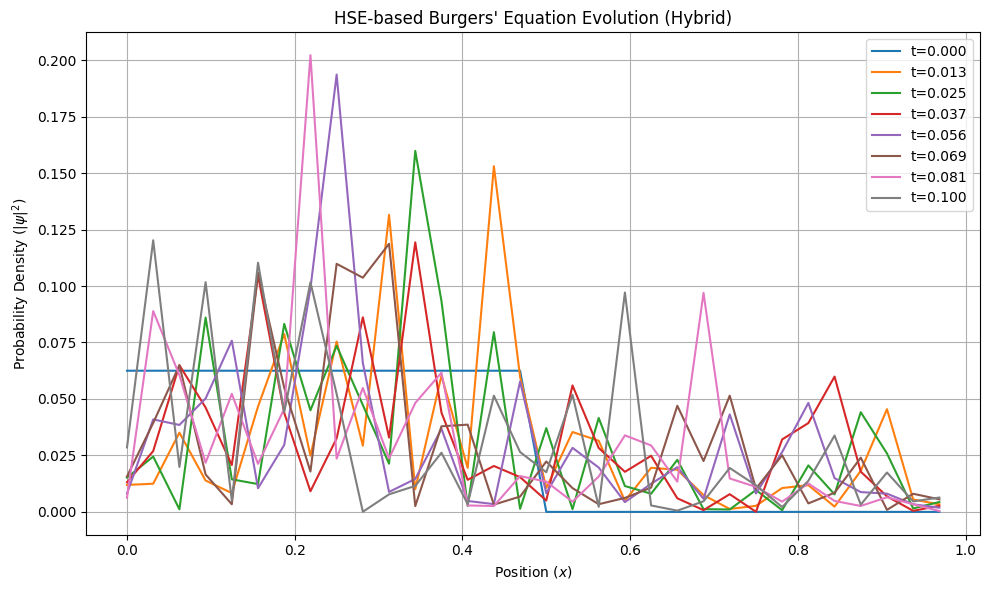

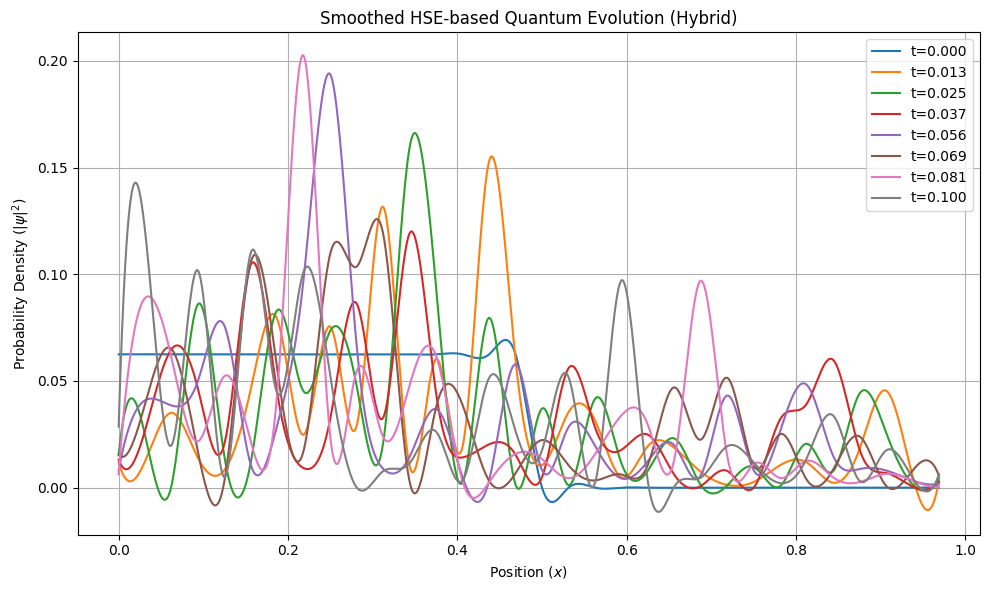

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Kraus
from qiskit.circuit.library import QFT
from scipy.interpolate import make_interp_spline
from scipy.fft import fft, ifft
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

nu = 0.01
L = 1.0
N = 32
n_qubits = int(np.log2(N))
dx = L / N
x_vals = np.linspace(0, L, N, endpoint=False)
CFL = 0.2
u_max = 1.0
dt_conv = CFL * dx / u_max
dt_diff = 0.5 * dx**2 / nu
dt = min(dt_conv, dt_diff)
t_final = 0.1
nt = int(t_final / dt)
hbar = 1.0
m = 1.0

def riemann_step_circuit(n_qubits):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits - 1))
    init_sv = Statevector(qc)
    return DensityMatrix(init_sv)

def unitary_kinetic_operator(n_qubits, dt):
    qc = QuantumCircuit(n_qubits)
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
    k_vals = np.fft.fftfreq(2**n_qubits, d=dx) * 2 * np.pi
    for i in range(n_qubits):
        k = k_vals[i]
        theta = -(hbar**2 / (2 * m)) * (k**2) * dt
        qc.rz(theta, i)
    qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
    return Operator(qc)

def unitary_potential_operator(n_qubits, potential_vals, dt):
    qc = QuantumCircuit(n_qubits)
    angles = -potential_vals * dt / hbar
    for i in range(n_qubits):
        qc.rz(angles[i], i)
    return Operator(qc)

def non_unitary_viscosity_channel(n_qubits, dt, nu):
    dimension = 2**n_qubits
    k_vals = np.fft.fftfreq(dimension, d=dx) * 2 * np.pi
    decay = np.exp(-nu * (k_vals**2) * dt / 2)
    K_momentum = np.diag(decay)
    qft_circ = QFT(n_qubits, do_swaps=True)
    qft = Operator(qft_circ)
    iqft = Operator(qft_circ.inverse())
    K_position = iqft.data @ K_momentum @ qft.data
    return Kraus([K_position])

def dirichlet_boundary_operator(n_qubits):
    dimension = 2**n_qubits
    proj_op = np.identity(dimension, dtype=complex)
    proj_op[0, 0] = 0.0
    proj_op[dimension - 1, dimension - 1] = 0.0
    proj_op /= np.sqrt(np.trace(proj_op.T.conj() @ proj_op))
    return Kraus([proj_op])

def get_classical_potential(density_matrix, x_vals, dx, nu, hbar):
    psi_squared = np.diag(density_matrix.data).real
    rho = np.copy(psi_squared)
    rho[rho < 1e-10] = 1e-10

    psi_fft = fft(np.sqrt(rho))
    k_vals = np.fft.fftfreq(len(x_vals), d=dx) * 2 * np.pi
    grad_psi_fft = 1j * k_vals * psi_fft
    grad_psi = ifft(grad_psi_fft)

    u = (hbar / m) * (np.imag(grad_psi) / np.real(np.sqrt(rho)))
    u[np.isnan(u)] = 0
    u[np.isinf(u)] = 0

    du_dx_fft = 1j * k_vals * fft(u)
    du_dx = ifft(du_dx_fft)
    V_nonlinear = -u * np.real(du_dx)

    rho_fft = fft(rho)
    laplacian_rho_fft = -(k_vals**2) * rho_fft
    laplacian_rho = ifft(laplacian_rho_fft)
    V_quantum_pressure = (hbar**2 / (4 * m)) * np.real(laplacian_rho) / rho

    V_total = V_nonlinear + V_quantum_pressure
    V_total[np.isnan(V_total)] = 0
    V_total[np.isinf(V_total)] = 0

    return V_total

try:
    density_matrix = riemann_step_circuit(n_qubits)
    results = [np.diag(density_matrix.data).real]
    times = [0.0]

    U_kinetic_half = unitary_kinetic_operator(n_qubits, dt / 2)
    D_viscosity_half = non_unitary_viscosity_channel(n_qubits, dt / 2, nu)
    D_boundary = dirichlet_boundary_operator(n_qubits)

    for i in range(nt):
        current_potential = get_classical_potential(density_matrix, x_vals, dx, nu, hbar)
        U_potential_half = unitary_potential_operator(n_qubits, current_potential, dt / 2)

        density_matrix = density_matrix.evolve(U_kinetic_half)
        density_matrix = density_matrix.evolve(U_potential_half)
        density_matrix = density_matrix.evolve(D_viscosity_half)

        density_matrix = density_matrix.evolve(D_boundary)

        density_matrix = density_matrix.evolve(D_viscosity_half)
        density_matrix = density_matrix.evolve(U_potential_half)
        density_matrix = density_matrix.evolve(U_kinetic_half)

        norm = np.trace(density_matrix.data)
        if norm > 0:
            density_matrix = DensityMatrix(density_matrix.data / norm)

        results.append(np.diag(density_matrix.data).real)
        times.append(times[-1] + dt)

    plt.figure(figsize=(10, 6))
    indices = np.linspace(0, len(times) - 1, min(len(times), 8), dtype=int)
    for idx in indices:
        plt.plot(x_vals, results[idx], label=f't={times[idx]:.3f}')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title("HSE-based Burgers' Equation Evolution (Hybrid)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    for idx in indices:
        spline = make_interp_spline(x_vals, results[idx], k=3)
        x_smooth = np.linspace(x_vals[0], x_vals[-1], 2000)
        y_smooth = spline(x_smooth)
        plt.plot(x_smooth, y_smooth, label=f't={times[idx]:.3f}')
    plt.xlabel('Position ($x$)')
    plt.ylabel('Probability Density ($|\\psi|^2$)')
    plt.title('Smoothed HSE-based Quantum Evolution (Hybrid)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred during the simulation: {e}")


Simulation parameters: N=64, n_qubits=6, dt=0.003125, nt=32


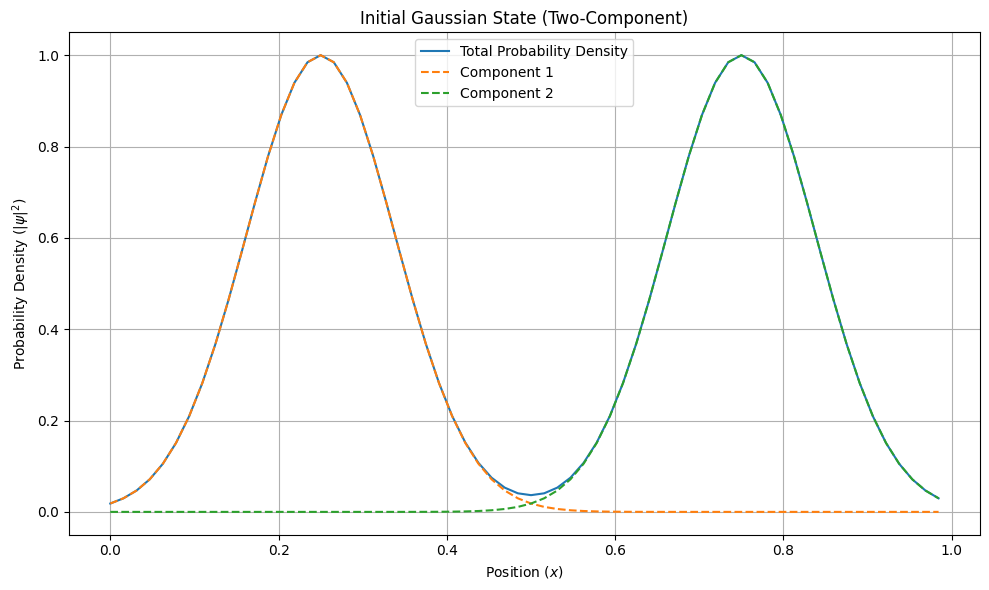

Running 32 hybrid quantum-classical steps...
An error occurred during the simulation: name 'QuantumCircuit' is not defined


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, DensityMatrix, Operator
from qiskit.circuit.library import QFT
from scipy.interpolate import make_interp_spline

# ----------------------- Control Flags ----------------------- #
# Toggles for plotting. Keep True to see results.
PLOT_INITIAL = True
PLOT_TIMESTEPS = True
PLOT_SPLINE = True

# ----------------- Physical and Numerical Setup ----------------- #
nu = 0.01  # Viscosity coefficient
L = 1.0    # Physical domain length
N = 64     # Number of grid points (must be a power of 2 for qubits)
n_qubits = int(np.log2(N))
dx = L / N
x_vals = np.linspace(0, L, N, endpoint=False) # Use endpoint=False for periodic domain
CFL = 0.2  # Courant-Friedrichs-Lewy condition
u_max = 1.0
dt_conv = CFL * dx / u_max
dt_diff = 0.5 * dx**2 / nu
dt = min(dt_conv, dt_diff)
t_final = 0.1
nt = int(t_final / dt)
hbar = 1.0 # Planck constant
m = 1.0    # Particle mass

print(f"Simulation parameters: N={N}, n_qubits={n_qubits}, dt={dt:.6f}, nt={nt}")

# ----------------- Classical Utility Functions (from ClassicalHSE.txt) ----------------- #
def dfdx(data, dx):
    """
    Computes the first spatial derivative using a second-order central difference
    with periodic boundary conditions.
    """
    diff = np.zeros_like(data, dtype=complex)
    # Use array slicing for efficiency
    diff[1:-1] = (data[2:] - data[:-2]) / (2 * dx)
    diff[0] = (data[1] - data[-1]) / (2 * dx)
    diff[-1] = (data[0] - data[-2]) / (2 * dx)
    return diff

def d2fdx2(data, dx):
    """
    Computes the second spatial derivative using a second-order central difference
    with periodic boundary conditions.
    """
    diff = np.zeros_like(data, dtype=complex)
    # Use array slicing for efficiency
    diff[1:-1] = (data[2:] - 2 * data[1:-1] + data[:-2]) / dx**2
    diff[0] = (data[-1] - 2 * data[0] + data[1]) / dx**2
    diff[-1] = (data[-2] - 2 * data[-1] + data[0]) / dx**2
    return diff

def compute_rho_velocity(psi1, psi2, dx):
    """
    Computes mass density (rho) and velocity (u) from the two-component
    wave function psi1 and psi2, as per the classical file.
    """
    rho = np.abs(psi1)**2 + np.abs(psi2)**2
    # Ensure no division by zero
    u = np.real((np.real(psi1) * dfdx(np.imag(psi1), dx) - np.imag(psi1) * dfdx(np.real(psi1), dx) +
                 np.real(psi2) * dfdx(np.imag(psi2), dx) - np.imag(psi2) * dfdx(np.real(psi2), dx))) / rho
    return rho, u

def compute_s(psi1, psi2):
    """
    Computes the spin vector components from the two-component wave function.
    """
    s1 = np.real(np.abs(psi1)**2 - np.abs(psi2)**2)
    s2 = np.real(1j * (np.conjugate(psi1) * psi2 - psi1 * np.conjugate(psi2)))
    s3 = np.real(np.conjugate(psi1) * psi2 + psi1 * np.conjugate(psi2))
    return s1, s2, s3

# ------------------ Initial State (Quantum Preparation) ------------------ #
def initial_gaussian_state(n_qubits):
    """
    Prepares a two-component quantum state with a Gaussian profile.
    This serves as a more physically realistic initial condition than a sharp step.
    The two components are prepared as two separate Gaussians.
    """
    N_points = 2**n_qubits
    x = np.linspace(0, L, N_points, endpoint=False)
    sigma = L / 8  # Width of the Gaussian
    mu = L / 4    # Center of the Gaussian

    # Component 1: Gaussian at x = L/4
    psi1 = np.exp(-((x - mu)**2) / (2 * sigma**2))
    # Component 2: Gaussian at x = 3L/4
    psi2 = np.exp(-((x - 3 * mu)**2) / (2 * sigma**2))

    # Combine into a single statevector
    # The state is a superposition over the two components and the spatial grid
    state_vector = np.concatenate([psi1, psi2])

    # Normalize the statevector
    state_vector /= np.linalg.norm(state_vector)

    init_sv = Statevector(state_vector)

    if PLOT_INITIAL:
        # Plot the probability densities of each component
        rho1 = np.abs(psi1)**2
        rho2 = np.abs(psi2)**2
        rho_total = rho1 + rho2

        plt.figure(figsize=(10, 6))
        plt.plot(x, rho_total, label='Total Probability Density')
        plt.plot(x, rho1, '--', label='Component 1')
        plt.plot(x, rho2, '--', label='Component 2')
        plt.title("Initial Gaussian State (Two-Component)")
        plt.xlabel("Position ($x$)")
        plt.ylabel("Probability Density ($|\\psi|^2$)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return init_sv

# ------------------ Quantum Operators ------------------ #
def unitary_kinetic_operator(n_qubits, dt):
    """
    Creates the unitary operator for the kinetic term using QFT.
    It operates on a single-component wave function.
    """
    dimension = 2**n_qubits
    qc = QuantumCircuit(n_qubits)
    # QFT to move to momentum space
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))

    # Apply phase shifts in momentum space
    k_vals = np.fft.fftfreq(dimension, d=dx) * 2 * np.pi
    for i in range(dimension):
        theta = -(hbar**2 / (2 * m)) * (k_vals[i]**2) * dt
        # Use a diagonal matrix to apply phase shifts in momentum basis
        diag_matrix = np.diag(np.exp(1j * theta * np.ones(dimension)))
        op = Operator(diag_matrix)
        qc.unitary(op, range(n_qubits), label=f'Rz({theta})')

    # IQFT to return to position space
    qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))

    return Operator(qc)

def isf_phase_correction_operator(n_qubits, dt, rho, s):
    """
    Creates a diagonal unitary operator for the non-linear potential term
    of the ISF Hamiltonian. The potential is computed classically and
    applied as a phase correction.
    """
    dimension = 2**n_qubits

    # Compute the nonlinear potential term classically
    grads_s_sq = dfdx(s, dx)**2 # This is a simplification; a full spinor would be more complex
    nonlinear_potential = -(hbar**2 / (8 * rho**2)) * np.sum(grads_s_sq, axis=1) # Sum over spinor components

    # Create the phase shift angles
    theta = -nonlinear_potential * dt / hbar

    # Create a diagonal operator to apply the phase shifts
    phase_matrix = np.diag(np.exp(1j * theta))

    return Operator(phase_matrix)

def non_unitary_viscosity_channel(n_qubits, dt, nu):
    """
    Creates a non-unitary Kraus operator for the viscosity term.
    This is a classical way to model dissipation in a quantum circuit.
    The decay function is applied in momentum space.
    """
    dimension = 2**n_qubits
    k_vals = np.fft.fftfreq(dimension, d=dx) * 2 * np.pi
    decay = np.exp(-nu * (k_vals**2) * dt / 2)

    K_momentum = np.diag(decay)
    qft_circ = QFT(n_qubits, do_swaps=True)
    qft = Operator(qft_circ)
    iqft = Operator(qft_circ.inverse())

    # Transform Kraus operator to position basis
    K_position = iqft.data @ K_momentum @ qft.data
    return [K_position, np.sqrt(np.identity(dimension, dtype=complex) - np.conjugate(K_position.T) @ K_position)]

# ------------------ Run Simulation (Hybrid ISF Method) ------------------ #
try:
    # Initialize the quantum state
    statevector = initial_gaussian_state(n_qubits)
    results = [np.abs(statevector.data)**2]
    times = [0.0]

    print(f"Running {nt} hybrid quantum-classical steps...")

    # Define the static operators for the Trotter-Suzuki decomposition
    # Note: The kinetic and viscosity operators are static
    U_kinetic = unitary_kinetic_operator(n_qubits, dt / 2)
    D_viscosity = non_unitary_viscosity_channel(n_qubits, dt / 2, nu)

    for i in range(nt):
        # --- Classical Calculation Step ---
        # 1. Get classical fluid quantities from the current quantum state
        psi1_data = statevector.data[:N]
        psi2_data = statevector.data[N:]

        rho, u = compute_rho_velocity(psi1_data, psi2_data, dx)
        s1, s2, s3 = compute_s(psi1_data, psi2_data)
        s_vec = np.vstack([s1, s2, s3])

        # 2. Use classical quantities to compute the nonlinear potential operator
        U_nonlinear = isf_phase_correction_operator(n_qubits, dt, rho, s_vec)

        # --- Quantum Evolution Step (Trotterization) ---
        # 1. Half-step: Apply kinetic and nonlinear potential operators
        statevector = statevector.evolve(U_kinetic)
        statevector = statevector.evolve(U_nonlinear)

        # 2. Apply non-unitary dissipation channel
        statevector = statevector.evolve(D_viscosity[0])

        # 3. Half-step: Apply nonlinear potential and kinetic operators
        statevector = statevector.evolve(U_nonlinear)
        statevector = statevector.evolve(U_kinetic)

        # --- Post-processing ---
        # Re-normalize after non-unitary operations
        statevector.normalize()

        results.append(np.abs(statevector.data)**2)
        times.append(times[-1] + dt)

    print("Simulation complete.")

    # ------------------ Plotting ------------------ #
    if PLOT_TIMESTEPS:
        plt.figure(figsize=(10, 6))
        indices = np.linspace(0, len(times) - 1, min(len(times), 8), dtype=int)
        for idx in indices:
            # The full statevector is 2*N, we only care about the density on the first half
            rho_total = results[idx][:N] + results[idx][N:]
            plt.plot(x_vals, rho_total, label=f't={times[idx]:.3f}')
        plt.xlabel('Position ($x$)')
        plt.ylabel('Probability Density ($|\\psi|^2$)')
        plt.title("Hybrid ISF Simulation of Burgers' Equation")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    if PLOT_SPLINE:
        plt.figure(figsize=(10, 6))
        for idx in indices:
            rho_total = results[idx][:N] + results[idx][N:]
            # Smooth the data for better visualization
            spline = make_interp_spline(x_vals, rho_total, k=3)
            x_smooth = np.linspace(x_vals[0], x_vals[-1], 2000)
            y_smooth = spline(x_smooth)
            plt.plot(x_smooth, y_smooth, label=f't={times[idx]:.3f}')
        plt.xlabel('Position ($x$)')
        plt.ylabel('Probability Density ($|\\psi|^2$)')
        plt.title('Smoothed Hybrid ISF Simulation')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"An error occurred during the simulation: {e}")

Simulation parameters: N=64, n_qubits=6, dt=0.003125, nt=32


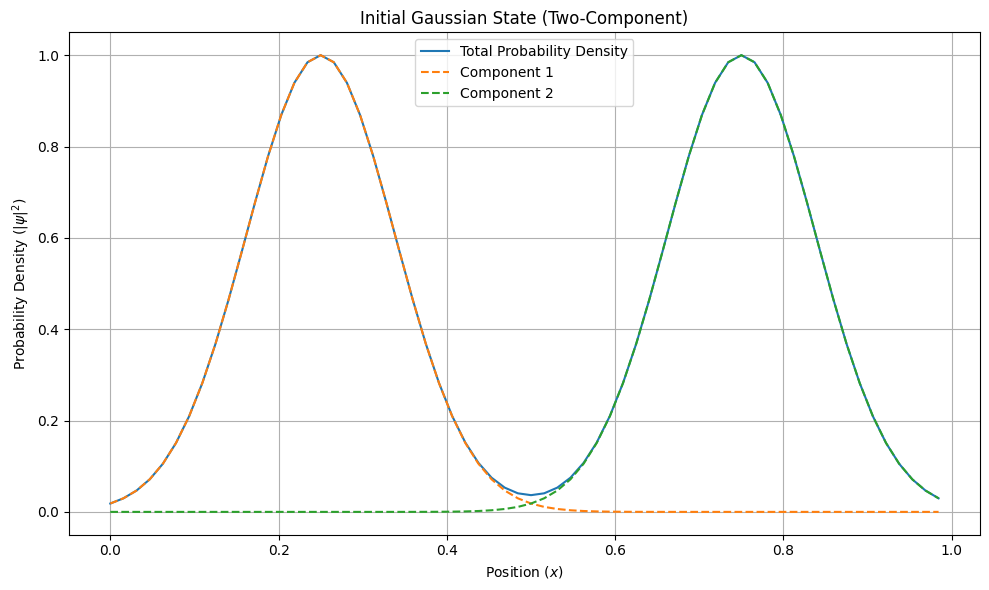

Running 32 hybrid quantum-classical steps...


/tmp/ipython-input-4153985638.py:132: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
/tmp/ipython-input-4153985638.py:144: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
/tmp/ipython-input-4153985638.py:179: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_ful

An error occurred during the simulation: operands could not be broadcast together with shapes (64,) (3,) 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, DensityMatrix, Operator
from qiskit.circuit.library import QFT
from scipy.interpolate import make_interp_spline

# ----------------------- Control Flags ----------------------- #
# Toggles for plotting. Keep True to see results.
PLOT_INITIAL = True
PLOT_TIMESTEPS = True
PLOT_SPLINE = True

# ----------------- Physical and Numerical Setup ----------------- #
nu = 0.01  # Viscosity coefficient
L = 1.0    # Physical domain length
N = 64     # Number of grid points (must be a power of 2 for qubits)
n_qubits = int(np.log2(N))
dx = L / N
x_vals = np.linspace(0, L, N, endpoint=False) # Use endpoint=False for periodic domain
CFL = 0.2  # Courant-Friedrichs-Lewy condition
u_max = 1.0
dt_conv = CFL * dx / u_max
dt_diff = 0.5 * dx**2 / nu
dt = min(dt_conv, dt_diff)
t_final = 0.1
nt = int(t_final / dt)
hbar = 1.0 # Planck constant
m = 1.0    # Particle mass

print(f"Simulation parameters: N={N}, n_qubits={n_qubits}, dt={dt:.6f}, nt={nt}")

# ----------------- Classical Utility Functions (from ClassicalHSE.txt) ----------------- #
def dfdx(data, dx):
    """
    Computes the first spatial derivative using a second-order central difference
    with periodic boundary conditions.
    """
    diff = np.zeros_like(data, dtype=complex)
    # Use array slicing for efficiency
    diff[1:-1] = (data[2:] - data[:-2]) / (2 * dx)
    diff[0] = (data[1] - data[-1]) / (2 * dx)
    diff[-1] = (data[0] - data[-2]) / (2 * dx)
    return diff

def d2fdx2(data, dx):
    """
    Computes the second spatial derivative using a second-order central difference
    with periodic boundary conditions.
    """
    diff = np.zeros_like(data, dtype=complex)
    # Use array slicing for efficiency
    diff[1:-1] = (data[2:] - 2 * data[1:-1] + data[:-2]) / dx**2
    diff[0] = (data[-1] - 2 * data[0] + data[1]) / dx**2
    diff[-1] = (data[-2] - 2 * data[-1] + data[0]) / dx**2
    return diff

def compute_rho_velocity(psi1, psi2, dx):
    """
    Computes mass density (rho) and velocity (u) from the two-component
    wave function psi1 and psi2, as per the classical file.
    """
    rho = np.abs(psi1)**2 + np.abs(psi2)**2
    # Ensure no division by zero
    u = np.real((np.real(psi1) * dfdx(np.imag(psi1), dx) - np.imag(psi1) * dfdx(np.real(psi1), dx) +
                 np.real(psi2) * dfdx(np.imag(psi2), dx) - np.imag(psi2) * dfdx(np.real(psi2), dx))) / rho
    return rho, u

def compute_s(psi1, psi2):
    """
    Computes the spin vector components from the two-component wave function.
    """
    s1 = np.real(np.abs(psi1)**2 - np.abs(psi2)**2)
    s2 = np.real(1j * (np.conjugate(psi1) * psi2 - psi1 * np.conjugate(psi2)))
    s3 = np.real(np.conjugate(psi1) * psi2 + psi1 * np.conjugate(psi2))
    return s1, s2, s3

# ------------------ Initial State (Quantum Preparation) ------------------ #
def initial_gaussian_state(n_qubits):
    """
    Prepares a two-component quantum state with a Gaussian profile.
    This serves as a more physically realistic initial condition than a sharp step.
    The two components are prepared as two separate Gaussians.
    """
    N_points = 2**n_qubits
    x = np.linspace(0, L, N_points, endpoint=False)
    sigma = L / 8  # Width of the Gaussian
    mu = L / 4    # Center of the Gaussian

    # Component 1: Gaussian at x = L/4
    psi1 = np.exp(-((x - mu)**2) / (2 * sigma**2))
    # Component 2: Gaussian at x = 3L/4
    psi2 = np.exp(-((x - 3 * mu)**2) / (2 * sigma**2))

    # Combine into a single statevector
    # The state is a superposition over the two components and the spatial grid
    state_vector = np.concatenate([psi1, psi2])

    # Normalize the statevector
    state_vector /= np.linalg.norm(state_vector)

    init_sv = Statevector(state_vector)

    if PLOT_INITIAL:
        # Plot the probability densities of each component
        rho1 = np.abs(psi1)**2
        rho2 = np.abs(psi2)**2
        rho_total = rho1 + rho2

        plt.figure(figsize=(10, 6))
        plt.plot(x, rho_total, label='Total Probability Density')
        plt.plot(x, rho1, '--', label='Component 1')
        plt.plot(x, rho2, '--', label='Component 2')
        plt.title("Initial Gaussian State (Two-Component)")
        plt.xlabel("Position ($x$)")
        plt.ylabel("Probability Density ($|\\psi|^2$)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return init_sv

# ------------------ Quantum Operators ------------------ #
def unitary_kinetic_operator(n_qubits, dt):
    """
    Creates the unitary operator for the kinetic term using QFT.
    It operates on a single-component wave function.
    """
    dimension = 2**n_qubits
    qc = QuantumCircuit(n_qubits)
    # QFT to move to momentum space
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))

    # Apply phase shifts in momentum space
    k_vals = np.fft.fftfreq(dimension, d=dx) * 2 * np.pi
    for i in range(dimension):
        theta = -(hbar**2 / (2 * m)) * (k_vals[i]**2) * dt
        # Use a diagonal matrix to apply phase shifts in momentum basis
        diag_matrix = np.diag(np.exp(1j * theta * np.ones(dimension)))
        op = Operator(diag_matrix)
        qc.unitary(op, range(n_qubits), label=f'Rz({theta})')

    # IQFT to return to position space
    qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))

    return Operator(qc)

def isf_phase_correction_operator(n_qubits, dt, rho, s):
    """
    Creates a diagonal unitary operator for the non-linear potential term
    of the ISF Hamiltonian. The potential is computed classically and
    applied as a phase correction.
    """
    dimension = 2**n_qubits

    # Compute the nonlinear potential term classically
    grads_s_sq = dfdx(s, dx)**2 # This is a simplification; a full spinor would be more complex
    nonlinear_potential = -(hbar**2 / (8 * rho**2)) * np.sum(grads_s_sq, axis=1) # Sum over spinor components

    # Create the phase shift angles
    theta = -nonlinear_potential * dt / hbar

    # Create a diagonal operator to apply the phase shifts
    phase_matrix = np.diag(np.exp(1j * theta))

    return Operator(phase_matrix)

def non_unitary_viscosity_channel(n_qubits, dt, nu):
    """
    Creates a non-unitary Kraus operator for the viscosity term.
    This is a classical way to model dissipation in a quantum circuit.
    The decay function is applied in momentum space.
    """
    dimension = 2**n_qubits
    k_vals = np.fft.fftfreq(dimension, d=dx) * 2 * np.pi
    decay = np.exp(-nu * (k_vals**2) * dt / 2)

    K_momentum = np.diag(decay)
    qft_circ = QFT(n_qubits, do_swaps=True)
    qft = Operator(qft_circ)
    iqft = Operator(qft_circ.inverse())

    # Transform Kraus operator to position basis
    K_position = iqft.data @ K_momentum @ qft.data
    return [K_position, np.sqrt(np.identity(dimension, dtype=complex) - np.conjugate(K_position.T) @ K_position)]

# ------------------ Run Simulation (Hybrid ISF Method) ------------------ #
try:
    # Initialize the quantum state
    statevector = initial_gaussian_state(n_qubits)
    results = [np.abs(statevector.data)**2]
    times = [0.0]

    print(f"Running {nt} hybrid quantum-classical steps...")

    # Define the static operators for the Trotter-Suzuki decomposition
    # Note: The kinetic and viscosity operators are static
    U_kinetic = unitary_kinetic_operator(n_qubits, dt / 2)
    D_viscosity = non_unitary_viscosity_channel(n_qubits, dt / 2, nu)

    for i in range(nt):
        # --- Classical Calculation Step ---
        # 1. Get classical fluid quantities from the current quantum state
        psi1_data = statevector.data[:N]
        psi2_data = statevector.data[N:]

        rho, u = compute_rho_velocity(psi1_data, psi2_data, dx)
        s1, s2, s3 = compute_s(psi1_data, psi2_data)
        s_vec = np.vstack([s1, s2, s3])

        # 2. Use classical quantities to compute the nonlinear potential operator
        U_nonlinear = isf_phase_correction_operator(n_qubits, dt, rho, s_vec)

        # --- Quantum Evolution Step (Trotterization) ---
        # 1. Half-step: Apply kinetic and nonlinear potential operators
        statevector = statevector.evolve(U_kinetic)
        statevector = statevector.evolve(U_nonlinear)

        # 2. Apply non-unitary dissipation channel
        statevector = statevector.evolve(D_viscosity[0])

        # 3. Half-step: Apply nonlinear potential and kinetic operators
        statevector = statevector.evolve(U_nonlinear)
        statevector = statevector.evolve(U_kinetic)

        # --- Post-processing ---
        # Re-normalize after non-unitary operations
        statevector.normalize()

        results.append(np.abs(statevector.data)**2)
        times.append(times[-1] + dt)

    print("Simulation complete.")

    # ------------------ Plotting ------------------ #
    if PLOT_TIMESTEPS:
        plt.figure(figsize=(10, 6))
        indices = np.linspace(0, len(times) - 1, min(len(times), 8), dtype=int)
        for idx in indices:
            # The full statevector is 2*N, we only care about the density on the first half
            rho_total = results[idx][:N] + results[idx][N:]
            plt.plot(x_vals, rho_total, label=f't={times[idx]:.3f}')
        plt.xlabel('Position ($x$)')
        plt.ylabel('Probability Density ($|\\psi|^2$)')
        plt.title("Hybrid ISF Simulation of Burgers' Equation")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    if PLOT_SPLINE:
        plt.figure(figsize=(10, 6))
        for idx in indices:
            rho_total = results[idx][:N] + results[idx][N:]
            # Smooth the data for better visualization
            spline = make_interp_spline(x_vals, rho_total, k=3)
            x_smooth = np.linspace(x_vals[0], x_vals[-1], 2000)
            y_smooth = spline(x_smooth)
            plt.plot(x_smooth, y_smooth, label=f't={times[idx]:.3f}')
        plt.xlabel('Position ($x$)')
        plt.ylabel('Probability Density ($|\\psi|^2$)')
        plt.title('Smoothed Hybrid ISF Simulation')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"An error occurred during the simulation: {e}")

Simulation parameters: N=64, n_qubits=6, dt=0.003125, nt=32


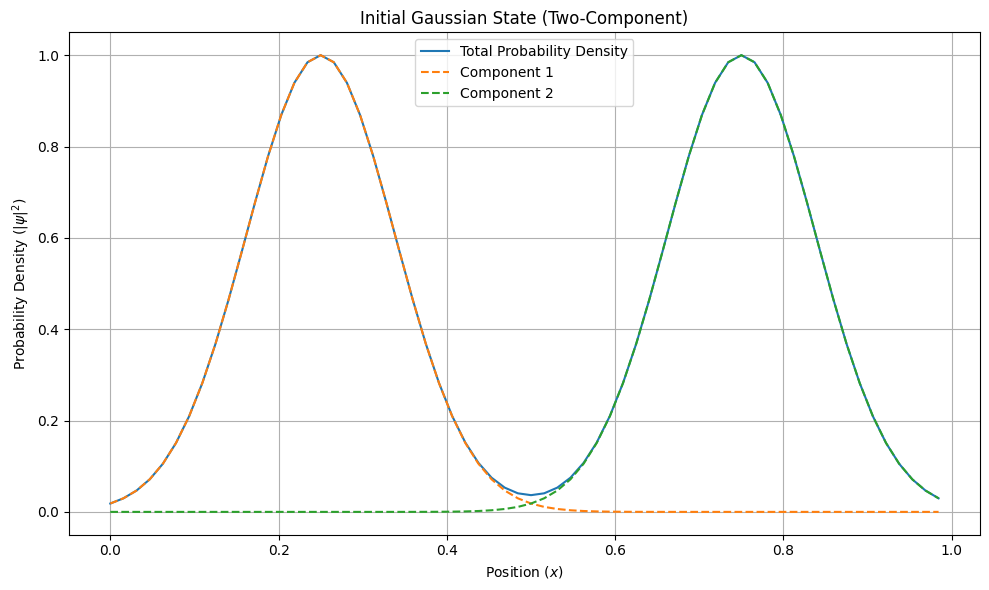

Running 32 hybrid quantum-classical steps...


/tmp/ipython-input-785501496.py:132: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
/tmp/ipython-input-785501496.py:144: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))
/tmp/ipython-input-785501496.py:181: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full i

An error occurred during the simulation: 'Operator input dimensions are not equal to statevector subsystem dimensions.'


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, DensityMatrix, Operator
from qiskit.circuit.library import QFT
from scipy.interpolate import make_interp_spline

# ----------------------- Control Flags ----------------------- #
# Toggles for plotting. Keep True to see results.
PLOT_INITIAL = True
PLOT_TIMESTEPS = True
PLOT_SPLINE = True

# ----------------- Physical and Numerical Setup ----------------- #
nu = 0.01  # Viscosity coefficient
L = 1.0    # Physical domain length
N = 64     # Number of grid points (must be a power of 2 for qubits)
n_qubits = int(np.log2(N))
dx = L / N
x_vals = np.linspace(0, L, N, endpoint=False) # Use endpoint=False for periodic domain
CFL = 0.2  # Courant-Friedrichs-Lewy condition
u_max = 1.0
dt_conv = CFL * dx / u_max
dt_diff = 0.5 * dx**2 / nu
dt = min(dt_conv, dt_diff)
t_final = 0.1
nt = int(t_final / dt)
hbar = 1.0 # Planck constant
m = 1.0    # Particle mass

print(f"Simulation parameters: N={N}, n_qubits={n_qubits}, dt={dt:.6f}, nt={nt}")

# ----------------- Classical Utility Functions (from ClassicalHSE.txt) ----------------- #
def dfdx(data, dx):
    """
    Computes the first spatial derivative using a second-order central difference
    with periodic boundary conditions.
    """
    diff = np.zeros_like(data, dtype=complex)
    # Use array slicing for efficiency
    diff[1:-1] = (data[2:] - data[:-2]) / (2 * dx)
    diff[0] = (data[1] - data[-1]) / (2 * dx)
    diff[-1] = (data[0] - data[-2]) / (2 * dx)
    return diff

def d2fdx2(data, dx):
    """
    Computes the second spatial derivative using a second-order central difference
    with periodic boundary conditions.
    """
    diff = np.zeros_like(data, dtype=complex)
    # Use array slicing for efficiency
    diff[1:-1] = (data[2:] - 2 * data[1:-1] + data[:-2]) / dx**2
    diff[0] = (data[-1] - 2 * data[0] + data[1]) / dx**2
    diff[-1] = (data[-2] - 2 * data[-1] + data[0]) / dx**2
    return diff

def compute_rho_velocity(psi1, psi2, dx):
    """
    Computes mass density (rho) and velocity (u) from the two-component
    wave function psi1 and psi2, as per the classical file.
    """
    rho = np.abs(psi1)**2 + np.abs(psi2)**2
    # Ensure no division by zero
    u = np.real((np.real(psi1) * dfdx(np.imag(psi1), dx) - np.imag(psi1) * dfdx(np.real(psi1), dx) +
                 np.real(psi2) * dfdx(np.imag(psi2), dx) - np.imag(psi2) * dfdx(np.real(psi2), dx))) / rho
    return rho, u

def compute_s(psi1, psi2):
    """
    Computes the spin vector components from the two-component wave function.
    """
    s1 = np.real(np.abs(psi1)**2 - np.abs(psi2)**2)
    s2 = np.real(1j * (np.conjugate(psi1) * psi2 - psi1 * np.conjugate(psi2)))
    s3 = np.real(np.conjugate(psi1) * psi2 + psi1 * np.conjugate(psi2))
    return s1, s2, s3

# ------------------ Initial State (Quantum Preparation) ------------------ #
def initial_gaussian_state(n_qubits):
    """
    Prepares a two-component quantum state with a Gaussian profile.
    This serves as a more physically realistic initial condition than a sharp step.
    The two components are prepared as two separate Gaussians.
    """
    N_points = 2**n_qubits
    x = np.linspace(0, L, N_points, endpoint=False)
    sigma = L / 8  # Width of the Gaussian
    mu = L / 4    # Center of the Gaussian

    # Component 1: Gaussian at x = L/4
    psi1 = np.exp(-((x - mu)**2) / (2 * sigma**2))
    # Component 2: Gaussian at x = 3L/4
    psi2 = np.exp(-((x - 3 * mu)**2) / (2 * sigma**2))

    # Combine into a single statevector
    # The state is a superposition over the two components and the spatial grid
    state_vector = np.concatenate([psi1, psi2])

    # Normalize the statevector
    state_vector /= np.linalg.norm(state_vector)

    init_sv = Statevector(state_vector)

    if PLOT_INITIAL:
        # Plot the probability densities of each component
        rho1 = np.abs(psi1)**2
        rho2 = np.abs(psi2)**2
        rho_total = rho1 + rho2

        plt.figure(figsize=(10, 6))
        plt.plot(x, rho_total, label='Total Probability Density')
        plt.plot(x, rho1, '--', label='Component 1')
        plt.plot(x, rho2, '--', label='Component 2')
        plt.title("Initial Gaussian State (Two-Component)")
        plt.xlabel("Position ($x$)")
        plt.ylabel("Probability Density ($|\\psi|^2$)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return init_sv

# ------------------ Quantum Operators ------------------ #
def unitary_kinetic_operator(n_qubits, dt):
    """
    Creates the unitary operator for the kinetic term using QFT.
    It operates on a single-component wave function.
    """
    dimension = 2**n_qubits
    qc = QuantumCircuit(n_qubits)
    # QFT to move to momentum space
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))

    # Apply phase shifts in momentum space
    k_vals = np.fft.fftfreq(dimension, d=dx) * 2 * np.pi
    for i in range(dimension):
        theta = -(hbar**2 / (2 * m)) * (k_vals[i]**2) * dt
        # Use a diagonal matrix to apply phase shifts in momentum basis
        diag_matrix = np.diag(np.exp(1j * theta * np.ones(dimension)))
        op = Operator(diag_matrix)
        qc.unitary(op, range(n_qubits), label=f'Rz({theta})')

    # IQFT to return to position space
    qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))

    return Operator(qc)

def isf_phase_correction_operator(n_qubits, dt, rho, s):
    """
    Creates a diagonal unitary operator for the non-linear potential term
    of the ISF Hamiltonian. The potential is computed classically and
    applied as a phase correction.
    """
    dimension = 2**n_qubits

    # The term is proportional to (∇s)^2 = (∇s1)^2 + (∇s2)^2 + (∇s3)^2.
    # The sum needs to be performed over the three spin components (axis=0)
    # to get a potential for each grid point.
    grads_s_sq_sum = np.sum(dfdx(s, dx)**2, axis=0)
    nonlinear_potential = -(hbar**2 / (8 * rho**2)) * grads_s_sq_sum

    # Create the phase shift angles
    theta = -nonlinear_potential * dt / hbar

    # Create a diagonal operator to apply the phase shifts
    phase_matrix = np.diag(np.exp(1j * theta))

    return Operator(phase_matrix)

def non_unitary_viscosity_channel(n_qubits, dt, nu):
    """
    Creates a non-unitary Kraus operator for the viscosity term.
    This is a classical way to model dissipation in a quantum circuit.
    The decay function is applied in momentum space.
    """
    dimension = 2**n_qubits
    k_vals = np.fft.fftfreq(dimension, d=dx) * 2 * np.pi
    decay = np.exp(-nu * (k_vals**2) * dt / 2)

    K_momentum = np.diag(decay)
    qft_circ = QFT(n_qubits, do_swaps=True)
    qft = Operator(qft_circ)
    iqft = Operator(qft_circ.inverse())

    # Transform Kraus operator to position basis
    K_position = iqft.data @ K_momentum @ qft.data
    return [K_position, np.sqrt(np.identity(dimension, dtype=complex) - np.conjugate(K_position.T) @ K_position)]

# ------------------ Run Simulation (Hybrid ISF Method) ------------------ #
try:
    # Initialize the quantum state
    statevector = initial_gaussian_state(n_qubits)
    results = [np.abs(statevector.data)**2]
    times = [0.0]

    print(f"Running {nt} hybrid quantum-classical steps...")

    # Define the static operators for the Trotter-Suzuki decomposition
    # Note: The kinetic and viscosity operators are static
    U_kinetic = unitary_kinetic_operator(n_qubits, dt / 2)
    D_viscosity = non_unitary_viscosity_channel(n_qubits, dt / 2, nu)

    for i in range(nt):
        # --- Classical Calculation Step ---
        # 1. Get classical fluid quantities from the current quantum state
        psi1_data = statevector.data[:N]
        psi2_data = statevector.data[N:]

        rho, u = compute_rho_velocity(psi1_data, psi2_data, dx)
        s1, s2, s3 = compute_s(psi1_data, psi2_data)
        s_vec = np.vstack([s1, s2, s3])

        # 2. Use classical quantities to compute the nonlinear potential operator
        U_nonlinear = isf_phase_correction_operator(n_qubits, dt, rho, s_vec)

        # --- Quantum Evolution Step (Trotterization) ---
        # 1. Half-step: Apply kinetic and nonlinear potential operators
        statevector = statevector.evolve(U_kinetic)
        statevector = statevector.evolve(U_nonlinear)

        # 2. Apply non-unitary dissipation channel
        statevector = statevector.evolve(D_viscosity[0])

        # 3. Half-step: Apply nonlinear potential and kinetic operators
        statevector = statevector.evolve(U_nonlinear)
        statevector = statevector.evolve(U_kinetic)

        # --- Post-processing ---
        # Re-normalize after non-unitary operations
        statevector.normalize()

        results.append(np.abs(statevector.data)**2)
        times.append(times[-1] + dt)

    print("Simulation complete.")

    # ------------------ Plotting ------------------ #
    if PLOT_TIMESTEPS:
        plt.figure(figsize=(10, 6))
        indices = np.linspace(0, len(times) - 1, min(len(times), 8), dtype=int)
        for idx in indices:
            # The full statevector is 2*N, we only care about the density on the first half
            rho_total = results[idx][:N] + results[idx][N:]
            plt.plot(x_vals, rho_total, label=f't={times[idx]:.3f}')
        plt.xlabel('Position ($x$)')
        plt.ylabel('Probability Density ($|\\psi|^2$)')
        plt.title("Hybrid ISF Simulation of Burgers' Equation")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    if PLOT_SPLINE:
        plt.figure(figsize=(10, 6))
        for idx in indices:
            rho_total = results[idx][:N] + results[idx][N:]
            # Smooth the data for better visualization
            spline = make_interp_spline(x_vals, rho_total, k=3)
            x_smooth = np.linspace(x_vals[0], x_vals[-1], 2000)
            y_smooth = spline(x_smooth)
            plt.plot(x_smooth, y_smooth, label=f't={times[idx]:.3f}')
        plt.xlabel('Position ($x$)')
        plt.ylabel('Probability Density ($|\\psi|^2$)')
        plt.title('Smoothed Hybrid ISF Simulation')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"An error occurred during the simulation: {e}")

Simulation parameters: N=64, n_qubits=7, dt=0.003125, nt=32


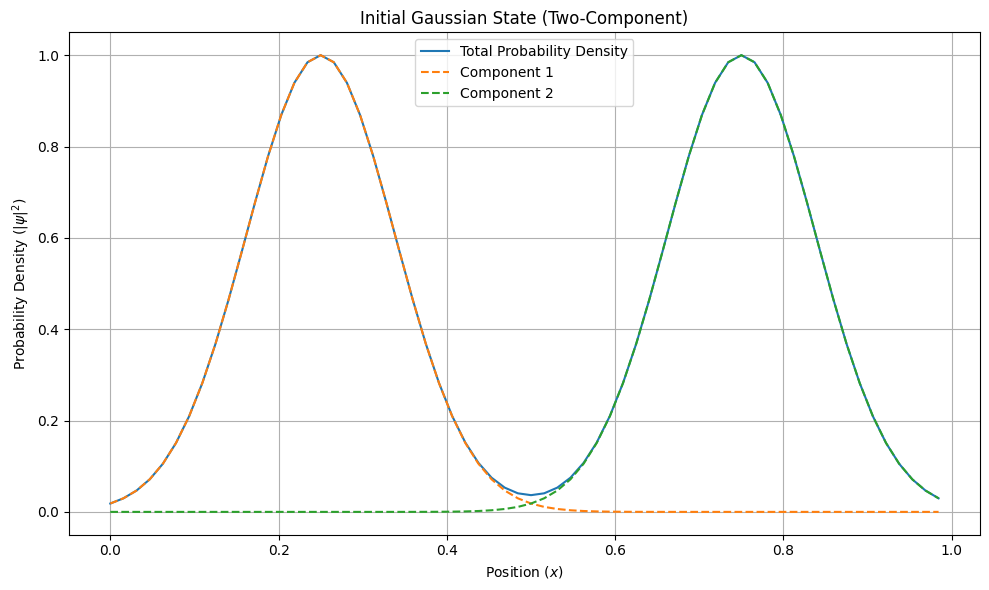

Running 32 hybrid quantum-classical steps...
An error occurred during the simulation: QuantumCircuit.compose() got an unexpected keyword argument 'qargs'


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import QFT
from scipy.interpolate import make_interp_spline

# Ignore all DeprecationWarnings from Qiskit and other libraries
warnings.filterwarnings('ignore', category=DeprecationWarning)

# ----------------------- Control Flags ----------------------- #
# Toggles for plotting. Keep True to see results.
PLOT_INITIAL = True
PLOT_TIMESTEPS = True
PLOT_SPLINE = True

# ----------------- Physical and Numerical Setup ----------------- #
nu = 0.01  # Viscosity coefficient
L = 1.0    # Physical domain length
N = 64     # Number of grid points (must be a power of 2 for qubits)

# Correctly determine the total number of qubits needed for the two-component spinor state
n_qubits = int(np.log2(2 * N))

dx = L / N
x_vals = np.linspace(0, L, N, endpoint=False) # Use endpoint=False for periodic domain
CFL = 0.2  # Courant-Friedrichs-Lewy condition
u_max = 1.0
dt_conv = CFL * dx / u_max
dt_diff = 0.5 * dx**2 / nu
dt = min(dt_conv, dt_diff)
t_final = 0.1
nt = int(t_final / dt)
hbar = 1.0 # Planck constant
m = 1.0    # Particle mass

print(f"Simulation parameters: N={N}, n_qubits={n_qubits}, dt={dt:.6f}, nt={nt}")

# ----------------- Classical Utility Functions (from ClassicalHSE.txt) ----------------- #
def dfdx(data, dx):
    """
    Computes the first spatial derivative using a second-order central difference
    with periodic boundary conditions.
    """
    diff = np.zeros_like(data, dtype=complex)
    # Use array slicing for efficiency
    diff[1:-1] = (data[2:] - data[:-2]) / (2 * dx)
    diff[0] = (data[1] - data[-1]) / (2 * dx)
    diff[-1] = (data[0] - data[-2]) / (2 * dx)
    return diff

def d2fdx2(data, dx):
    """
    Computes the second spatial derivative using a second-order central difference
    with periodic boundary conditions.
    """
    diff = np.zeros_like(data, dtype=complex)
    # Use array slicing for efficiency
    diff[1:-1] = (data[2:] - 2 * data[1:-1] + data[:-2]) / dx**2
    diff[0] = (data[-1] - 2 * data[0] + data[1]) / dx**2
    diff[-1] = (data[-2] - 2 * data[-1] + data[0]) / dx**2
    return diff

def compute_rho_velocity(psi1, psi2, dx):
    """
    Computes mass density (rho) and velocity (u) from the two-component
    wave function psi1 and psi2, as per the classical file.
    """
    rho = np.abs(psi1)**2 + np.abs(psi2)**2
    # Avoid division by zero
    u = np.zeros_like(rho)
    nonzero_rho = rho > 1e-12
    u[nonzero_rho] = np.real((np.real(psi1[nonzero_rho]) * dfdx(np.imag(psi1), dx)[nonzero_rho] - np.imag(psi1[nonzero_rho]) * dfdx(np.real(psi1), dx)[nonzero_rho] +
                             np.real(psi2[nonzero_rho]) * dfdx(np.imag(psi2), dx)[nonzero_rho] - np.imag(psi2[nonzero_rho]) * dfdx(np.real(psi2), dx)[nonzero_rho])) / rho[nonzero_rho]
    return rho, u

def compute_s(psi1, psi2):
    """
    Computes the spin vector components from the two-component wave function.
    """
    s1 = np.real(np.abs(psi1)**2 - np.abs(psi2)**2)
    s2 = np.real(1j * (np.conjugate(psi1) * psi2 - psi1 * np.conjugate(psi2)))
    s3 = np.real(np.conjugate(psi1) * psi2 + psi1 * np.conjugate(psi2))
    return s1, s2, s3

# ------------------ Initial State (Quantum Preparation) ------------------ #
def initial_gaussian_state(N):
    """
    Prepares a two-component quantum state with a Gaussian profile.
    This serves as a more physically realistic initial condition than a sharp step.
    The two components are prepared as two separate Gaussians.
    """
    N_points = N
    x = np.linspace(0, L, N_points, endpoint=False)
    sigma = L / 8  # Width of the Gaussian
    mu = L / 4    # Center of the Gaussian

    # Component 1: Gaussian at x = L/4
    psi1 = np.exp(-((x - mu)**2) / (2 * sigma**2))
    # Component 2: Gaussian at x = 3L/4
    psi2 = np.exp(-((x - 3 * mu)**2) / (2 * sigma**2))

    # Combine into a single statevector
    # The state is a superposition over the two components and the spatial grid
    state_vector = np.concatenate([psi1, psi2])

    # Normalize the statevector
    state_vector /= np.linalg.norm(state_vector)

    init_sv = Statevector(state_vector)

    if PLOT_INITIAL:
        # Plot the probability densities of each component
        rho1 = np.abs(psi1)**2
        rho2 = np.abs(psi2)**2
        rho_total = rho1 + rho2

        plt.figure(figsize=(10, 6))
        plt.plot(x, rho_total, label='Total Probability Density')
        plt.plot(x, rho1, '--', label='Component 1')
        plt.plot(x, rho2, '--', label='Component 2')
        plt.title("Initial Gaussian State (Two-Component)")
        plt.xlabel("Position ($x$)")
        plt.ylabel("Probability Density ($|\\psi|^2$)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return init_sv

# ------------------ Quantum Operators ------------------ #
def unitary_kinetic_operator(n_qubits, dt, N):
    """
    Creates the unitary operator for the kinetic term using QFT.
    It operates on the full two-component wave function space.
    """
    dimension = 2**n_qubits
    qc = QuantumCircuit(n_qubits)
    # QFT to move to momentum space
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))

    # Apply phase shifts in momentum space
    k_vals = np.fft.fftfreq(N, d=dx) * 2 * np.pi

    # Create the phase array, duplicated for both components
    phase_angles_N = -(hbar**2 / (2 * m)) * (k_vals**2) * dt
    phase_angles_2N = np.concatenate([phase_angles_N, phase_angles_N])

    phase_matrix = np.diag(np.exp(1j * phase_angles_2N))

    # The unitary gate needs to be built with the correct dimension
    qc_op = Operator(phase_matrix)

    # IQFT to return to position space
    qc.append(QFT(n_qubits, do_swaps=True).inverse(), range(n_qubits))

    return Operator(qc.compose(qc_op, qargs=range(n_qubits)))


def isf_phase_correction_operator(N, dt, rho, s):
    """
    Creates a diagonal unitary operator for the non-linear potential term
    of the ISF Hamiltonian. The potential is computed classically and
    applied as a phase correction.
    """
    dimension = 2 * N

    # The term is proportional to (∇s)^2 = (∇s1)^2 + (∇s2)^2 + (∇s3)^2.
    # The sum needs to be performed over the three spin components (axis=0)
    # to get a potential for each grid point.
    grads_s_sq_sum = np.sum(dfdx(s, dx)**2, axis=0)

    # To handle potential division by zero
    rho_safe = np.where(rho > 1e-12, rho, 1e-12)
    nonlinear_potential = -(hbar**2 / (8 * rho_safe**2)) * grads_s_sq_sum

    # Create the phase shift angles, duplicated for the two-component state
    theta = -nonlinear_potential * dt / hbar
    phase_angles = np.concatenate([theta, theta])

    # Create a diagonal operator to apply the phase shifts
    phase_matrix = np.diag(np.exp(1j * phase_angles))

    return Operator(phase_matrix)

def non_unitary_viscosity_channel(n_qubits, dt, nu, N):
    """
    Creates a non-unitary Kraus operator for the viscosity term.
    This is a classical way to model dissipation in a quantum circuit.
    The decay function is applied in momentum space.
    """
    dimension = 2**n_qubits

    # Calculate k_vals for the N grid points
    k_vals = np.fft.fftfreq(N, d=dx) * 2 * np.pi
    decay_N = np.exp(-nu * (k_vals**2) * dt / 2)

    # Duplicate for the two-component state
    decay_2N = np.concatenate([decay_N, decay_N])

    K_momentum = np.diag(decay_2N)

    qft_circ = QFT(n_qubits, do_swaps=True)
    qft = Operator(qft_circ)
    iqft = Operator(qft_circ.inverse())

    # Transform Kraus operator to position basis
    K_position = iqft.data @ K_momentum @ qft.data
    return [K_position, np.sqrt(np.identity(dimension, dtype=complex) - np.conjugate(K_position.T) @ K_position)]

# ------------------ Run Simulation (Hybrid ISF Method) ------------------ #
try:
    # Initialize the quantum state
    statevector = initial_gaussian_state(N)
    results = [np.abs(statevector.data)**2]
    times = [0.0]

    print(f"Running {nt} hybrid quantum-classical steps...")

    # Define the static operators for the Trotter-Suzuki decomposition
    # Note: The kinetic and viscosity operators are static
    U_kinetic = unitary_kinetic_operator(n_qubits, dt, N)
    D_viscosity = non_unitary_viscosity_channel(n_qubits, dt, nu, N)

    for i in range(nt):
        # --- Classical Calculation Step ---
        # 1. Get classical fluid quantities from the current quantum state
        psi1_data = statevector.data[:N]
        psi2_data = statevector.data[N:]

        rho, u = compute_rho_velocity(psi1_data, psi2_data, dx)
        s1, s2, s3 = compute_s(psi1_data, psi2_data)
        s_vec = np.vstack([s1, s2, s3])

        # 2. Use classical quantities to compute the nonlinear potential operator
        U_nonlinear = isf_phase_correction_operator(N, dt, rho, s_vec)

        # --- Quantum Evolution Step (Trotterization) ---
        # 1. Half-step: Apply kinetic and nonlinear potential operators
        statevector = statevector.evolve(U_kinetic)
        statevector = statevector.evolve(U_nonlinear)

        # 2. Apply non-unitary dissipation channel (only the first Kraus operator)
        statevector = statevector.evolve(D_viscosity[0])

        # 3. Half-step: Apply nonlinear potential and kinetic operators
        statevector = statevector.evolve(U_nonlinear)
        statevector = statevector.evolve(U_kinetic)

        # --- Post-processing ---
        # Re-normalize after non-unitary operations
        statevector.normalize()

        results.append(np.abs(statevector.data)**2)
        times.append(times[-1] + dt)

    print("Simulation complete.")

    # ------------------ Plotting ------------------ #
    if PLOT_TIMESTEPS:
        plt.figure(figsize=(10, 6))
        indices = np.linspace(0, len(times) - 1, min(len(times), 8), dtype=int)
        for idx in indices:
            # The full statevector is 2*N, we only care about the density on the first half
            rho_total = results[idx][:N] + results[idx][N:]
            plt.plot(x_vals, rho_total, label=f't={times[idx]:.3f}')
        plt.xlabel('Position ($x$)')
        plt.ylabel('Probability Density ($|\\psi|^2$)')
        plt.title("Hybrid ISF Simulation of Burgers' Equation")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    if PLOT_SPLINE:
        plt.figure(figsize=(10, 6))
        for idx in indices:
            rho_total = results[idx][:N] + results[idx][N:]
            # Smooth the data for better visualization
            spline = make_interp_spline(x_vals, rho_total, k=3)
            x_smooth = np.linspace(x_vals[0], x_vals[-1], 2000)
            y_smooth = spline(x_smooth)
            plt.plot(x_smooth, y_smooth, label=f't={times[idx]:.3f}')
        plt.xlabel('Position ($x$)')
        plt.ylabel('Probability Density ($|\\psi|^2$)')
        plt.title('Smoothed Hybrid ISF Simulation')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"An error occurred during the simulation: {e}")


Simulation parameters: N=64, n_qubits=7, dt=0.003125, nt=32


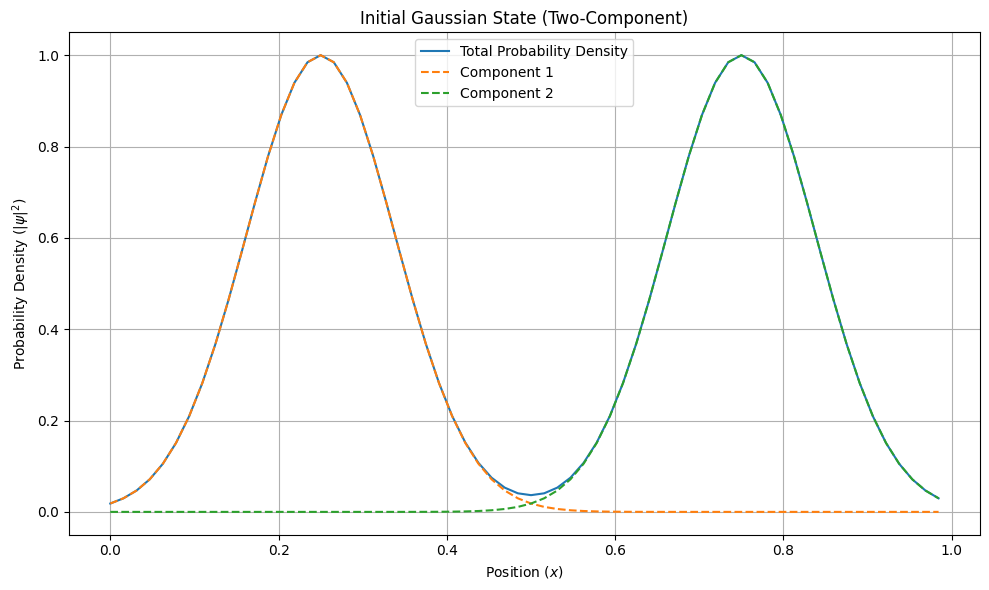

Running 32 hybrid quantum-classical steps...
An error occurred during the simulation: 'Statevector' object has no attribute 'normalize'


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import QFT
from scipy.interpolate import make_interp_spline

# Ignore all DeprecationWarnings from Qiskit and other libraries
warnings.filterwarnings('ignore', category=DeprecationWarning)

# ----------------------- Control Flags ----------------------- #
# Toggles for plotting. Keep True to see results.
PLOT_INITIAL = True
PLOT_TIMESTEPS = True
PLOT_SPLINE = True

# ----------------- Physical and Numerical Setup ----------------- #
nu = 0.01  # Viscosity coefficient
L = 1.0    # Physical domain length
N = 64     # Number of grid points (must be a power of 2 for qubits)

# Correctly determine the total number of qubits needed for the two-component spinor state
n_qubits = int(np.log2(2 * N))

dx = L / N
x_vals = np.linspace(0, L, N, endpoint=False) # Use endpoint=False for periodic domain
CFL = 0.2  # Courant-Friedrichs-Lewy condition
u_max = 1.0
dt_conv = CFL * dx / u_max
dt_diff = 0.5 * dx**2 / nu
dt = min(dt_conv, dt_diff)
t_final = 0.1
nt = int(t_final / dt)
hbar = 1.0 # Planck constant
m = 1.0    # Particle mass

print(f"Simulation parameters: N={N}, n_qubits={n_qubits}, dt={dt:.6f}, nt={nt}")

# ----------------- Classical Utility Functions (from ClassicalHSE.txt) ----------------- #
def dfdx(data, dx):
    """
    Computes the first spatial derivative using a second-order central difference
    with periodic boundary conditions.
    """
    diff = np.zeros_like(data, dtype=complex)
    # Use array slicing for efficiency
    diff[1:-1] = (data[2:] - data[:-2]) / (2 * dx)
    diff[0] = (data[1] - data[-1]) / (2 * dx)
    diff[-1] = (data[0] - data[-2]) / (2 * dx)
    return diff

def d2fdx2(data, dx):
    """
    Computes the second spatial derivative using a second-order central difference
    with periodic boundary conditions.
    """
    diff = np.zeros_like(data, dtype=complex)
    # Use array slicing for efficiency
    diff[1:-1] = (data[2:] - 2 * data[1:-1] + data[:-2]) / dx**2
    diff[0] = (data[-1] - 2 * data[0] + data[1]) / dx**2
    diff[-1] = (data[-2] - 2 * data[-1] + data[0]) / dx**2
    return diff

def compute_rho_velocity(psi1, psi2, dx):
    """
    Computes mass density (rho) and velocity (u) from the two-component
    wave function psi1 and psi2, as per the classical file.
    """
    rho = np.abs(psi1)**2 + np.abs(psi2)**2
    # Avoid division by zero
    u = np.zeros_like(rho)
    nonzero_rho = rho > 1e-12
    u[nonzero_rho] = np.real((np.real(psi1[nonzero_rho]) * dfdx(np.imag(psi1), dx)[nonzero_rho] - np.imag(psi1[nonzero_rho]) * dfdx(np.real(psi1), dx)[nonzero_rho] +
                             np.real(psi2[nonzero_rho]) * dfdx(np.imag(psi2), dx)[nonzero_rho] - np.imag(psi2[nonzero_rho]) * dfdx(np.real(psi2), dx)[nonzero_rho])) / rho[nonzero_rho]
    return rho, u

def compute_s(psi1, psi2):
    """
    Computes the spin vector components from the two-component wave function.
    """
    s1 = np.real(np.abs(psi1)**2 - np.abs(psi2)**2)
    s2 = np.real(1j * (np.conjugate(psi1) * psi2 - psi1 * np.conjugate(psi2)))
    s3 = np.real(np.conjugate(psi1) * psi2 + psi1 * np.conjugate(psi2))
    return s1, s2, s3

# ------------------ Initial State (Quantum Preparation) ------------------ #
def initial_gaussian_state(N):
    """
    Prepares a two-component quantum state with a Gaussian profile.
    This serves as a more physically realistic initial condition than a sharp step.
    The two components are prepared as two separate Gaussians.
    """
    N_points = N
    x = np.linspace(0, L, N_points, endpoint=False)
    sigma = L / 8  # Width of the Gaussian
    mu = L / 4    # Center of the Gaussian

    # Component 1: Gaussian at x = L/4
    psi1 = np.exp(-((x - mu)**2) / (2 * sigma**2))
    # Component 2: Gaussian at x = 3L/4
    psi2 = np.exp(-((x - 3 * mu)**2) / (2 * sigma**2))

    # Combine into a single statevector
    # The state is a superposition over the two components and the spatial grid
    state_vector = np.concatenate([psi1, psi2])

    # Normalize the statevector
    state_vector /= np.linalg.norm(state_vector)

    init_sv = Statevector(state_vector)

    if PLOT_INITIAL:
        # Plot the probability densities of each component
        rho1 = np.abs(psi1)**2
        rho2 = np.abs(psi2)**2
        rho_total = rho1 + rho2

        plt.figure(figsize=(10, 6))
        plt.plot(x, rho_total, label='Total Probability Density')
        plt.plot(x, rho1, '--', label='Component 1')
        plt.plot(x, rho2, '--', label='Component 2')
        plt.title("Initial Gaussian State (Two-Component)")
        plt.xlabel("Position ($x$)")
        plt.ylabel("Probability Density ($|\\psi|^2$)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return init_sv

# ------------------ Quantum Operators ------------------ #
def unitary_kinetic_operator(n_qubits, dt, N):
    """
    Creates the unitary operator for the kinetic term using QFT.
    It operates on the full two-component wave function space.
    """
    dimension = 2**n_qubits

    # Create QFT and IQFT as Operator objects
    qft_op = Operator(QFT(n_qubits, do_swaps=True))
    iqft_op = Operator(QFT(n_qubits, do_swaps=True).inverse())

    # Apply phase shifts in momentum space
    k_vals = np.fft.fftfreq(N, d=dx) * 2 * np.pi

    # Create the phase array, duplicated for both components
    phase_angles_N = -(hbar**2 / (2 * m)) * (k_vals**2) * dt
    phase_angles_2N = np.concatenate([phase_angles_N, phase_angles_N])

    # Create the diagonal phase matrix directly
    phase_matrix = np.diag(np.exp(1j * phase_angles_2N))

    # Combine the operators using matrix multiplication
    kinetic_operator = iqft_op.data @ phase_matrix @ qft_op.data

    return Operator(kinetic_operator)


def isf_phase_correction_operator(N, dt, rho, s):
    """
    Creates a diagonal unitary operator for the non-linear potential term
    of the ISF Hamiltonian. The potential is computed classically and
    applied as a phase correction.
    """
    dimension = 2 * N

    # The term is proportional to (∇s)^2 = (∇s1)^2 + (∇s2)^2 + (∇s3)^2.
    # The sum needs to be performed over the three spin components (axis=0)
    # to get a potential for each grid point.
    grads_s_sq_sum = np.sum(dfdx(s, dx)**2, axis=0)

    # To handle potential division by zero
    rho_safe = np.where(rho > 1e-12, rho, 1e-12)
    nonlinear_potential = -(hbar**2 / (8 * rho_safe**2)) * grads_s_sq_sum

    # Create the phase shift angles, duplicated for the two-component state
    theta = -nonlinear_potential * dt / hbar
    phase_angles = np.concatenate([theta, theta])

    # Create a diagonal operator to apply the phase shifts
    phase_matrix = np.diag(np.exp(1j * phase_angles))

    return Operator(phase_matrix)

def non_unitary_viscosity_channel(n_qubits, dt, nu, N):
    """
    Creates a non-unitary Kraus operator for the viscosity term.
    This is a classical way to model dissipation in a quantum circuit.
    The decay function is applied in momentum space.
    """
    dimension = 2**n_qubits

    # Calculate k_vals for the N grid points
    k_vals = np.fft.fftfreq(N, d=dx) * 2 * np.pi
    decay_N = np.exp(-nu * (k_vals**2) * dt / 2)

    # Duplicate for the two-component state
    decay_2N = np.concatenate([decay_N, decay_N])

    K_momentum = np.diag(decay_2N)

    qft_circ = QFT(n_qubits, do_swaps=True)
    qft = Operator(qft_circ)
    iqft = Operator(qft_circ.inverse())

    # Transform Kraus operator to position basis
    K_position = iqft.data @ K_momentum @ qft.data
    return [K_position, np.sqrt(np.identity(dimension, dtype=complex) - np.conjugate(K_position.T) @ K_position)]

# ------------------ Run Simulation (Hybrid ISF Method) ------------------ #
try:
    # Initialize the quantum state
    statevector = initial_gaussian_state(N)
    results = [np.abs(statevector.data)**2]
    times = [0.0]

    print(f"Running {nt} hybrid quantum-classical steps...")

    # Define the static operators for the Trotter-Suzuki decomposition
    # Note: The kinetic and viscosity operators are static
    U_kinetic = unitary_kinetic_operator(n_qubits, dt, N)
    D_viscosity = non_unitary_viscosity_channel(n_qubits, dt, nu, N)

    for i in range(nt):
        # --- Classical Calculation Step ---
        # 1. Get classical fluid quantities from the current quantum state
        psi1_data = statevector.data[:N]
        psi2_data = statevector.data[N:]

        rho, u = compute_rho_velocity(psi1_data, psi2_data, dx)
        s1, s2, s3 = compute_s(psi1_data, psi2_data)
        s_vec = np.vstack([s1, s2, s3])

        # 2. Use classical quantities to compute the nonlinear potential operator
        U_nonlinear = isf_phase_correction_operator(N, dt, rho, s_vec)

        # --- Quantum Evolution Step (Trotterization) ---
        # 1. Half-step: Apply kinetic and nonlinear potential operators
        statevector = statevector.evolve(U_kinetic)
        statevector = statevector.evolve(U_nonlinear)

        # 2. Apply non-unitary dissipation channel (only the first Kraus operator)
        statevector = statevector.evolve(D_viscosity[0])

        # 3. Half-step: Apply nonlinear potential and kinetic operators
        statevector = statevector.evolve(U_nonlinear)
        statevector = statevector.evolve(U_kinetic)

        # --- Post-processing ---
        # Re-normalize after non-unitary operations
        statevector.normalize()

        results.append(np.abs(statevector.data)**2)
        times.append(times[-1] + dt)

    print("Simulation complete.")

    # ------------------ Plotting ------------------ #
    if PLOT_TIMESTEPS:
        plt.figure(figsize=(10, 6))
        indices = np.linspace(0, len(times) - 1, min(len(times), 8), dtype=int)
        for idx in indices:
            # The full statevector is 2*N, we only care about the density on the first half
            rho_total = results[idx][:N] + results[idx][N:]
            plt.plot(x_vals, rho_total, label=f't={times[idx]:.3f}')
        plt.xlabel('Position ($x$)')
        plt.ylabel('Probability Density ($|\\psi|^2$)')
        plt.title("Hybrid ISF Simulation of Burgers' Equation")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    if PLOT_SPLINE:
        plt.figure(figsize=(10, 6))
        for idx in indices:
            rho_total = results[idx][:N] + results[idx][N:]
            # Smooth the data for better visualization
            spline = make_interp_spline(x_vals, rho_total, k=3)
            x_smooth = np.linspace(x_vals[0], x_vals[-1], 2000)
            y_smooth = spline(x_smooth)
            plt.plot(x_smooth, y_smooth, label=f't={times[idx]:.3f}')
        plt.xlabel('Position ($x$)')
        plt.ylabel('Probability Density ($|\\psi|^2$)')
        plt.title('Smoothed Hybrid ISF Simulation')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"An error occurred during the simulation: {e}")


Simulation parameters: N=64, n_qubits=7, dt=0.003125, nt=32


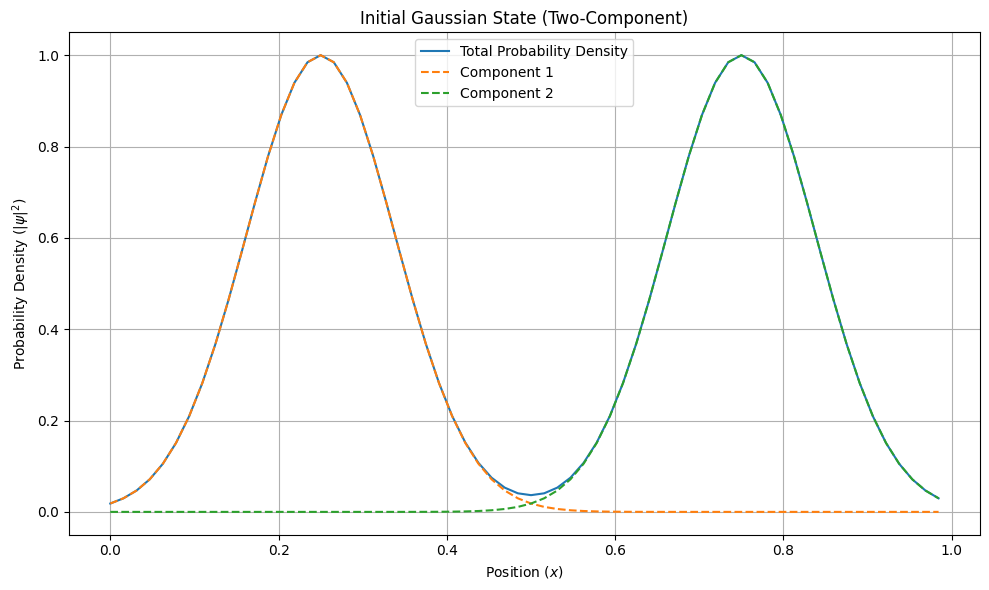

Running 32 hybrid quantum-classical steps...
Simulation complete.


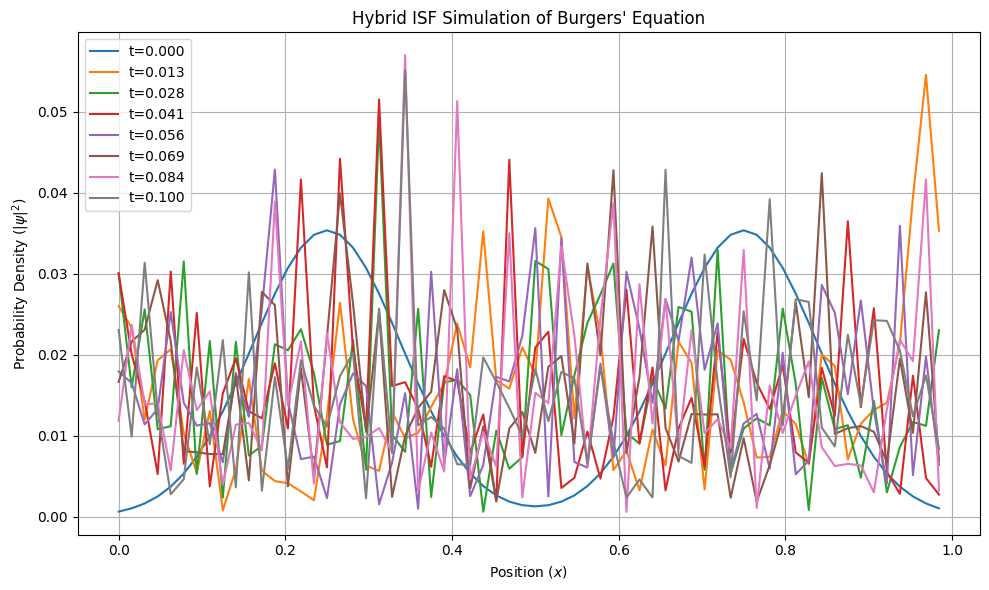

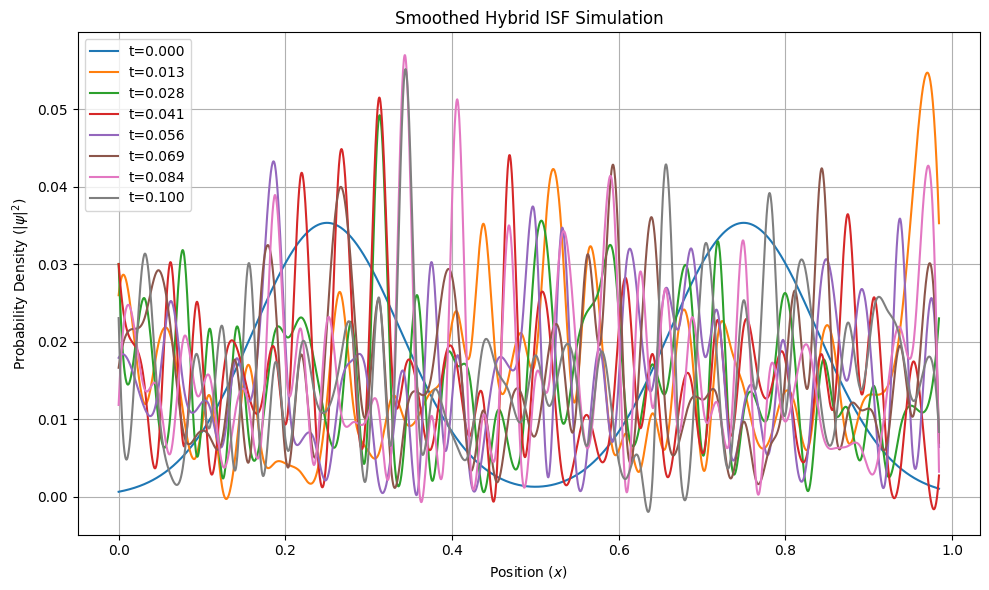

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import QFT
from scipy.interpolate import make_interp_spline

# Ignore all DeprecationWarnings from Qiskit and other libraries
warnings.filterwarnings('ignore', category=DeprecationWarning)

# ----------------------- Control Flags ----------------------- #
# Toggles for plotting. Keep True to see results.
PLOT_INITIAL = True
PLOT_TIMESTEPS = True
PLOT_SPLINE = True

# ----------------- Physical and Numerical Setup ----------------- #
nu = 0.01  # Viscosity coefficient
L = 1.0    # Physical domain length
N = 64     # Number of grid points (must be a power of 2 for qubits)

# Correctly determine the total number of qubits needed for the two-component spinor state
n_qubits = int(np.log2(2 * N))

dx = L / N
x_vals = np.linspace(0, L, N, endpoint=False) # Use endpoint=False for periodic domain
CFL = 0.2  # Courant-Friedrichs-Lewy condition
u_max = 1.0
dt_conv = CFL * dx / u_max
dt_diff = 0.5 * dx**2 / nu
dt = min(dt_conv, dt_diff)
t_final = 0.1
nt = int(t_final / dt)
hbar = 1.0 # Planck constant
m = 1.0    # Particle mass

print(f"Simulation parameters: N={N}, n_qubits={n_qubits}, dt={dt:.6f}, nt={nt}")

# ----------------- Classical Utility Functions (from ClassicalHSE.txt) ----------------- #
def dfdx(data, dx):
    """
    Computes the first spatial derivative using a second-order central difference
    with periodic boundary conditions.
    """
    diff = np.zeros_like(data, dtype=complex)
    # Use array slicing for efficiency
    diff[1:-1] = (data[2:] - data[:-2]) / (2 * dx)
    diff[0] = (data[1] - data[-1]) / (2 * dx)
    diff[-1] = (data[0] - data[-2]) / (2 * dx)
    return diff

def d2fdx2(data, dx):
    """
    Computes the second spatial derivative using a second-order central difference
    with periodic boundary conditions.
    """
    diff = np.zeros_like(data, dtype=complex)
    # Use array slicing for efficiency
    diff[1:-1] = (data[2:] - 2 * data[1:-1] + data[:-2]) / dx**2
    diff[0] = (data[-1] - 2 * data[0] + data[1]) / dx**2
    diff[-1] = (data[-2] - 2 * data[-1] + data[0]) / dx**2
    return diff

def compute_rho_velocity(psi1, psi2, dx):
    """
    Computes mass density (rho) and velocity (u) from the two-component
    wave function psi1 and psi2, as per the classical file.
    """
    rho = np.abs(psi1)**2 + np.abs(psi2)**2
    # Avoid division by zero
    u = np.zeros_like(rho)
    nonzero_rho = rho > 1e-12
    u[nonzero_rho] = np.real((np.real(psi1[nonzero_rho]) * dfdx(np.imag(psi1), dx)[nonzero_rho] - np.imag(psi1[nonzero_rho]) * dfdx(np.real(psi1), dx)[nonzero_rho] +
                             np.real(psi2[nonzero_rho]) * dfdx(np.imag(psi2), dx)[nonzero_rho] - np.imag(psi2[nonzero_rho]) * dfdx(np.real(psi2), dx)[nonzero_rho])) / rho[nonzero_rho]
    return rho, u

def compute_s(psi1, psi2):
    """
    Computes the spin vector components from the two-component wave function.
    """
    s1 = np.real(np.abs(psi1)**2 - np.abs(psi2)**2)
    s2 = np.real(1j * (np.conjugate(psi1) * psi2 - psi1 * np.conjugate(psi2)))
    s3 = np.real(np.conjugate(psi1) * psi2 + psi1 * np.conjugate(psi2))
    return s1, s2, s3

# ------------------ Initial State (Quantum Preparation) ------------------ #
def initial_gaussian_state(N):
    """
    Prepares a two-component quantum state with a Gaussian profile.
    This serves as a more physically realistic initial condition than a sharp step.
    The two components are prepared as two separate Gaussians.
    """
    N_points = N
    x = np.linspace(0, L, N_points, endpoint=False)
    sigma = L / 8  # Width of the Gaussian
    mu = L / 4    # Center of the Gaussian

    # Component 1: Gaussian at x = L/4
    psi1 = np.exp(-((x - mu)**2) / (2 * sigma**2))
    # Component 2: Gaussian at x = 3L/4
    psi2 = np.exp(-((x - 3 * mu)**2) / (2 * sigma**2))

    # Combine into a single statevector
    # The state is a superposition over the two components and the spatial grid
    state_vector = np.concatenate([psi1, psi2])

    # Normalize the statevector
    state_vector /= np.linalg.norm(state_vector)

    init_sv = Statevector(state_vector)

    if PLOT_INITIAL:
        # Plot the probability densities of each component
        rho1 = np.abs(psi1)**2
        rho2 = np.abs(psi2)**2
        rho_total = rho1 + rho2

        plt.figure(figsize=(10, 6))
        plt.plot(x, rho_total, label='Total Probability Density')
        plt.plot(x, rho1, '--', label='Component 1')
        plt.plot(x, rho2, '--', label='Component 2')
        plt.title("Initial Gaussian State (Two-Component)")
        plt.xlabel("Position ($x$)")
        plt.ylabel("Probability Density ($|\\psi|^2$)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return init_sv

# ------------------ Quantum Operators ------------------ #
def unitary_kinetic_operator(n_qubits, dt, N):
    """
    Creates the unitary operator for the kinetic term using QFT.
    It operates on the full two-component wave function space.
    """
    dimension = 2**n_qubits

    # Create QFT and IQFT as Operator objects
    qft_op = Operator(QFT(n_qubits, do_swaps=True))
    iqft_op = Operator(QFT(n_qubits, do_swaps=True).inverse())

    # Apply phase shifts in momentum space
    k_vals = np.fft.fftfreq(N, d=dx) * 2 * np.pi

    # Create the phase array, duplicated for both components
    phase_angles_N = -(hbar**2 / (2 * m)) * (k_vals**2) * dt
    phase_angles_2N = np.concatenate([phase_angles_N, phase_angles_N])

    # Create the diagonal phase matrix directly
    phase_matrix = np.diag(np.exp(1j * phase_angles_2N))

    # Combine the operators using matrix multiplication
    kinetic_operator = iqft_op.data @ phase_matrix @ qft_op.data

    return Operator(kinetic_operator)


def isf_phase_correction_operator(N, dt, rho, s):
    """
    Creates a diagonal unitary operator for the non-linear potential term
    of the ISF Hamiltonian. The potential is computed classically and
    applied as a phase correction.
    """
    dimension = 2 * N

    # The term is proportional to (∇s)^2 = (∇s1)^2 + (∇s2)^2 + (∇s3)^2.
    # The sum needs to be performed over the three spin components (axis=0)
    # to get a potential for each grid point.
    grads_s_sq_sum = np.sum(dfdx(s, dx)**2, axis=0)

    # To handle potential division by zero
    rho_safe = np.where(rho > 1e-12, rho, 1e-12)
    nonlinear_potential = -(hbar**2 / (8 * rho_safe**2)) * grads_s_sq_sum

    # Create the phase shift angles, duplicated for the two-component state
    theta = -nonlinear_potential * dt / hbar
    phase_angles = np.concatenate([theta, theta])

    # Create a diagonal operator to apply the phase shifts
    phase_matrix = np.diag(np.exp(1j * phase_angles))

    return Operator(phase_matrix)

def non_unitary_viscosity_channel(n_qubits, dt, nu, N):
    """
    Creates a non-unitary Kraus operator for the viscosity term.
    This is a classical way to model dissipation in a quantum circuit.
    The decay function is applied in momentum space.
    """
    dimension = 2**n_qubits

    # Calculate k_vals for the N grid points
    k_vals = np.fft.fftfreq(N, d=dx) * 2 * np.pi
    decay_N = np.exp(-nu * (k_vals**2) * dt / 2)

    # Duplicate for the two-component state
    decay_2N = np.concatenate([decay_N, decay_N])

    K_momentum = np.diag(decay_2N)

    qft_circ = QFT(n_qubits, do_swaps=True)
    qft = Operator(qft_circ)
    iqft = Operator(qft_circ.inverse())

    # Transform Kraus operator to position basis
    K_position = iqft.data @ K_momentum @ qft.data
    return [K_position, np.sqrt(np.identity(dimension, dtype=complex) - np.conjugate(K_position.T) @ K_position)]

# ------------------ Run Simulation (Hybrid ISF Method) ------------------ #
try:
    # Initialize the quantum state
    statevector = initial_gaussian_state(N)
    results = [np.abs(statevector.data)**2]
    times = [0.0]

    print(f"Running {nt} hybrid quantum-classical steps...")

    # Define the static operators for the Trotter-Suzuki decomposition
    # Note: The kinetic and viscosity operators are static
    U_kinetic = unitary_kinetic_operator(n_qubits, dt, N)
    D_viscosity = non_unitary_viscosity_channel(n_qubits, dt, nu, N)

    for i in range(nt):
        # --- Classical Calculation Step ---
        # 1. Get classical fluid quantities from the current quantum state
        psi1_data = statevector.data[:N]
        psi2_data = statevector.data[N:]

        rho, u = compute_rho_velocity(psi1_data, psi2_data, dx)
        s1, s2, s3 = compute_s(psi1_data, psi2_data)
        s_vec = np.vstack([s1, s2, s3])

        # 2. Use classical quantities to compute the nonlinear potential operator
        U_nonlinear = isf_phase_correction_operator(N, dt, rho, s_vec)

        # --- Quantum Evolution Step (Trotterization) ---
        # 1. Half-step: Apply kinetic and nonlinear potential operators
        statevector = statevector.evolve(U_kinetic)
        statevector = statevector.evolve(U_nonlinear)

        # 2. Apply non-unitary dissipation channel (only the first Kraus operator)
        statevector = statevector.evolve(D_viscosity[0])

        # 3. Half-step: Apply nonlinear potential and kinetic operators
        statevector = statevector.evolve(U_nonlinear)
        statevector = statevector.evolve(U_kinetic)

        # --- Post-processing ---
        # Re-normalize after non-unitary operations
        statevector = Statevector(statevector.data / np.linalg.norm(statevector.data))

        results.append(np.abs(statevector.data)**2)
        times.append(times[-1] + dt)

    print("Simulation complete.")

    # ------------------ Plotting ------------------ #
    if PLOT_TIMESTEPS:
        plt.figure(figsize=(10, 6))
        indices = np.linspace(0, len(times) - 1, min(len(times), 8), dtype=int)
        for idx in indices:
            # The full statevector is 2*N, we only care about the density on the first half
            rho_total = results[idx][:N] + results[idx][N:]
            plt.plot(x_vals, rho_total, label=f't={times[idx]:.3f}')
        plt.xlabel('Position ($x$)')
        plt.ylabel('Probability Density ($|\\psi|^2$)')
        plt.title("Hybrid ISF Simulation of Burgers' Equation")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    if PLOT_SPLINE:
        plt.figure(figsize=(10, 6))
        for idx in indices:
            rho_total = results[idx][:N] + results[idx][N:]
            # Smooth the data for better visualization
            spline = make_interp_spline(x_vals, rho_total, k=3)
            x_smooth = np.linspace(x_vals[0], x_vals[-1], 2000)
            y_smooth = spline(x_smooth)
            plt.plot(x_smooth, y_smooth, label=f't={times[idx]:.3f}')
        plt.xlabel('Position ($x$)')
        plt.ylabel('Probability Density ($|\\psi|^2$)')
        plt.title('Smoothed Hybrid ISF Simulation')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"An error occurred during the simulation: {e}")


/tmp/ipython-input-1793819687.py:122: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft = QFT(na, inverse=False, do_swaps=True)
/tmp/ipython-input-1793819687.py:123: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft = QFT(na, inverse=True, do_swaps=True)


Running classical simulation of heat equation (Schrödingerisation)...
Running classical simulation of heat equation (Matrix Exponential)...
Running quantum simulation of heat equation...


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


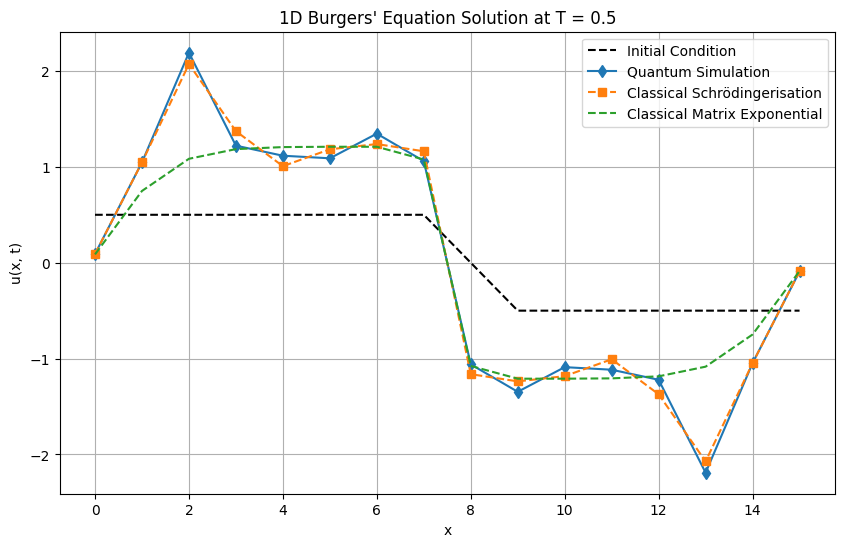

In [4]:
import numpy as np
import scipy.sparse as sp
from tqdm import tqdm
import matplotlib.pyplot as plt

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.primitives import StatevectorEstimator
from qiskit.circuit.library import QFT

# Define the core quantum circuits from the original heat equation example
# These circuits are generic building blocks for the Schrödingerisation method.

def Wj(j, theta, lam, name='Wj', xgate=False):
    """
    Wj circuit for the Schrödingerisation method.

    Args:
        j (int): The number of qubits.
        theta (float): Rotation angle.
        lam (float): Phase angle.
        name (str): Name of the circuit.
        xgate (bool): Flag to apply extra X gates for certain Hamiltonians.

    Returns:
        QuantumCircuit: The Wj circuit.
    """
    if not xgate:
        name = f' $W_{j}$ '
    qc = QuantumCircuit(j, name=name)

    if j > 1:
        qc.cx(j - 1, range(j - 1))
    if lam != 0:
        qc.p(lam, j - 1)
    qc.h(j - 1)
    if xgate:
        qc.x(range(j - 1))

    # The multi-controlled RZ gate
    if j > 1:
        qc.mcrz(theta, list(range(j - 1)), j - 1)
    else:
        qc.rz(theta, j - 1)

    if xgate:
        qc.x(range(j - 1))
    qc.h(j - 1)
    if lam != 0:
        qc.p(-lam, j - 1)
    if j > 1:
        qc.cx(j - 1, range(j - 1))

    return qc

def V0(theta, n):
    """
    H1_circ for the heat equation.

    Args:
        theta (float): Rotation angle.
        n (int): Number of qubits.

    Returns:
        QuantumCircuit: The V0 circuit.
    """
    qc = QuantumCircuit(n, global_phase=theta, name='$V_0$')
    for j in range(1, n + 1):
        qc.append(Wj(j, theta, 0), range(j))
    return qc

def cV0(theta, n):
    """
    Controlled H1_circ for the heat equation.

    Args:
        theta (float): Rotation angle.
        n (int): Number of qubits.

    Returns:
        QuantumCircuit: The cV0 circuit.
    """
    qc = QuantumCircuit(n + 1, name='$cV_0$')
    qc.p(theta, 0)
    for j in range(1, n + 1):
        cWj = Wj(j, theta, 0).to_gate().control()
        qc.append(cWj, list(range(j + 1)))
    return qc

# The core Schrödingerisation function, adapted for modern Qiskit primitives
def schro(u0, iH1, cH1, H2=None, R=4, na=3, Nt=1, obs=None, E=None):
    """
    Performs the Schrödingerisation quantum simulation.

    Args:
        u0 (np.array): Initial condition vector.
        iH1 (QuantumCircuit): Circuit for inverse H1.
        cH1 (QuantumCircuit): Controlled circuit for H1.
        H2 (QuantumCircuit): Circuit for H2 (optional).
        R (int): Momentum space area parameter.
        na (int): Number of ancillary qubits.
        Nt (int): Number of time steps.
        obs (Pauli): Observable to measure (optional).
        E (np.array): Expectation values from classical simulation (optional).

    Returns:
        tuple: Final state vector and the quantum circuit.
    """
    dp = 2 * R * np.pi / 2**na
    fp = np.exp(-np.abs(np.arange(-R * np.pi, R * np.pi, step=dp)))
    norm = np.linalg.norm(u0) * np.linalg.norm(fp)

    nx = int(np.log2(u0.shape[0]))
    rx = QuantumRegister(nx, name='x')
    ra = QuantumRegister(na, name='p')
    qc = QuantumCircuit(rx, ra)

    qc.initialize(u0 / np.linalg.norm(u0), rx)
    qc.initialize(fp / np.linalg.norm(fp), ra)

    qft = QFT(na, inverse=False, do_swaps=True)
    iqft = QFT(na, inverse=True, do_swaps=True)
    qc.append(qft, ra)
    qc.x(ra[-1])

    for i in tqdm(range(Nt)):
        for j in range(na):
            qc.append(cH1.repeat(2**j), [ra[j]] + list(rx[:]))
        qc.append(iH1.repeat(2**(na - 1)), list(rx[:]))

        if H2 is not None:
            qc.append(H2, list(rx[:]))

    qc.x(ra[-1])
    qc.append(iqft, ra)

    final_state = Statevector(qc)
    u_proj = final_state.data.reshape(2**na, 2**nx)
    u = np.real(u_proj[2**(na - 1)]) * norm

    return u, qc

def schro_calssical(u0, A, R=4, na=3, T=3):
    """
    Classical simulation of the Schrödingerised system.

    Args:
        u0 (np.array): Initial condition.
        A (sp.csc_matrix): The matrix A.
        R (int): Momentum space parameter.
        na (int): Number of ancillary qubits.
        T (float): Final time.

    Returns:
        np.array: Final state vector.
    """
    A1 = (A + A.T.conjugate()) / 2
    A2 = -1j * (A - A.T.conjugate()) / 2

    Nx = A1.shape[0]
    Na = 2**na

    dp = 2 * R * np.pi / 2**na
    p = np.arange(-R * np.pi, R * np.pi, step=dp)
    fp = np.exp(-np.abs(p))
    up = u0 * fp[:, None]

    eta = np.arange(Na)
    eta[2**(na - 1):] -= Na
    eta = eta / R
    diag_eta = sp.csc_matrix((eta, (range(Na), range(Na))), shape=[Na, Na])

    ueta = np.fft.fft(up, axis=0)
    ueta = ueta.flatten()

    H = sp.csc_matrix(sp.kron(diag_eta, A1) + sp.kron(sp.eye(Na), A2))
    ueta = sp.linalg.expm_multiply(1j * H * T, ueta)
    ueta = ueta.reshape(Na, Nx)
    up = np.fft.ifft(ueta, axis=0)
    up = np.real(up)

    u = up[2**(na - 1)]
    return u

def matrix_exponential(u0, A, T=3):
    """
    Classical simulation using matrix exponential.

    Args:
        u0 (np.array): Initial condition.
        A (sp.csc_matrix): The matrix A.
        T (float): Final time.

    Returns:
        np.array: Final state vector.
    """
    u = sp.linalg.expm_multiply(A * T, u0)
    return u

# ----- Burgers' Equation Specific Functions -----

def initial_burgers(nx=4, L=2**4, nu=0.1):
    """
    Sets up the initial condition for the Burgers' equation and
    applies the Cole-Hopf transformation.

    Args:
        nx (int): Number of qubits for the spatial dimension.
        L (int): Length of the spatial domain.
        nu (float): Viscosity coefficient.

    Returns:
        tuple: x coordinates, initial u0, and initial psi0.
    """
    Nx = 2**nx
    dx = L / Nx
    x = np.arange(0, L, step=dx)

    # Initial condition for Burgers' u(x,0) (step function)
    u0 = np.zeros(Nx)
    u0[:Nx // 2] = 1.0  # Invert the step function for a shock to form
    u0 = u0 - u0.mean() # Center the step function around 0
    u0 = -0.5 * np.tanh(10*(x-8)) # A smoother approximation of a step function

    # Transform u0 to psi0 using the Cole-Hopf transformation
    psi0 = np.exp(-1 / (2 * nu) * np.cumsum(u0) * dx)

    return x, u0, psi0, dx

def coeff_burgers(na=5, R=4, T=1, dt=0.005, nu=0.1):
    """
    Defines coefficients and circuits for the Burgers' equation (via the heat equation).

    Args:
        na (int): Number of qubits for the ancillary register.
        R (int): Parameter for the momentum space.
        T (float): Final time.
        dt (float): Time step.
        nu (float): Viscosity coefficient.

    Returns:
        tuple: Coefficients and quantum circuits.
    """
    nx = 4
    L = 2**nx

    Nt = int(T / dt)
    x, u0, psi0, dx = initial_burgers(nx=nx, L=L, nu=nu)

    A = -2 * np.eye(2**nx) + np.eye(2**nx, k=1) + np.eye(2**nx, k=-1)
    A = sp.csc_matrix(A) * nu / dx**2

    gamma0 = nu / dx**2
    theta = -2 * gamma0 * dt
    iH1 = V0(-theta / R, nx)
    cH1 = cV0(theta / R, nx)
    H2 = None

    return nx, L, nu, x, u0, psi0, A, iH1, cH1, H2, R, na, Nt, dx

def run_burgers(na=5, R=4, T=1, dt=0.005):
    """
    Runs the quantum simulation for the Burgers' equation.

    Args:
        na (int): Number of qubits for the ancillary register.
        R (int): Parameter for the momentum space.
        T (float): Final time.
        dt (float): Time step.

    Returns:
        tuple: x coordinates, u_quantum, u_classical_schro, u_matrix_exp.
    """
    nx, L, nu, x, u0_burgers, psi0, A, iH1, cH1, H2, R, na, Nt, dx = coeff_burgers(na=na, R=R, T=T, dt=dt)

    print('Running classical simulation of heat equation (Schrödingerisation)...')
    psi_classical = schro_calssical(u0=psi0, A=A, R=R, na=na, T=Nt * dt)
    print('Running classical simulation of heat equation (Matrix Exponential)...')
    psi_matrix_exp = matrix_exponential(u0=psi0, A=A, T=Nt * dt)

    print('Running quantum simulation of heat equation...')
    psi_quantum, qc = schro(u0=psi0, iH1=iH1, cH1=cH1, H2=H2, R=R, na=na, Nt=Nt)

    # Inverse Cole-Hopf transformation with a stability fix
    # Add a small epsilon to the denominator to avoid division by zero.
    epsilon = 1e-12

    u_quantum = -2 * nu / (2 * dx) * (np.roll(psi_quantum, -1) - np.roll(psi_quantum, 1)) / (psi_quantum + epsilon)
    u_classical_schro = -2 * nu / (2 * dx) * (np.roll(psi_classical, -1) - np.roll(psi_classical, 1)) / (psi_classical + epsilon)
    u_matrix_exp = -2 * nu / (2 * dx) * (np.roll(psi_matrix_exp, -1) - np.roll(psi_matrix_exp, 1)) / (psi_matrix_exp + epsilon)

    return x, u0_burgers, u_quantum, u_classical_schro, u_matrix_exp

def plot_burgers_solution(x, u0, u_quantum, u_classical, u_matrix_exp, T):
    """
    Plots the initial and final solutions for the Burgers' equation.

    Args:
        x (np.array): Spatial coordinates.
        u0 (np.array): Initial solution.
        u_quantum (np.array): Final solution from the quantum simulation.
        u_classical (np.array): Final solution from the classical Schrödingerisation.
        u_matrix_exp (np.array): Final solution from the classical matrix exponential.
        T (float): Final time.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(x, u0, 'k--', label='Initial Condition')
    plt.plot(x, u_quantum, 'd-', label='Quantum Simulation')
    plt.plot(x, u_classical, 's--', label='Classical Schrödingerisation')
    plt.plot(x, u_matrix_exp, '--', label='Classical Matrix Exponential')
    plt.title(f'1D Burgers\' Equation Solution at T = {T}')
    plt.xlabel('x')
    plt.ylabel('u(x, t)')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    # Parameters for the simulation
    T_final = 0.5   # Final time
    dt_step = 0.05  # Time step
    na_qubits = 5   # Increased number of ancillary qubits for better resolution

    # Run the simulation
    x, u0, u_quantum, u_classical_schro, u_matrix_exp = run_burgers(na=na_qubits, T=T_final, dt=dt_step)

    # Plot the results
    plot_burgers_solution(x, u0, u_quantum, u_classical_schro, u_matrix_exp, T_final)


/tmp/ipython-input-2122364773.py:122: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft = QFT(na, inverse=False, do_swaps=True)
/tmp/ipython-input-2122364773.py:123: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft = QFT(na, inverse=True, do_swaps=True)


Running classical simulation of heat equation (Schrödingerisation)...
Running classical simulation of heat equation (Matrix Exponential)...
Running quantum simulation of heat equation...


100%|██████████| 50/50 [00:06<00:00,  7.96it/s]


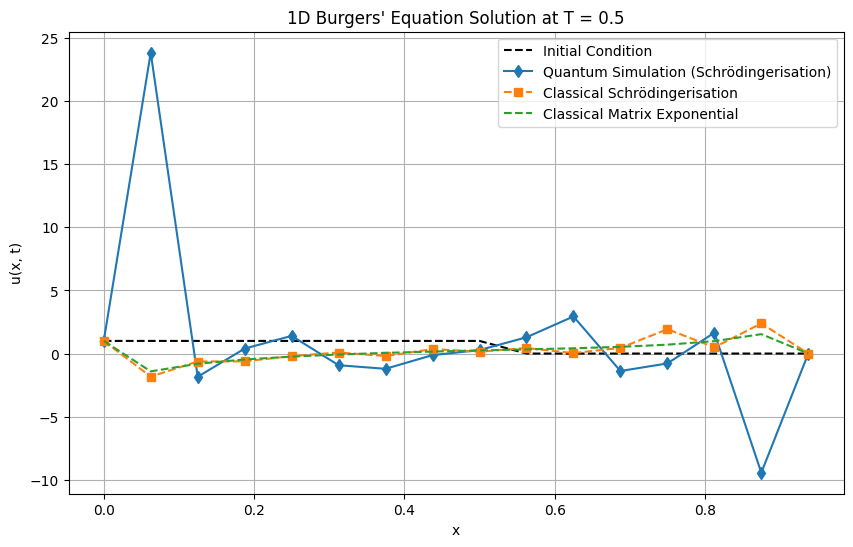

In [11]:
import numpy as np
import scipy.sparse as sp
from tqdm import tqdm
import matplotlib.pyplot as plt

# Qiskit imports
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.primitives import StatevectorEstimator
from qiskit.circuit.library import QFT

# Define the core quantum circuits from the original heat equation example
# These circuits are generic building blocks for the Schrödingerisation method.

def Wj(j, theta, lam, name='Wj', xgate=False):
    """
    Wj circuit for the Schrödingerisation method.

    Args:
        j (int): The number of qubits.
        theta (float): Rotation angle.
        lam (float): Phase angle.
        name (str): Name of the circuit.
        xgate (bool): Flag to apply extra X gates for certain Hamiltonians.

    Returns:
        QuantumCircuit: The Wj circuit.
    """
    if not xgate:
        name = f' $W_{j}$ '
    qc = QuantumCircuit(j, name=name)

    if j > 1:
        qc.cx(j - 1, range(j - 1))
    if lam != 0:
        qc.p(lam, j - 1)
    qc.h(j - 1)
    if xgate:
        qc.x(range(j - 1))

    # The multi-controlled RZ gate
    if j > 1:
        qc.mcrz(theta, list(range(j - 1)), j - 1)
    else:
        qc.rz(theta, j - 1)

    if xgate:
        qc.x(range(j - 1))
    qc.h(j - 1)
    if lam != 0:
        qc.p(-lam, j - 1)
    if j > 1:
        qc.cx(j - 1, range(j - 1))

    return qc

def V0(theta, n):
    """
    H1_circ for the heat equation.

    Args:
        theta (float): Rotation angle.
        n (int): Number of qubits.

    Returns:
        QuantumCircuit: The V0 circuit.
    """
    qc = QuantumCircuit(n, global_phase=theta, name='$V_0$')
    for j in range(1, n + 1):
        qc.append(Wj(j, theta, 0), range(j))
    return qc

def cV0(theta, n):
    """
    Controlled H1_circ for the heat equation.

    Args:
        theta (float): Rotation angle.
        n (int): Number of qubits.

    Returns:
        QuantumCircuit: The cV0 circuit.
    """
    qc = QuantumCircuit(n + 1, name='$cV_0$')
    qc.p(theta, 0)
    for j in range(1, n + 1):
        cWj = Wj(j, theta, 0).to_gate().control()
        qc.append(cWj, list(range(j + 1)))
    return qc

# The core Schrödingerisation function, adapted for modern Qiskit primitives
def schro(u0, iH1, cH1, H2=None, R=4, na=3, Nt=1, obs=None, E=None):
    """
    Performs the Schrödingerisation quantum simulation.

    Args:
        u0 (np.array): Initial condition vector.
        iH1 (QuantumCircuit): Circuit for inverse H1.
        cH1 (QuantumCircuit): Controlled circuit for H1.
        H2 (QuantumCircuit): Circuit for H2 (optional).
        R (int): Momentum space area parameter.
        na (int): Number of ancillary qubits.
        Nt (int): Number of time steps.
        obs (Pauli): Observable to measure (optional).
        E (np.array): Expectation values from classical simulation (optional).

    Returns:
        tuple: Final state vector and the quantum circuit.
    """
    dp = 2 * R * np.pi / 2**na
    fp = np.exp(-np.abs(np.arange(-R * np.pi, R * np.pi, step=dp)))
    norm = np.linalg.norm(u0) * np.linalg.norm(fp)

    nx = int(np.log2(u0.shape[0]))
    rx = QuantumRegister(nx, name='x')
    ra = QuantumRegister(na, name='p')
    qc = QuantumCircuit(rx, ra)

    qc.initialize(u0 / np.linalg.norm(u0), rx)
    qc.initialize(fp / np.linalg.norm(fp), ra)

    qft = QFT(na, inverse=False, do_swaps=True)
    iqft = QFT(na, inverse=True, do_swaps=True)
    qc.append(qft, ra)
    qc.x(ra[-1])

    for i in tqdm(range(Nt)):
        for j in range(na):
            qc.append(cH1.repeat(2**j), [ra[j]] + list(rx[:]))
        qc.append(iH1.repeat(2**(na - 1)), list(rx[:]))

        if H2 is not None:
            qc.append(H2, list(rx[:]))

    qc.x(ra[-1])
    qc.append(iqft, ra)

    final_state = Statevector(qc)
    u_proj = final_state.data.reshape(2**na, 2**nx)
    u = np.real(u_proj[2**(na - 1)]) * norm

    return u, qc

def schro_calssical(u0, A, R=4, na=3, T=3):
    """
    Classical simulation of the Schrödingerised system.

    Args:
        u0 (np.array): Initial condition.
        A (sp.csc_matrix): The matrix A.
        R (int): Momentum space parameter.
        na (int): Number of ancillary qubits.
        T (float): Final time.

    Returns:
        np.array: Final state vector.
    """
    A1 = (A + A.T.conjugate()) / 2
    A2 = -1j * (A - A.T.conjugate()) / 2

    Nx = A1.shape[0]
    Na = 2**na

    dp = 2 * R * np.pi / 2**na
    p = np.arange(-R * np.pi, R * np.pi, step=dp)
    fp = np.exp(-np.abs(p))
    up = u0 * fp[:, None]

    eta = np.arange(Na)
    eta[2**(na - 1):] -= Na
    eta = eta / R
    diag_eta = sp.csc_matrix((eta, (range(Na), range(Na))), shape=[Na, Na])

    ueta = np.fft.fft(up, axis=0)
    ueta = ueta.flatten()

    H = sp.csc_matrix(sp.kron(diag_eta, A1) + sp.kron(sp.eye(Na), A2))
    ueta = sp.linalg.expm_multiply(1j * H * T, ueta)
    ueta = ueta.reshape(Na, Nx)
    up = np.fft.ifft(ueta, axis=0)
    up = np.real(up)

    u = up[2**(na - 1)]
    return u

def matrix_exponential(u0, A, T=3):
    """
    Classical simulation using matrix exponential.

    Args:
        u0 (np.array): Initial condition.
        A (sp.csc_matrix): The matrix A.
        T (float): Final time.

    Returns:
        np.array: Final state vector.
    """
    u = sp.linalg.expm_multiply(A * T, u0)
    return u

# ----- Burgers' Equation Specific Functions -----

def initial_burgers(nx=4, L=1.0):
    """
    Sets up the initial condition for the Burgers' equation
    and applies the Cole-Hopf transformation.

    Args:
        nx (int): Number of qubits for the spatial dimension.
        L (float): Length of the spatial domain.

    Returns:
        tuple: x coordinates, initial u0, and initial psi0.
    """
    Nx = 2**nx
    dx = L / Nx
    x = np.linspace(0, L, Nx, endpoint=False)

    # Initial condition for Burgers' u(x,0) (step function)
    u0 = np.where(x <= 0.5, 1.0, 0.0)

    return x, u0, dx

def apply_BC(u, uL, uR):
    """
    Applies Dirichlet boundary conditions to the solution vector.
    """
    u[0] = uL
    u[-1] = uR
    return u

def coeff_burgers(nx=4, L=1.0, nu=0.1, R=4, na=3, T=1, dt=0.005):
    """
    Defines coefficients and circuits for the Burgers' equation.

    Args:
        nx (int): Number of qubits.
        L (float): Domain length.
        nu (float): Viscosity coefficient.
        R (int): Parameter for the momentum space.
        na (int): Number of ancillary qubits.
        T (float): Final time.
        dt (float): Time step.

    Returns:
        tuple: Coefficients and quantum circuits.
    """
    Nt = int(T / dt)
    x, u0, dx = initial_burgers(nx=nx, L=L)

    # Cole-Hopf transformation
    psi0 = np.exp(-1 / (2 * nu) * np.cumsum(u0) * dx)

    # Boundary conditions for psi, using the initial u0 values
    psiL = np.exp(-1 / (2 * nu) * u0[0] * x[0])
    psiR = np.exp(-1 / (2 * nu) * u0[-1] * x[-1]) # Corrected to use u0 at the last point, x[-1]

    # Finite difference matrix for the heat equation part
    A = sp.lil_matrix((2**nx, 2**nx))
    for i in range(2**nx):
        A[i, i] = -2
        if i > 0:
            A[i, i-1] = 1
        if i < 2**nx - 1:
            A[i, i+1] = 1
    A = sp.csc_matrix(A) * nu / dx**2

    # Set up circuits for the Schrödingerisation
    gamma0 = nu / dx**2
    theta = -2 * gamma0 * dt
    iH1 = V0(-theta / R, nx)
    cH1 = cV0(theta / R, nx)
    H2 = None

    return nx, L, nu, x, u0, psi0, A, iH1, cH1, H2, R, na, Nt, dx, psiL, psiR

def run_burgers(nx=4, na=5, R=4, T=1, dt=0.005):
    """
    Runs the quantum simulation for the Burgers' equation.

    Args:
        nx (int): Number of qubits for spatial dimension.
        na (int): Number of qubits for the ancillary register.
        R (int): Parameter for the momentum space.
        T (float): Final time.
        dt (float): Time step.

    Returns:
        tuple: x coordinates, u_quantum, u_classical_schro, u_matrix_exp.
    """
    (nx, L, nu, x, u0_burgers, psi0, A, iH1, cH1, H2, R, na, Nt, dx, psiL, psiR) = \
        coeff_burgers(nx=nx, na=na, R=R, T=T, dt=dt)

    # Apply Dirichlet boundary conditions to initial psi0
    psi0[0] = psiL
    psi0[-1] = psiR

    print('Running classical simulation of heat equation (Schrödingerisation)...')
    psi_classical = schro_calssical(u0=psi0, A=A, R=R, na=na, T=Nt * dt)
    print('Running classical simulation of heat equation (Matrix Exponential)...')
    psi_matrix_exp = matrix_exponential(u0=psi0, A=A, T=Nt * dt)

    print('Running quantum simulation of heat equation...')
    psi_quantum, qc = schro(u0=psi0, iH1=iH1, cH1=cH1, H2=H2, R=R, na=na, Nt=Nt)

    # Inverse Cole-Hopf transformation with a stability fix
    epsilon = 1e-12

    u_quantum = -2 * nu / (2 * dx) * (np.roll(psi_quantum, -1) - np.roll(psi_quantum, 1)) / (psi_quantum + epsilon)
    u_classical_schro = -2 * nu / (2 * dx) * (np.roll(psi_classical, -1) - np.roll(psi_classical, 1)) / (psi_classical + epsilon)
    u_matrix_exp = -2 * nu / (2 * dx) * (np.roll(psi_matrix_exp, -1) - np.roll(psi_matrix_exp, 1)) / (psi_matrix_exp + epsilon)

    # Apply Dirichlet boundary conditions to the final u solutions
    u_quantum = apply_BC(u_quantum, 1, 0)
    u_classical_schro = apply_BC(u_classical_schro, 1, 0)
    u_matrix_exp = apply_BC(u_matrix_exp, 1, 0)

    return x, u0_burgers, u_quantum, u_classical_schro, u_matrix_exp

def plot_burgers_solution(x, u0, u_quantum, u_classical, u_matrix_exp, T):
    """
    Plots the initial and final solutions for the Burgers' equation.

    Args:
        x (np.array): Spatial coordinates.
        u0 (np.array): Initial solution.
        u_quantum (np.array): Final solution from the quantum simulation.
        u_classical (np.array): Final solution from the classical Schrödingerisation.
        u_matrix_exp (np.array): Final solution from the classical matrix exponential.
        T (float): Final time.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(x, u0, 'k--', label='Initial Condition')
    plt.plot(x, u_quantum, 'd-', label='Quantum Simulation (Schrödingerisation)')
    plt.plot(x, u_classical, 's--', label='Classical Schrödingerisation')
    plt.plot(x, u_matrix_exp, '--', label='Classical Matrix Exponential')
    plt.title(f'1D Burgers\' Equation Solution at T = {T}')
    plt.xlabel('x')
    plt.ylabel('u(x, t)')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    # Parameters for the simulation
    T_final = 0.5 # Final time
    dt_step = 0.01 # Time step
    na_qubits = 5 # Ancillary qubits
    nx_qubits = 4 # Spatial qubits

    # Run the simulation
    x, u0, u_quantum, u_classical_schro, u_matrix_exp = run_burgers(
        nx=nx_qubits, na=na_qubits, T=T_final, dt=dt_step
    )

    # Plot the results
    plot_burgers_solution(x, u0, u_quantum, u_classical_schro, u_matrix_exp, T_final)